This Jupyter notebook contains the GNNExplainer method.

In [1]:
import pandas as pd
import networkx as nx
import numpy as np
import torch

import pickle
import copy

import matplotlib.pyplot as plt

from gensim.models import KeyedVectors

In [2]:
dataset_nr = 2
assert dataset_nr == 1 or 2

# Load all data

Load the nodes

In [3]:
nodes = pd.read_csv(f'output/indexed_nodes_{dataset_nr}.csv')
nodes

index_id                          id   semantic  \
0             0                  MP:0004187  phenotype   
1             1                  ZP:0100138  phenotype   
2             2                 MGI:1346525       gene   
3             3            OMIM:300377.0044    variant   
4             4                  ZP:0002210  phenotype   
...         ...                         ...        ...   
10270     10270                  ZP:0014934  phenotype   
10271     10271  ENSEMBL:ENSCAFG00000011207       gene   
10272     10272  ENSEMBL:ENSXETG00000039922       gene   
10273     10273  ENSEMBL:ENSACAG00000010058       gene   
10274     10274         WBPhenotype:0000019  phenotype   

                                                   label  semantic_id  
0                                          cardia bifida            9  
1      muscle tendon junction myotome increased amoun...            9  
2                                                   Sgcd            5  
3                                         DMD, LYS770TER           11  
4      posterior lateral line neuromast primordium mi...            9  
...                                                  ...          ...  
10270  atrioventricular valve development process qua...            9  
10271                         ENSEMBL:ENSCAFG00000011207            5  
10272                         ENSEMBL:ENSXETG00000039922            5  
10273                         ENSEMBL:ENSACAG00000010058            5  
10274                         pharyngeal pumping reduced            9  

[10275 rows x 5 columns]

Load the Edge2Vec embedding

In [4]:
node_feat = KeyedVectors.load(f'output/w2v_{dataset_nr}.dvectors', mmap='r')

e2v_embedding = pd.DataFrame(columns = ['Node', 'Embedding'])
for idx, key in enumerate(node_feat.index_to_key):
    e2v_embedding.loc[int(key)] = pd.Series({'Node':int(key), 'Embedding':list(node_feat[key])})
    
e2v_embedding = e2v_embedding.sort_values('Node')
e2v_embedding

Node                                          Embedding
0          0  [0.3984332, -0.31286958, 0.5400291, 0.50470465...
1          1  [0.44448715, -0.21083395, 0.77053374, 0.059516...
2          2  [0.06366989, 0.3194347, 1.0812027, 0.20341216,...
3          3  [0.1271398, 0.03148787, 0.27353236, 0.39875212...
4          4  [0.5111069, -0.14326268, 0.4403008, 0.511082, ...
...      ...                                                ...
10270  10270  [0.14994565, 0.14421983, 0.35291353, 0.1048778...
10271  10271  [0.57958156, 0.07746426, 0.004016864, -0.28448...
10272  10272  [0.74247813, -0.6906312, 0.66188675, 0.8234299...
10273  10273  [-0.22202384, -0.9451154, 0.3080682, 0.2242091...
10274  10274  [0.27521524, -0.017406194, -0.11163712, 0.4879...

[10275 rows x 2 columns]

Load the edges

In [5]:
edges = pd.read_csv(f'output/indexed_edges_{dataset_nr}.csv')
edges

head  \
0      WormBase:WBGene00006787   
1      WormBase:WBGene00006787   
2      WormBase:WBGene00006787   
3      WormBase:WBGene00006787   
4      WormBase:WBGene00006787   
...                        ...   
85987                      458   
85988         OMIM:300377.0080   
85989                     5297   
85990    ClinVarVariant:981988   
85991    ClinVarVariant:584105   

                                              label_head  class_head  \
0                                                 unc-52           5   
1                                                 unc-52           5   
2                                                 unc-52           5   
3                                                 unc-52           5   
4                                                 unc-52           5   
...                                                  ...         ...   
85987                           scopolamine butylbromide           4   
85988                              DMD, IVS62, A-G, -285          11   
85989                                        dacomitinib           4   
85990  NC_000023.11:g.(31875374_31929595)_(31968515_3...          11   
85991        NC_000023.11:g.(?_32595737)_(32699313_?)del          11   

       index_head                        relation                        tail  \
0             304                  interacts with     WormBase:WBGene00003929   
1             304                  interacts with     WormBase:WBGene00006789   
2             304  in orthology relationship with  ENSEMBL:ENSSSCG00000015555   
3             304  in orthology relationship with      ZFIN:ZDB-GENE-021226-3   
4             304  in orthology relationship with  ENSEMBL:ENSOANG00000001050   
...           ...                             ...                         ...   
85987        5945                         targets                      P11229   
85988        1578                    is allele of                   HGNC:2928   
85989        8798                         targets                      P12931   
85990        8189            has affected feature                   HGNC:2928   
85991        9866                causes condition               MONDO:0010679   

                                       label_tail  class_tail  index_tail  \
0                                           pat-2           5        1542   
1                                          unc-54           5        6544   
2                                           LAMC1           5        9268   
3                                           lamc1           5        5387   
4                      ENSEMBL:ENSOANG00000001050           5        2204   
...                                           ...         ...         ...   
85987        Muscarinic acetylcholine receptor M1           6        5919   
85988                                         DMD           5        3310   
85989  Proto-oncogene tyrosine-protein kinase Src           6        2379   
85990                                         DMD           5        3310   
85991                 Duchenne muscular dystrophy           3        1913   

       type  
0         0  
1         0  
2         1  
3         1  
4         1  
...     ...  
85987    17  
85988    15  
85989    17  
85990    11  
85991     2  

[85992 rows x 10 columns]

Initialize a graph with edges and nodes including the embedding features of each node.

In [6]:
G = nx.Graph() # TODO: DiGraph?
for ind, node in e2v_embedding.iterrows(): 
    G.add_node(int(node['Node']), node_feature=torch.Tensor(node['Embedding']))
for ind, edge in edges.iterrows(): 
    G.add_edge(int(edge['index_head']), int(edge['index_tail']), edge_label = edge['relation'])
  
for node in G.nodes(data=True):
    print(node)
    break
for edge in G.edges(data=True):
    print(edge)
    break

print("Number of edges is {}".format(G.number_of_edges()))
print("Number of nodes is {}".format(G.number_of_nodes()))

(0, {'node_feature': tensor([ 0.3984, -0.3129,  0.5400,  0.5047,  0.3606, -0.1538, -0.4962, -0.2255,
        -0.3281, -0.0869,  0.2944, -0.4044,  0.2928, -0.4601,  0.1927, -0.1504,
        -0.4191, -0.1028, -0.3842,  0.1555,  0.4455,  0.3406,  0.0176, -0.4781,
        -0.3071,  0.6394, -0.4143, -0.0489,  0.0523, -0.2817, -0.2545, -0.5112,
        -0.1196, -0.2351,  0.3489,  0.1787,  0.1554,  0.1126,  0.6581,  0.2639,
        -0.0216, -0.2815, -0.3214, -0.1436,  0.1828, -0.0387,  0.1260,  0.1041,
         0.0978,  0.0397,  0.1876,  0.1959,  0.2125,  0.5915,  0.2164, -0.2079,
        -0.3812, -0.3433, -0.0945,  0.2793, -0.4201, -0.2743, -0.4724, -0.3125])})
(0, 8472, {'edge_label': 'causes condition'})
Number of edges is 55032
Number of nodes is 10275


In [7]:
edge_labels_dict = dict([((n1, n2), G.edges[(n1,n2)]['edge_label']) for n1, n2 in G.edges])
edge_labels_dict

{(0, 8472): 'causes condition',
 (0, 7127): 'causes condition',
 (1, 5387): 'causes condition',
 (2, 2321): 'interacts with',
 (2, 599): 'interacts with',
 (2, 2393): 'interacts with',
 (2, 9929): 'in orthology relationship with',
 (2, 3038): 'interacts with',
 (2, 7693): 'found in',
 (2, 6542): 'enables',
 (2, 4877): 'causes condition',
 (2, 803): 'interacts with',
 (2, 649): 'is part of',
 (2, 4268): 'is part of',
 (2, 4344): 'in orthology relationship with',
 (2, 1195): 'causes condition',
 (2, 7451): 'causes condition',
 (2, 9992): 'causes condition',
 (2, 2800): 'causes condition',
 (2, 2986): 'causes condition',
 (2, 8340): 'interacts with',
 (2, 7355): 'causes condition',
 (2, 7000): 'causes condition',
 (2, 1351): 'causes condition',
 (2, 9823): 'in orthology relationship with',
 (2, 2526): 'in orthology relationship with',
 (2, 3579): 'interacts with',
 (2, 6934): 'in orthology relationship with',
 (2, 5868): 'in orthology relationship with',
 (2, 10173): 'causes condition',
 

Load trained model

In [8]:
from gnn.linkpred_model import LinkPredModel

with open(f'output/best_model_{dataset_nr}_args.pkl', 'rb') as f:
    loaded_args = pickle.load(f)
    
best_model = LinkPredModel(len(e2v_embedding['Embedding'][0]), 
                           loaded_args['hidden_dim'], loaded_args['output_dim'], 
                           loaded_args['layers'], loaded_args['aggr'], 
                           loaded_args['dropout'], loaded_args['device']).to(loaded_args['device'])
best_model.load_state_dict(torch.load(f'output/best_model_{dataset_nr}.pth'))

<All keys matched successfully>

# Explain predictions

In [9]:
x = torch.Tensor(e2v_embedding['Embedding'])
print(x.shape)

torch.Size([10275, 64])


In [10]:
edge_index = torch.Tensor(np.array(G.edges).transpose()).type(torch.int64).long()
print(edge_index.shape)

torch.Size([2, 55032])


In [11]:
from gnn.gnnexplainer import GNNExplainer, visualize_subgraph

def explain_edge(node_idx1, node_idx2):
    explainer = GNNExplainer(best_model,
                             epochs=700, num_hops=1, lr=0.01)
    
    trigger = False
    early_stop = 0
    size = 15   # change size of the explanation graph
    iterations = 50 # number of times GNNExplainer is executed
    
    while not trigger:
        _, edge_mask = explainer.explain_link(node_idx1=node_idx1, node_idx2=node_idx2,
                                              x=x, edge_index=edge_index,
                                              G=G)
        
        G2 = copy.deepcopy(G)
        
        if size is not None:
            limit = edge_mask.sort(descending = True)[0][size]
            print('Contribution threshold is', limit)
        else:
            limit = 0.5
        
        for indx, edge in enumerate(G.edges): 
            if edge_mask[indx] < limit:
                G2.remove_edge(edge[0], edge[1])
        
        trigger = nx.has_path(G2, node_idx1, node_idx2)
        early_stop += 1
        
        if early_stop == iterations and not trigger:
            print('No good explanation found after {} iterations'.format(early_stop))
            trigger = True
        elif trigger: 
            print('Explanation found!')
            return edge_mask, limit
        
    return None, None
    

In [12]:
import ast

symptoms_drugs = pd.read_csv(f'output/symptom_drugs_{dataset_nr}.csv', converters={1:ast.literal_eval})
symptoms_drugs

Symptom          Candidates
0   HP:0003707    [269, 1576, 926]
1   HP:0003236   [1576, 269, 1795]
2   HP:0001256   [269, 1576, 5359]
3   HP:0001265   [269, 1576, 1795]
4   HP:0001290   [1795, 269, 1576]
5   HP:0003307   [1576, 1795, 522]
6   HP:0003202  [1795, 1576, 5330]
7   HP:0001263   [269, 5359, 1795]
8   HP:0002791   [1576, 269, 5359]
9   HP:0001371   [1576, 1795, 522]
10  HP:0003701   [1576, 1795, 269]
11  HP:0001270   [1576, 269, 1795]
12  HP:0003560     [269, 176, 700]
13  HP:0008981   [1576, 1795, 269]
14  HP:0002650   [1795, 269, 1576]
15  HP:0001638    [1576, 176, 269]
16  HP:0003323   [1576, 5359, 269]
17  HP:0001635    [1576, 522, 186]
18  HP:0000750     [1057, 812, 65]
19  HP:0003115   [1576, 176, 4483]
20  HP:0011675    [231, 1576, 522]
21  HP:0003391   [1576, 269, 1795]
22  HP:0002093   [1576, 1795, 269]
23  HP:0100543   [269, 5359, 1795]
24  HP:0001644  [1576, 3659, 1810]
25  HP:0002515   [1576, 1795, 269]
26  HP:0001328    [269, 5359, 926]

In [13]:
def get_node_idx(id, nodes): 
    return nodes[nodes['id'] == id].index.values.astype(int)[0]

found_explanation = []

for ind, edge in symptoms_drugs.iterrows(): 
    symptom_id = edge['Symptom']
    
    for drug_id in edge['Candidates']:
        node_idx1 = get_node_idx(symptom_id, nodes)
        print('node1:')
        print(nodes.loc[[node_idx1]])

        node_idx2 = get_node_idx(str(drug_id), nodes)
        print('node2:')
        print(nodes.loc[[node_idx2]])
        
        found_edge_mask, found_limit = explain_edge(node_idx1, node_idx2)
        
        if found_edge_mask is not None and found_limit is not None:
            found_explanation.append({'symptom': symptom_id, 'drug': drug_id, 'node_idx1': node_idx1, 'node_idx2': node_idx2, 'found_edge_mask': found_edge_mask, 'found_limit': found_limit})

node1:
      index_id          id   semantic                          label  \
5727      5727  HP:0003707  phenotype  Calf muscle pseudohypertrophy   

      semantic_id  
5727            9  
node2:
      index_id   id semantic         label  semantic_id
4998      4998  269     drug  azathioprine            4
Prediction from trained model: tensor([0.8613], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5727 and 4998: 100%|██████████| 700/700 [00:01<00:00, 453.63it/s]


Contribution threshold is tensor(0.)
Explanation found!
node1:
      index_id          id   semantic                          label  \
5727      5727  HP:0003707  phenotype  Calf muscle pseudohypertrophy   

      semantic_id  
5727            9  
node2:
      index_id    id semantic         label  semantic_id
5262      5262  1576     drug  levosimendan            4
Prediction from trained model: tensor([0.8846], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5727 and 5262: 100%|██████████| 700/700 [00:01<00:00, 528.10it/s]


Contribution threshold is tensor(0.)
Explanation found!
node1:
      index_id          id   semantic                          label  \
5727      5727  HP:0003707  phenotype  Calf muscle pseudohypertrophy   

      semantic_id  
5727            9  
node2:
      index_id   id semantic         label  semantic_id
7303      7303  926     drug  disopyramide            4
Prediction from trained model: tensor([0.8918], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5727 and 7303: 100%|██████████| 700/700 [00:01<00:00, 545.27it/s]


Contribution threshold is tensor(0.)
Explanation found!
node1:
      index_id          id   semantic                           label  \
1351      1351  HP:0003236  phenotype  Elevated serum creatine kinase   

      semantic_id  
1351            9  
node2:
      index_id    id semantic         label  semantic_id
5262      5262  1576     drug  levosimendan            4
Prediction from trained model: tensor([0.9264], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1351 and 5262: 100%|██████████| 700/700 [00:01<00:00, 573.54it/s]


Contribution threshold is tensor(0.)
Explanation found!
node1:
      index_id          id   semantic                           label  \
1351      1351  HP:0003236  phenotype  Elevated serum creatine kinase   

      semantic_id  
1351            9  
node2:
      index_id   id semantic         label  semantic_id
4998      4998  269     drug  azathioprine            4
Prediction from trained model: tensor([0.8512], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1351 and 4998: 100%|██████████| 700/700 [00:01<00:00, 515.36it/s]


Contribution threshold is tensor(0.)
Explanation found!
node1:
      index_id          id   semantic                           label  \
1351      1351  HP:0003236  phenotype  Elevated serum creatine kinase   

      semantic_id  
1351            9  
node2:
      index_id    id semantic        label  semantic_id
9966      9966  1795     drug  mezlocillin            4
Prediction from trained model: tensor([0.8751], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1351 and 9966: 100%|██████████| 700/700 [00:01<00:00, 543.96it/s]


Contribution threshold is tensor(0.)
Explanation found!
node1:
      index_id          id   semantic                          label  \
4533      4533  HP:0001256  phenotype  Intellectual disability, mild   

      semantic_id  
4533            9  
node2:
      index_id   id semantic         label  semantic_id
4998      4998  269     drug  azathioprine            4
Prediction from trained model: tensor([0.8305], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4533 and 4998: 100%|██████████| 700/700 [00:01<00:00, 546.89it/s]


Contribution threshold is tensor(0.)
Explanation found!
node1:
      index_id          id   semantic                          label  \
4533      4533  HP:0001256  phenotype  Intellectual disability, mild   

      semantic_id  
4533            9  
node2:
      index_id    id semantic         label  semantic_id
5262      5262  1576     drug  levosimendan            4
Prediction from trained model: tensor([0.7187], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4533 and 5262: 100%|██████████| 700/700 [00:01<00:00, 563.13it/s]


Contribution threshold is tensor(0.)
Explanation found!
node1:
      index_id          id   semantic                          label  \
4533      4533  HP:0001256  phenotype  Intellectual disability, mild   

      semantic_id  
4533            9  
node2:
      index_id    id semantic             label  semantic_id
3776      3776  5359     drug  brilliant Blue G            4
Prediction from trained model: tensor([0.1424], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4533 and 3776: 100%|██████████| 700/700 [00:01<00:00, 579.99it/s]


Contribution threshold is tensor(0.)
Explanation found!
node1:
      index_id          id   semantic         label  semantic_id
6515      6515  HP:0001265  phenotype  Hyporeflexia            9
node2:
      index_id   id semantic         label  semantic_id
4998      4998  269     drug  azathioprine            4
Prediction from trained model: tensor([0.9476], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 4998: 100%|██████████| 700/700 [00:01<00:00, 546.93it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.9017], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 4998: 100%|██████████| 700/700 [00:01<00:00, 492.60it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8713], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 4998: 100%|██████████| 700/700 [00:01<00:00, 509.86it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9571], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 4998: 100%|██████████| 700/700 [00:01<00:00, 515.32it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.8832], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 4998: 100%|██████████| 700/700 [00:01<00:00, 476.56it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8972], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 4998: 100%|██████████| 700/700 [00:01<00:00, 477.02it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.9050], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 4998: 100%|██████████| 700/700 [00:01<00:00, 456.15it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7659], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 4998: 100%|██████████| 700/700 [00:01<00:00, 495.53it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8967], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 4998: 100%|██████████| 700/700 [00:01<00:00, 535.89it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.9162], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 4998: 100%|██████████| 700/700 [00:01<00:00, 504.95it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8944], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 4998: 100%|██████████| 700/700 [00:01<00:00, 547.46it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8755], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 4998: 100%|██████████| 700/700 [00:01<00:00, 425.35it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.9116], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 4998: 100%|██████████| 700/700 [00:01<00:00, 444.93it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9462], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 4998: 100%|██████████| 700/700 [00:01<00:00, 494.14it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9345], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 4998: 100%|██████████| 700/700 [00:01<00:00, 545.16it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8763], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 4998: 100%|██████████| 700/700 [00:01<00:00, 522.30it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8964], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 4998: 100%|██████████| 700/700 [00:01<00:00, 511.66it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9930], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 4998: 100%|██████████| 700/700 [00:01<00:00, 473.42it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8965], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 4998: 100%|██████████| 700/700 [00:01<00:00, 493.42it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9900], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 4998: 100%|██████████| 700/700 [00:01<00:00, 508.42it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8496], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 4998: 100%|██████████| 700/700 [00:01<00:00, 465.58it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9402], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 4998: 100%|██████████| 700/700 [00:01<00:00, 520.92it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.9298], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 4998: 100%|██████████| 700/700 [00:01<00:00, 521.88it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.9572], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 4998: 100%|██████████| 700/700 [00:01<00:00, 552.32it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.9003], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 4998: 100%|██████████| 700/700 [00:01<00:00, 508.99it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.8610], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 4998: 100%|██████████| 700/700 [00:01<00:00, 541.58it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8839], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 4998: 100%|██████████| 700/700 [00:01<00:00, 541.95it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9663], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 4998: 100%|██████████| 700/700 [00:01<00:00, 552.01it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.9865], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 4998: 100%|██████████| 700/700 [00:01<00:00, 535.15it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.8671], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 4998: 100%|██████████| 700/700 [00:01<00:00, 549.90it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9847], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 4998: 100%|██████████| 700/700 [00:01<00:00, 551.02it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9524], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 4998: 100%|██████████| 700/700 [00:01<00:00, 472.99it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8142], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 4998: 100%|██████████| 700/700 [00:01<00:00, 480.03it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9809], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 4998: 100%|██████████| 700/700 [00:01<00:00, 516.97it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8348], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 4998: 100%|██████████| 700/700 [00:01<00:00, 488.92it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9665], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 4998: 100%|██████████| 700/700 [00:01<00:00, 541.24it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9867], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 4998: 100%|██████████| 700/700 [00:01<00:00, 558.04it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.9508], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 4998: 100%|██████████| 700/700 [00:01<00:00, 544.24it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8907], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 4998: 100%|██████████| 700/700 [00:01<00:00, 546.33it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.9027], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 4998: 100%|██████████| 700/700 [00:01<00:00, 568.61it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9486], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 4998: 100%|██████████| 700/700 [00:01<00:00, 539.24it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.7998], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 4998: 100%|██████████| 700/700 [00:01<00:00, 538.97it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9459], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 4998: 100%|██████████| 700/700 [00:01<00:00, 525.58it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9224], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 4998: 100%|██████████| 700/700 [00:01<00:00, 541.95it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.9592], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 4998: 100%|██████████| 700/700 [00:01<00:00, 526.39it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9579], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 4998: 100%|██████████| 700/700 [00:01<00:00, 538.21it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.9228], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 4998: 100%|██████████| 700/700 [00:01<00:00, 531.71it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8425], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 4998: 100%|██████████| 700/700 [00:01<00:00, 505.45it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9905], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 4998: 100%|██████████| 700/700 [00:01<00:00, 536.12it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8470], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 4998: 100%|██████████| 700/700 [00:01<00:00, 545.90it/s]


Contribution threshold is tensor(0.0064)
No good explanation found after 50 iterations
node1:
      index_id          id   semantic         label  semantic_id
6515      6515  HP:0001265  phenotype  Hyporeflexia            9
node2:
      index_id    id semantic         label  semantic_id
5262      5262  1576     drug  levosimendan            4
Prediction from trained model: tensor([0.7993], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 5262: 100%|██████████| 700/700 [00:01<00:00, 551.72it/s]


Contribution threshold is tensor(0.0064)
Explanation found!
node1:
      index_id          id   semantic         label  semantic_id
6515      6515  HP:0001265  phenotype  Hyporeflexia            9
node2:
      index_id    id semantic        label  semantic_id
9966      9966  1795     drug  mezlocillin            4
Prediction from trained model: tensor([0.5740], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 9966: 100%|██████████| 700/700 [00:01<00:00, 553.51it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.9393], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 9966: 100%|██████████| 700/700 [00:01<00:00, 540.21it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.7740], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 9966: 100%|██████████| 700/700 [00:01<00:00, 534.33it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7855], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 9966: 100%|██████████| 700/700 [00:01<00:00, 527.83it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6629], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 9966: 100%|██████████| 700/700 [00:01<00:00, 473.16it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.7680], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 9966: 100%|██████████| 700/700 [00:01<00:00, 485.05it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7287], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 9966: 100%|██████████| 700/700 [00:01<00:00, 515.47it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8904], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 9966: 100%|██████████| 700/700 [00:01<00:00, 503.80it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9542], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 9966: 100%|██████████| 700/700 [00:01<00:00, 493.99it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.9062], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 9966: 100%|██████████| 700/700 [00:01<00:00, 507.87it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8531], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 9966: 100%|██████████| 700/700 [00:01<00:00, 540.57it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8957], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 9966: 100%|██████████| 700/700 [00:01<00:00, 492.54it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8160], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 9966: 100%|██████████| 700/700 [00:01<00:00, 471.47it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7095], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 9966: 100%|██████████| 700/700 [00:01<00:00, 526.37it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6637], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 9966: 100%|██████████| 700/700 [00:01<00:00, 534.85it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8702], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 9966: 100%|██████████| 700/700 [00:01<00:00, 522.80it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5063], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 9966: 100%|██████████| 700/700 [00:01<00:00, 552.48it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6804], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 9966: 100%|██████████| 700/700 [00:01<00:00, 539.86it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9363], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 9966: 100%|██████████| 700/700 [00:01<00:00, 538.34it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8370], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 9966: 100%|██████████| 700/700 [00:01<00:00, 560.79it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7093], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 9966: 100%|██████████| 700/700 [00:01<00:00, 455.35it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.5245], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 9966: 100%|██████████| 700/700 [00:01<00:00, 525.75it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7479], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 9966: 100%|██████████| 700/700 [00:01<00:00, 522.15it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7805], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 9966: 100%|██████████| 700/700 [00:01<00:00, 506.27it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8771], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 9966: 100%|██████████| 700/700 [00:01<00:00, 504.06it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9092], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 9966: 100%|██████████| 700/700 [00:01<00:00, 486.51it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8204], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 9966: 100%|██████████| 700/700 [00:01<00:00, 496.63it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8343], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 9966: 100%|██████████| 700/700 [00:01<00:00, 538.63it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6851], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 9966: 100%|██████████| 700/700 [00:01<00:00, 506.13it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8526], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 9966: 100%|██████████| 700/700 [00:01<00:00, 539.65it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7592], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 9966: 100%|██████████| 700/700 [00:01<00:00, 536.42it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.8210], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 9966: 100%|██████████| 700/700 [00:01<00:00, 544.81it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7454], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 9966: 100%|██████████| 700/700 [00:01<00:00, 558.28it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8448], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 9966: 100%|██████████| 700/700 [00:01<00:00, 532.83it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8393], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 9966: 100%|██████████| 700/700 [00:01<00:00, 550.41it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.6543], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 9966: 100%|██████████| 700/700 [00:01<00:00, 539.10it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8803], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 9966: 100%|██████████| 700/700 [00:01<00:00, 464.93it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8327], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 9966: 100%|██████████| 700/700 [00:01<00:00, 449.24it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7552], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 9966: 100%|██████████| 700/700 [00:01<00:00, 473.16it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8811], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 9966: 100%|██████████| 700/700 [00:01<00:00, 548.54it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6270], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 9966: 100%|██████████| 700/700 [00:01<00:00, 482.45it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7556], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 9966: 100%|██████████| 700/700 [00:01<00:00, 471.56it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6707], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 9966: 100%|██████████| 700/700 [00:01<00:00, 526.32it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8234], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 9966: 100%|██████████| 700/700 [00:01<00:00, 541.84it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.6803], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 9966: 100%|██████████| 700/700 [00:01<00:00, 505.26it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8085], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 9966: 100%|██████████| 700/700 [00:01<00:00, 550.26it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.8136], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 9966: 100%|██████████| 700/700 [00:01<00:00, 490.36it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8485], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 9966: 100%|██████████| 700/700 [00:01<00:00, 483.84it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7467], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 9966: 100%|██████████| 700/700 [00:01<00:00, 458.36it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8751], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6515 and 9966: 100%|██████████| 700/700 [00:01<00:00, 483.36it/s]


Contribution threshold is tensor(0.0064)
No good explanation found after 50 iterations
node1:
      index_id          id   semantic                  label  semantic_id
5372      5372  HP:0001290  phenotype  Generalized hypotonia            9
node2:
      index_id    id semantic        label  semantic_id
9966      9966  1795     drug  mezlocillin            4
Prediction from trained model: tensor([0.9813], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 9966: 100%|██████████| 700/700 [00:01<00:00, 463.14it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8119], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 9966: 100%|██████████| 700/700 [00:01<00:00, 476.19it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9291], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 9966: 100%|██████████| 700/700 [00:01<00:00, 460.56it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9397], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 9966: 100%|██████████| 700/700 [00:01<00:00, 489.98it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9878], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 9966: 100%|██████████| 700/700 [00:01<00:00, 433.58it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.8279], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 9966: 100%|██████████| 700/700 [00:01<00:00, 417.83it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9399], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 9966: 100%|██████████| 700/700 [00:01<00:00, 418.06it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9161], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 9966: 100%|██████████| 700/700 [00:01<00:00, 445.02it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9298], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 9966: 100%|██████████| 700/700 [00:01<00:00, 432.01it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9489], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 9966: 100%|██████████| 700/700 [00:01<00:00, 438.10it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.8056], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 9966: 100%|██████████| 700/700 [00:01<00:00, 447.64it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9580], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 9966: 100%|██████████| 700/700 [00:01<00:00, 465.99it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6069], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 9966: 100%|██████████| 700/700 [00:01<00:00, 465.43it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8938], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 9966: 100%|██████████| 700/700 [00:01<00:00, 470.43it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9545], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 9966: 100%|██████████| 700/700 [00:01<00:00, 458.25it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9235], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 9966: 100%|██████████| 700/700 [00:01<00:00, 476.26it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9798], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 9966: 100%|██████████| 700/700 [00:01<00:00, 438.91it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9247], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 9966: 100%|██████████| 700/700 [00:01<00:00, 449.96it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9708], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 9966: 100%|██████████| 700/700 [00:01<00:00, 456.25it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9445], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 9966: 100%|██████████| 700/700 [00:01<00:00, 479.40it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.8874], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 9966: 100%|██████████| 700/700 [00:01<00:00, 470.94it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9584], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 9966: 100%|██████████| 700/700 [00:01<00:00, 467.64it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9873], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 9966: 100%|██████████| 700/700 [00:01<00:00, 446.27it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9731], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 9966: 100%|██████████| 700/700 [00:01<00:00, 471.53it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9591], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 9966: 100%|██████████| 700/700 [00:01<00:00, 473.31it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9590], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 9966: 100%|██████████| 700/700 [00:01<00:00, 460.61it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.8444], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 9966: 100%|██████████| 700/700 [00:01<00:00, 484.23it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9804], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 9966: 100%|██████████| 700/700 [00:01<00:00, 472.64it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9591], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 9966: 100%|██████████| 700/700 [00:01<00:00, 478.83it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9452], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 9966: 100%|██████████| 700/700 [00:01<00:00, 485.92it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9417], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 9966: 100%|██████████| 700/700 [00:01<00:00, 481.01it/s]


Contribution threshold is tensor(0.9939)
Prediction from trained model: tensor([0.9322], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 9966: 100%|██████████| 700/700 [00:01<00:00, 485.87it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9298], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 9966: 100%|██████████| 700/700 [00:01<00:00, 479.44it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9054], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 9966: 100%|██████████| 700/700 [00:01<00:00, 475.75it/s]


Contribution threshold is tensor(0.9939)
Prediction from trained model: tensor([0.9296], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 9966: 100%|██████████| 700/700 [00:01<00:00, 485.30it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9116], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 9966: 100%|██████████| 700/700 [00:01<00:00, 483.80it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9781], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 9966: 100%|██████████| 700/700 [00:01<00:00, 484.95it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.8424], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 9966: 100%|██████████| 700/700 [00:01<00:00, 445.61it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9903], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 9966: 100%|██████████| 700/700 [00:01<00:00, 462.17it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9457], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 9966: 100%|██████████| 700/700 [00:01<00:00, 494.39it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9533], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 9966: 100%|██████████| 700/700 [00:01<00:00, 486.99it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9112], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 9966: 100%|██████████| 700/700 [00:01<00:00, 473.03it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9838], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 9966: 100%|██████████| 700/700 [00:01<00:00, 475.07it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9471], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 9966: 100%|██████████| 700/700 [00:01<00:00, 464.26it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9387], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 9966: 100%|██████████| 700/700 [00:01<00:00, 484.02it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9581], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 9966: 100%|██████████| 700/700 [00:01<00:00, 436.97it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9095], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 9966: 100%|██████████| 700/700 [00:01<00:00, 432.08it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9358], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 9966: 100%|██████████| 700/700 [00:01<00:00, 480.85it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.8929], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 9966: 100%|██████████| 700/700 [00:01<00:00, 476.73it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9256], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 9966: 100%|██████████| 700/700 [00:01<00:00, 479.78it/s]


Contribution threshold is tensor(0.9938)
No good explanation found after 50 iterations
node1:
      index_id          id   semantic                  label  semantic_id
5372      5372  HP:0001290  phenotype  Generalized hypotonia            9
node2:
      index_id   id semantic         label  semantic_id
4998      4998  269     drug  azathioprine            4
Prediction from trained model: tensor([0.9463], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 4998: 100%|██████████| 700/700 [00:01<00:00, 471.88it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9702], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 4998: 100%|██████████| 700/700 [00:01<00:00, 487.53it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9506], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 4998: 100%|██████████| 700/700 [00:01<00:00, 476.63it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9684], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 4998: 100%|██████████| 700/700 [00:01<00:00, 467.74it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9873], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 4998: 100%|██████████| 700/700 [00:01<00:00, 478.20it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9724], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 4998: 100%|██████████| 700/700 [00:01<00:00, 481.93it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9334], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 4998: 100%|██████████| 700/700 [00:01<00:00, 483.49it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9399], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 4998: 100%|██████████| 700/700 [00:01<00:00, 493.13it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9683], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 4998: 100%|██████████| 700/700 [00:01<00:00, 464.28it/s]


Contribution threshold is tensor(0.9939)
Prediction from trained model: tensor([0.9889], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 4998: 100%|██████████| 700/700 [00:01<00:00, 467.06it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9679], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 4998: 100%|██████████| 700/700 [00:01<00:00, 473.61it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9586], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 4998: 100%|██████████| 700/700 [00:01<00:00, 485.41it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9481], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 4998: 100%|██████████| 700/700 [00:01<00:00, 485.50it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9056], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 4998: 100%|██████████| 700/700 [00:01<00:00, 477.43it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.8973], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 4998: 100%|██████████| 700/700 [00:01<00:00, 473.08it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.8900], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 4998: 100%|██████████| 700/700 [00:01<00:00, 484.45it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9853], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 4998: 100%|██████████| 700/700 [00:01<00:00, 483.47it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9669], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 4998: 100%|██████████| 700/700 [00:01<00:00, 477.03it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9829], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 4998: 100%|██████████| 700/700 [00:01<00:00, 477.97it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9743], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 4998: 100%|██████████| 700/700 [00:01<00:00, 479.57it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9488], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 4998: 100%|██████████| 700/700 [00:01<00:00, 492.82it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9139], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 4998: 100%|██████████| 700/700 [00:01<00:00, 484.66it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9469], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 4998: 100%|██████████| 700/700 [00:01<00:00, 479.65it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9820], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 4998: 100%|██████████| 700/700 [00:01<00:00, 466.12it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9771], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 4998: 100%|██████████| 700/700 [00:01<00:00, 488.55it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9316], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 4998: 100%|██████████| 700/700 [00:01<00:00, 479.63it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9483], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 4998: 100%|██████████| 700/700 [00:01<00:00, 488.93it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9785], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 4998: 100%|██████████| 700/700 [00:01<00:00, 486.01it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.7894], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 4998: 100%|██████████| 700/700 [00:01<00:00, 459.45it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8874], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 4998: 100%|██████████| 700/700 [00:01<00:00, 449.02it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9865], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 4998: 100%|██████████| 700/700 [00:01<00:00, 485.37it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9192], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 4998: 100%|██████████| 700/700 [00:01<00:00, 492.20it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9818], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 4998: 100%|██████████| 700/700 [00:01<00:00, 486.09it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9750], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 4998: 100%|██████████| 700/700 [00:01<00:00, 478.24it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9693], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 4998: 100%|██████████| 700/700 [00:01<00:00, 470.30it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9075], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 4998: 100%|██████████| 700/700 [00:01<00:00, 478.16it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9356], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 4998: 100%|██████████| 700/700 [00:01<00:00, 480.62it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9626], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 4998: 100%|██████████| 700/700 [00:01<00:00, 475.67it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9644], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 4998: 100%|██████████| 700/700 [00:01<00:00, 483.51it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9345], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 4998: 100%|██████████| 700/700 [00:01<00:00, 486.11it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9469], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 4998: 100%|██████████| 700/700 [00:01<00:00, 485.76it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9672], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 4998: 100%|██████████| 700/700 [00:01<00:00, 478.90it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9770], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 4998: 100%|██████████| 700/700 [00:01<00:00, 482.69it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9729], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 4998: 100%|██████████| 700/700 [00:01<00:00, 474.86it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9425], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 4998: 100%|██████████| 700/700 [00:01<00:00, 479.50it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9673], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 4998: 100%|██████████| 700/700 [00:01<00:00, 481.60it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9612], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 4998: 100%|██████████| 700/700 [00:01<00:00, 487.56it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9617], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 4998: 100%|██████████| 700/700 [00:01<00:00, 479.16it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9687], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 4998: 100%|██████████| 700/700 [00:01<00:00, 472.74it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9777], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 4998: 100%|██████████| 700/700 [00:01<00:00, 435.27it/s]


Contribution threshold is tensor(0.9938)
No good explanation found after 50 iterations
node1:
      index_id          id   semantic                  label  semantic_id
5372      5372  HP:0001290  phenotype  Generalized hypotonia            9
node2:
      index_id    id semantic         label  semantic_id
5262      5262  1576     drug  levosimendan            4
Prediction from trained model: tensor([0.7440], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 5262: 100%|██████████| 700/700 [00:01<00:00, 447.39it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.8482], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5372 and 5262: 100%|██████████| 700/700 [00:01<00:00, 469.31it/s]


Contribution threshold is tensor(0.9938)
Explanation found!
node1:
      index_id          id   semantic          label  semantic_id
2737      2737  HP:0003307  phenotype  Hyperlordosis            9
node2:
      index_id    id semantic         label  semantic_id
5262      5262  1576     drug  levosimendan            4
Prediction from trained model: tensor([0.9610], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2737 and 5262: 100%|██████████| 700/700 [00:01<00:00, 595.70it/s]


Contribution threshold is tensor(0.)
Explanation found!
node1:
      index_id          id   semantic          label  semantic_id
2737      2737  HP:0003307  phenotype  Hyperlordosis            9
node2:
      index_id    id semantic        label  semantic_id
9966      9966  1795     drug  mezlocillin            4
Prediction from trained model: tensor([0.9069], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2737 and 9966: 100%|██████████| 700/700 [00:01<00:00, 579.70it/s]


Contribution threshold is tensor(0.)
Explanation found!
node1:
      index_id          id   semantic          label  semantic_id
2737      2737  HP:0003307  phenotype  Hyperlordosis            9
node2:
      index_id   id semantic       label  semantic_id
2882      2882  522     drug  carvedilol            4
Prediction from trained model: tensor([0.6547], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2737 and 2882: 100%|██████████| 700/700 [00:01<00:00, 589.31it/s]


Contribution threshold is tensor(0.)
Explanation found!
node1:
     index_id          id   semantic                    label  semantic_id
788       788  HP:0003202  phenotype  Skeletal muscle atrophy            9
node2:
      index_id    id semantic        label  semantic_id
9966      9966  1795     drug  mezlocillin            4
Prediction from trained model: tensor([0.7662], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 788 and 9966: 100%|██████████| 700/700 [00:01<00:00, 594.65it/s]


Contribution threshold is tensor(0.)
Explanation found!
node1:
     index_id          id   semantic                    label  semantic_id
788       788  HP:0003202  phenotype  Skeletal muscle atrophy            9
node2:
      index_id    id semantic         label  semantic_id
5262      5262  1576     drug  levosimendan            4
Prediction from trained model: tensor([0.9465], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 788 and 5262: 100%|██████████| 700/700 [00:01<00:00, 606.79it/s]


Contribution threshold is tensor(0.)
Explanation found!
node1:
     index_id          id   semantic                    label  semantic_id
788       788  HP:0003202  phenotype  Skeletal muscle atrophy            9
node2:
      index_id    id semantic      label  semantic_id
4772      4772  5330     drug  selinexor            4
Prediction from trained model: tensor([0.3247], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 788 and 4772: 100%|██████████| 700/700 [00:01<00:00, 607.56it/s]


Contribution threshold is tensor(0.)
Explanation found!
node1:
      index_id          id   semantic                       label  semantic_id
7259      7259  HP:0001263  phenotype  Global developmental delay            9
node2:
      index_id   id semantic         label  semantic_id
4998      4998  269     drug  azathioprine            4
Prediction from trained model: tensor([0.9421], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 4998: 100%|██████████| 700/700 [00:01<00:00, 459.08it/s]


Contribution threshold is tensor(0.9939)
Prediction from trained model: tensor([0.9571], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 4998: 100%|██████████| 700/700 [00:01<00:00, 450.31it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9449], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 4998: 100%|██████████| 700/700 [00:01<00:00, 467.06it/s]


Contribution threshold is tensor(0.9939)
Prediction from trained model: tensor([0.9539], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 4998: 100%|██████████| 700/700 [00:01<00:00, 456.60it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9915], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 4998: 100%|██████████| 700/700 [00:01<00:00, 456.54it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9765], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 4998: 100%|██████████| 700/700 [00:01<00:00, 459.44it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9842], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 4998: 100%|██████████| 700/700 [00:01<00:00, 462.44it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9893], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 4998: 100%|██████████| 700/700 [00:01<00:00, 463.49it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9677], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 4998: 100%|██████████| 700/700 [00:01<00:00, 457.12it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9597], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 4998: 100%|██████████| 700/700 [00:01<00:00, 453.47it/s]


Contribution threshold is tensor(0.9938)
Explanation found!
node1:
      index_id          id   semantic                       label  semantic_id
7259      7259  HP:0001263  phenotype  Global developmental delay            9
node2:
      index_id    id semantic             label  semantic_id
3776      3776  5359     drug  brilliant Blue G            4
Prediction from trained model: tensor([0.9832], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 3776: 100%|██████████| 700/700 [00:01<00:00, 461.92it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9122], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 3776: 100%|██████████| 700/700 [00:01<00:00, 464.19it/s]


Contribution threshold is tensor(0.9939)
Prediction from trained model: tensor([0.9678], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 3776: 100%|██████████| 700/700 [00:01<00:00, 428.86it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.4766], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 3776: 100%|██████████| 700/700 [00:01<00:00, 439.55it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9535], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 3776: 100%|██████████| 700/700 [00:01<00:00, 462.85it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9951], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 3776: 100%|██████████| 700/700 [00:01<00:00, 470.60it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.3788], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 3776: 100%|██████████| 700/700 [00:01<00:00, 461.43it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.6953], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 3776: 100%|██████████| 700/700 [00:01<00:00, 462.11it/s]


Contribution threshold is tensor(0.9939)
Prediction from trained model: tensor([0.8150], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 3776: 100%|██████████| 700/700 [00:01<00:00, 463.03it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.6752], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 3776: 100%|██████████| 700/700 [00:01<00:00, 457.22it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9690], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 3776: 100%|██████████| 700/700 [00:01<00:00, 465.58it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9797], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 3776: 100%|██████████| 700/700 [00:01<00:00, 463.30it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9163], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 3776: 100%|██████████| 700/700 [00:01<00:00, 460.01it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9950], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 3776: 100%|██████████| 700/700 [00:01<00:00, 467.76it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.8193], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 3776: 100%|██████████| 700/700 [00:01<00:00, 465.15it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9994], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 3776: 100%|██████████| 700/700 [00:01<00:00, 459.18it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9536], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 3776: 100%|██████████| 700/700 [00:01<00:00, 465.52it/s]


Contribution threshold is tensor(0.9939)
Prediction from trained model: tensor([0.6493], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 3776: 100%|██████████| 700/700 [00:01<00:00, 454.42it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9477], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 3776: 100%|██████████| 700/700 [00:01<00:00, 448.22it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.1539], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 3776: 100%|██████████| 700/700 [00:01<00:00, 451.71it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.2018], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 3776: 100%|██████████| 700/700 [00:01<00:00, 459.41it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.7427], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 3776: 100%|██████████| 700/700 [00:01<00:00, 461.26it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9930], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 3776: 100%|██████████| 700/700 [00:01<00:00, 470.41it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.7415], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 3776: 100%|██████████| 700/700 [00:01<00:00, 452.61it/s]


Contribution threshold is tensor(0.9939)
Prediction from trained model: tensor([0.9141], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 3776: 100%|██████████| 700/700 [00:01<00:00, 474.64it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.2152], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 3776: 100%|██████████| 700/700 [00:01<00:00, 488.70it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.3668], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 3776: 100%|██████████| 700/700 [00:01<00:00, 481.31it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9157], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 3776: 100%|██████████| 700/700 [00:01<00:00, 501.75it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9877], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 3776: 100%|██████████| 700/700 [00:01<00:00, 482.26it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9811], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 3776: 100%|██████████| 700/700 [00:01<00:00, 480.79it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9531], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 3776: 100%|██████████| 700/700 [00:01<00:00, 483.42it/s]


Contribution threshold is tensor(0.9939)
Prediction from trained model: tensor([0.8961], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 3776: 100%|██████████| 700/700 [00:01<00:00, 489.88it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9424], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 3776: 100%|██████████| 700/700 [00:01<00:00, 482.80it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.3116], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 3776: 100%|██████████| 700/700 [00:01<00:00, 489.04it/s]


Contribution threshold is tensor(0.9939)
Prediction from trained model: tensor([0.9557], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 3776: 100%|██████████| 700/700 [00:01<00:00, 488.45it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.4973], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 3776: 100%|██████████| 700/700 [00:01<00:00, 478.56it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.6580], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 3776: 100%|██████████| 700/700 [00:01<00:00, 486.07it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9698], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 3776: 100%|██████████| 700/700 [00:01<00:00, 484.42it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.6567], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 3776: 100%|██████████| 700/700 [00:01<00:00, 493.97it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.8731], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 3776: 100%|██████████| 700/700 [00:01<00:00, 484.74it/s]


Contribution threshold is tensor(0.9939)
Prediction from trained model: tensor([0.9930], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 3776: 100%|██████████| 700/700 [00:01<00:00, 493.54it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.8010], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 3776: 100%|██████████| 700/700 [00:01<00:00, 475.05it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.5231], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 3776: 100%|██████████| 700/700 [00:01<00:00, 499.07it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9772], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 3776: 100%|██████████| 700/700 [00:01<00:00, 476.04it/s]


Contribution threshold is tensor(0.9939)
Prediction from trained model: tensor([0.9763], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 3776: 100%|██████████| 700/700 [00:01<00:00, 455.18it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9702], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 3776: 100%|██████████| 700/700 [00:01<00:00, 469.21it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.4630], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 3776: 100%|██████████| 700/700 [00:01<00:00, 479.50it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9990], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 3776: 100%|██████████| 700/700 [00:01<00:00, 491.56it/s]


Contribution threshold is tensor(0.9939)
Prediction from trained model: tensor([0.8064], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 3776: 100%|██████████| 700/700 [00:01<00:00, 468.43it/s]


Contribution threshold is tensor(0.9939)
Prediction from trained model: tensor([0.7416], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 3776: 100%|██████████| 700/700 [00:01<00:00, 489.54it/s]


Contribution threshold is tensor(0.9939)
No good explanation found after 50 iterations
node1:
      index_id          id   semantic                       label  semantic_id
7259      7259  HP:0001263  phenotype  Global developmental delay            9
node2:
      index_id    id semantic        label  semantic_id
9966      9966  1795     drug  mezlocillin            4
Prediction from trained model: tensor([0.8417], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 9966: 100%|██████████| 700/700 [00:01<00:00, 488.41it/s]


Contribution threshold is tensor(0.9939)
Prediction from trained model: tensor([0.9476], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 9966: 100%|██████████| 700/700 [00:01<00:00, 487.55it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9338], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 9966: 100%|██████████| 700/700 [00:01<00:00, 471.07it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9156], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 9966: 100%|██████████| 700/700 [00:01<00:00, 485.32it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.8356], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 9966: 100%|██████████| 700/700 [00:01<00:00, 493.91it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9290], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 9966: 100%|██████████| 700/700 [00:01<00:00, 479.25it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.8764], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 9966: 100%|██████████| 700/700 [00:01<00:00, 481.86it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.8998], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 9966: 100%|██████████| 700/700 [00:01<00:00, 487.85it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9083], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 9966: 100%|██████████| 700/700 [00:01<00:00, 485.36it/s]


Contribution threshold is tensor(0.9939)
Prediction from trained model: tensor([0.9454], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 9966: 100%|██████████| 700/700 [00:01<00:00, 482.28it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.8676], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 9966: 100%|██████████| 700/700 [00:01<00:00, 489.49it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.6057], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 9966: 100%|██████████| 700/700 [00:01<00:00, 483.68it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9179], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 9966: 100%|██████████| 700/700 [00:01<00:00, 477.57it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.8428], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 9966: 100%|██████████| 700/700 [00:01<00:00, 487.55it/s]


Contribution threshold is tensor(0.9939)
Prediction from trained model: tensor([0.9156], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 9966: 100%|██████████| 700/700 [00:01<00:00, 462.50it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9420], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 9966: 100%|██████████| 700/700 [00:01<00:00, 450.58it/s]


Contribution threshold is tensor(0.9939)
Prediction from trained model: tensor([0.8761], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 9966: 100%|██████████| 700/700 [00:01<00:00, 479.26it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.8484], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 9966: 100%|██████████| 700/700 [00:01<00:00, 480.88it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.6023], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 9966: 100%|██████████| 700/700 [00:01<00:00, 483.56it/s]


Contribution threshold is tensor(0.9939)
Prediction from trained model: tensor([0.9312], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 9966: 100%|██████████| 700/700 [00:01<00:00, 483.35it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9329], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 9966: 100%|██████████| 700/700 [00:01<00:00, 481.68it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9467], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 9966: 100%|██████████| 700/700 [00:01<00:00, 444.33it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9658], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 9966: 100%|██████████| 700/700 [00:01<00:00, 486.93it/s]


Contribution threshold is tensor(0.9939)
Prediction from trained model: tensor([0.8555], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 9966: 100%|██████████| 700/700 [00:01<00:00, 489.80it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.8506], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 9966: 100%|██████████| 700/700 [00:01<00:00, 487.57it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.8465], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 9966: 100%|██████████| 700/700 [00:01<00:00, 492.01it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.8788], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 9966: 100%|██████████| 700/700 [00:01<00:00, 489.44it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9158], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 9966: 100%|██████████| 700/700 [00:01<00:00, 478.42it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.7487], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 9966: 100%|██████████| 700/700 [00:01<00:00, 489.61it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.7807], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 9966: 100%|██████████| 700/700 [00:01<00:00, 484.59it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.8315], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 9966: 100%|██████████| 700/700 [00:01<00:00, 487.59it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9202], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 9966: 100%|██████████| 700/700 [00:01<00:00, 482.35it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9041], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 9966: 100%|██████████| 700/700 [00:01<00:00, 495.70it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.8028], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 9966: 100%|██████████| 700/700 [00:01<00:00, 499.73it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9329], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 9966: 100%|██████████| 700/700 [00:01<00:00, 494.84it/s]


Contribution threshold is tensor(0.9939)
Prediction from trained model: tensor([0.7754], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 9966: 100%|██████████| 700/700 [00:01<00:00, 463.77it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.8061], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 9966: 100%|██████████| 700/700 [00:01<00:00, 456.30it/s]


Contribution threshold is tensor(0.9939)
Prediction from trained model: tensor([0.9391], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 9966: 100%|██████████| 700/700 [00:01<00:00, 493.40it/s]


Contribution threshold is tensor(0.9939)
Prediction from trained model: tensor([0.6985], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 9966: 100%|██████████| 700/700 [00:01<00:00, 493.12it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.8061], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 9966: 100%|██████████| 700/700 [00:01<00:00, 482.38it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.7144], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 9966: 100%|██████████| 700/700 [00:01<00:00, 478.81it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9583], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 9966: 100%|██████████| 700/700 [00:01<00:00, 483.11it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9640], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 9966: 100%|██████████| 700/700 [00:01<00:00, 496.23it/s]


Contribution threshold is tensor(0.9939)
Prediction from trained model: tensor([0.9114], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 9966: 100%|██████████| 700/700 [00:01<00:00, 494.55it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.6491], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 9966: 100%|██████████| 700/700 [00:01<00:00, 489.82it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9282], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 9966: 100%|██████████| 700/700 [00:01<00:00, 488.98it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9399], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 9966: 100%|██████████| 700/700 [00:01<00:00, 490.88it/s]


Contribution threshold is tensor(0.9939)
Prediction from trained model: tensor([0.8406], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 9966: 100%|██████████| 700/700 [00:01<00:00, 483.40it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.8360], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 9966: 100%|██████████| 700/700 [00:01<00:00, 486.59it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.7621], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7259 and 9966: 100%|██████████| 700/700 [00:01<00:00, 488.31it/s]


Contribution threshold is tensor(0.9939)
No good explanation found after 50 iterations
node1:
      index_id          id   semantic            label  semantic_id
1682      1682  HP:0002791  phenotype  Hypoventilation            9
node2:
      index_id    id semantic         label  semantic_id
5262      5262  1576     drug  levosimendan            4
Prediction from trained model: tensor([0.5312], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1682 and 5262: 100%|██████████| 700/700 [00:01<00:00, 634.82it/s]


Contribution threshold is tensor(0.)
Explanation found!
node1:
      index_id          id   semantic            label  semantic_id
1682      1682  HP:0002791  phenotype  Hypoventilation            9
node2:
      index_id   id semantic         label  semantic_id
4998      4998  269     drug  azathioprine            4
Prediction from trained model: tensor([0.9483], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1682 and 4998: 100%|██████████| 700/700 [00:01<00:00, 644.35it/s]


Contribution threshold is tensor(0.)
Explanation found!
node1:
      index_id          id   semantic            label  semantic_id
1682      1682  HP:0002791  phenotype  Hypoventilation            9
node2:
      index_id    id semantic             label  semantic_id
3776      3776  5359     drug  brilliant Blue G            4
Prediction from trained model: tensor([0.9084], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1682 and 3776: 100%|██████████| 700/700 [00:01<00:00, 657.57it/s]


Contribution threshold is tensor(0.)
Explanation found!
node1:
      index_id          id   semantic                label  semantic_id
5052      5052  HP:0001371  phenotype  Flexion contracture            9
node2:
      index_id    id semantic         label  semantic_id
5262      5262  1576     drug  levosimendan            4
Prediction from trained model: tensor([0.8331], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 5262: 100%|██████████| 700/700 [00:01<00:00, 580.90it/s]


Contribution threshold is tensor(0.0063)
Explanation found!
node1:
      index_id          id   semantic                label  semantic_id
5052      5052  HP:0001371  phenotype  Flexion contracture            9
node2:
      index_id    id semantic        label  semantic_id
9966      9966  1795     drug  mezlocillin            4
Prediction from trained model: tensor([0.9155], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 9966: 100%|██████████| 700/700 [00:01<00:00, 585.53it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9262], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 9966: 100%|██████████| 700/700 [00:01<00:00, 576.81it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.9457], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 9966: 100%|██████████| 700/700 [00:01<00:00, 569.05it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8717], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 9966: 100%|██████████| 700/700 [00:01<00:00, 520.52it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.9433], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 9966: 100%|██████████| 700/700 [00:01<00:00, 532.63it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8451], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 9966: 100%|██████████| 700/700 [00:01<00:00, 572.22it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.9233], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 9966: 100%|██████████| 700/700 [00:01<00:00, 585.27it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9737], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 9966: 100%|██████████| 700/700 [00:01<00:00, 589.26it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.9312], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 9966: 100%|██████████| 700/700 [00:01<00:00, 565.74it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.9501], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 9966: 100%|██████████| 700/700 [00:01<00:00, 584.16it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9072], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 9966: 100%|██████████| 700/700 [00:01<00:00, 583.34it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9776], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 9966: 100%|██████████| 700/700 [00:01<00:00, 582.41it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9242], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 9966: 100%|██████████| 700/700 [00:01<00:00, 558.23it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7391], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 9966: 100%|██████████| 700/700 [00:01<00:00, 567.24it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8806], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 9966: 100%|██████████| 700/700 [00:01<00:00, 581.59it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.9555], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 9966: 100%|██████████| 700/700 [00:01<00:00, 575.67it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9534], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 9966: 100%|██████████| 700/700 [00:01<00:00, 585.15it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.9747], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 9966: 100%|██████████| 700/700 [00:01<00:00, 574.95it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.9704], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 9966: 100%|██████████| 700/700 [00:01<00:00, 568.67it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9542], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 9966: 100%|██████████| 700/700 [00:01<00:00, 564.08it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9571], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 9966: 100%|██████████| 700/700 [00:01<00:00, 573.92it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8700], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 9966: 100%|██████████| 700/700 [00:01<00:00, 570.20it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9409], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 9966: 100%|██████████| 700/700 [00:01<00:00, 573.30it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.9778], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 9966: 100%|██████████| 700/700 [00:01<00:00, 571.27it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.8895], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 9966: 100%|██████████| 700/700 [00:01<00:00, 573.22it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9540], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 9966: 100%|██████████| 700/700 [00:01<00:00, 573.65it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9850], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 9966: 100%|██████████| 700/700 [00:01<00:00, 508.10it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9405], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 9966: 100%|██████████| 700/700 [00:01<00:00, 530.82it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5735], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 9966: 100%|██████████| 700/700 [00:01<00:00, 571.73it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8337], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 9966: 100%|██████████| 700/700 [00:01<00:00, 568.41it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7785], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 9966: 100%|██████████| 700/700 [00:01<00:00, 518.19it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.8484], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 9966: 100%|██████████| 700/700 [00:01<00:00, 498.23it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9688], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 9966: 100%|██████████| 700/700 [00:01<00:00, 492.63it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7287], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 9966: 100%|██████████| 700/700 [00:01<00:00, 474.48it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.9878], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 9966: 100%|██████████| 700/700 [00:01<00:00, 503.73it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7608], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 9966: 100%|██████████| 700/700 [00:01<00:00, 404.03it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8971], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 9966: 100%|██████████| 700/700 [00:01<00:00, 421.46it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.9391], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 9966: 100%|██████████| 700/700 [00:01<00:00, 445.90it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8930], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 9966: 100%|██████████| 700/700 [00:01<00:00, 422.40it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.8340], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 9966: 100%|██████████| 700/700 [00:01<00:00, 459.25it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8710], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 9966: 100%|██████████| 700/700 [00:01<00:00, 495.32it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9649], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 9966: 100%|██████████| 700/700 [00:01<00:00, 515.56it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.9146], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 9966: 100%|██████████| 700/700 [00:01<00:00, 468.46it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8518], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 9966: 100%|██████████| 700/700 [00:01<00:00, 553.73it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8463], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 9966: 100%|██████████| 700/700 [00:01<00:00, 439.98it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.9574], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 9966: 100%|██████████| 700/700 [00:01<00:00, 463.46it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8670], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 9966: 100%|██████████| 700/700 [00:01<00:00, 429.65it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9752], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 9966: 100%|██████████| 700/700 [00:01<00:00, 388.83it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5984], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 9966: 100%|██████████| 700/700 [00:01<00:00, 358.30it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8533], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 9966: 100%|██████████| 700/700 [00:01<00:00, 478.25it/s]


Contribution threshold is tensor(0.9936)
No good explanation found after 50 iterations
node1:
      index_id          id   semantic                label  semantic_id
5052      5052  HP:0001371  phenotype  Flexion contracture            9
node2:
      index_id   id semantic       label  semantic_id
2882      2882  522     drug  carvedilol            4
Prediction from trained model: tensor([0.9535], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5052 and 2882: 100%|██████████| 700/700 [00:01<00:00, 387.19it/s]


Contribution threshold is tensor(0.0063)
Explanation found!
node1:
      index_id          id   semantic                     label  semantic_id
5762      5762  HP:0003701  phenotype  Proximal muscle weakness            9
node2:
      index_id    id semantic         label  semantic_id
5262      5262  1576     drug  levosimendan            4
Prediction from trained model: tensor([0.9277], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 5262: 100%|██████████| 700/700 [00:01<00:00, 464.21it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9748], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 5262: 100%|██████████| 700/700 [00:01<00:00, 389.28it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9064], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 5262: 100%|██████████| 700/700 [00:01<00:00, 433.35it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9597], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 5262: 100%|██████████| 700/700 [00:01<00:00, 490.18it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9704], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 5262: 100%|██████████| 700/700 [00:01<00:00, 484.71it/s]


Contribution threshold is tensor(0.9937)
Explanation found!
node1:
      index_id          id   semantic                     label  semantic_id
5762      5762  HP:0003701  phenotype  Proximal muscle weakness            9
node2:
      index_id    id semantic        label  semantic_id
9966      9966  1795     drug  mezlocillin            4
Prediction from trained model: tensor([0.9738], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 9966: 100%|██████████| 700/700 [00:01<00:00, 484.22it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9828], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 9966: 100%|██████████| 700/700 [00:01<00:00, 493.49it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.9803], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 9966: 100%|██████████| 700/700 [00:01<00:00, 480.74it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9448], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 9966: 100%|██████████| 700/700 [00:01<00:00, 491.78it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9717], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 9966: 100%|██████████| 700/700 [00:01<00:00, 492.92it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.9784], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 9966: 100%|██████████| 700/700 [00:01<00:00, 498.02it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9761], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 9966: 100%|██████████| 700/700 [00:01<00:00, 474.24it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9572], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 9966: 100%|██████████| 700/700 [00:01<00:00, 498.39it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.9650], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 9966: 100%|██████████| 700/700 [00:01<00:00, 498.81it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9595], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 9966: 100%|██████████| 700/700 [00:01<00:00, 498.06it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9458], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 9966: 100%|██████████| 700/700 [00:01<00:00, 434.91it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9568], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 9966: 100%|██████████| 700/700 [00:01<00:00, 479.54it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9660], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 9966: 100%|██████████| 700/700 [00:01<00:00, 493.85it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9873], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 9966: 100%|██████████| 700/700 [00:01<00:00, 492.67it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8568], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 9966: 100%|██████████| 700/700 [00:01<00:00, 496.32it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9068], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 9966: 100%|██████████| 700/700 [00:01<00:00, 497.87it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9371], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 9966: 100%|██████████| 700/700 [00:01<00:00, 490.45it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9886], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 9966: 100%|██████████| 700/700 [00:01<00:00, 498.78it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.9530], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 9966: 100%|██████████| 700/700 [00:01<00:00, 472.99it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9574], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 9966: 100%|██████████| 700/700 [00:01<00:00, 494.88it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.8748], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 9966: 100%|██████████| 700/700 [00:01<00:00, 410.45it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9757], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 9966: 100%|██████████| 700/700 [00:01<00:00, 431.75it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8957], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 9966: 100%|██████████| 700/700 [00:01<00:00, 424.75it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9584], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 9966: 100%|██████████| 700/700 [00:01<00:00, 439.39it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9807], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 9966: 100%|██████████| 700/700 [00:01<00:00, 486.02it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9740], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 9966: 100%|██████████| 700/700 [00:01<00:00, 453.56it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9723], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 9966: 100%|██████████| 700/700 [00:01<00:00, 469.67it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9747], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 9966: 100%|██████████| 700/700 [00:01<00:00, 510.97it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9058], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 9966: 100%|██████████| 700/700 [00:01<00:00, 524.82it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.9648], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 9966: 100%|██████████| 700/700 [00:01<00:00, 530.96it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.7611], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 9966: 100%|██████████| 700/700 [00:01<00:00, 477.74it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9405], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 9966: 100%|██████████| 700/700 [00:01<00:00, 522.58it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.9764], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 9966: 100%|██████████| 700/700 [00:01<00:00, 541.43it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9483], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 9966: 100%|██████████| 700/700 [00:01<00:00, 520.33it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9527], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 9966: 100%|██████████| 700/700 [00:01<00:00, 442.22it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.9684], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 9966: 100%|██████████| 700/700 [00:01<00:00, 392.34it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9394], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 9966: 100%|██████████| 700/700 [00:01<00:00, 445.69it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.9753], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 9966: 100%|██████████| 700/700 [00:01<00:00, 394.54it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9231], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 9966: 100%|██████████| 700/700 [00:01<00:00, 515.39it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9808], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 9966: 100%|██████████| 700/700 [00:01<00:00, 442.37it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9110], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 9966: 100%|██████████| 700/700 [00:01<00:00, 394.85it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7264], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 9966: 100%|██████████| 700/700 [00:01<00:00, 509.97it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9902], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 9966: 100%|██████████| 700/700 [00:01<00:00, 519.42it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9754], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 9966: 100%|██████████| 700/700 [00:01<00:00, 504.01it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9244], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 9966: 100%|██████████| 700/700 [00:01<00:00, 471.75it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9938], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 9966: 100%|██████████| 700/700 [00:01<00:00, 434.74it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9553], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 9966: 100%|██████████| 700/700 [00:01<00:00, 493.11it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9307], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 9966: 100%|██████████| 700/700 [00:01<00:00, 410.46it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9897], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 9966: 100%|██████████| 700/700 [00:01<00:00, 377.28it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9741], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 9966: 100%|██████████| 700/700 [00:01<00:00, 463.12it/s]


Contribution threshold is tensor(0.9937)
No good explanation found after 50 iterations
node1:
      index_id          id   semantic                     label  semantic_id
5762      5762  HP:0003701  phenotype  Proximal muscle weakness            9
node2:
      index_id   id semantic         label  semantic_id
4998      4998  269     drug  azathioprine            4
Prediction from trained model: tensor([0.9130], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 4998: 100%|██████████| 700/700 [00:01<00:00, 360.77it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9445], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 4998: 100%|██████████| 700/700 [00:03<00:00, 206.63it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9618], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 4998: 100%|██████████| 700/700 [00:01<00:00, 388.36it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9794], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 4998: 100%|██████████| 700/700 [00:01<00:00, 407.76it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.9247], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 4998: 100%|██████████| 700/700 [00:01<00:00, 426.62it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9872], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 4998: 100%|██████████| 700/700 [00:01<00:00, 457.61it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8809], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 4998: 100%|██████████| 700/700 [00:02<00:00, 307.84it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9688], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 4998: 100%|██████████| 700/700 [00:01<00:00, 403.40it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9452], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 4998: 100%|██████████| 700/700 [00:02<00:00, 239.57it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9823], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 4998: 100%|██████████| 700/700 [00:03<00:00, 222.21it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9581], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 4998: 100%|██████████| 700/700 [00:01<00:00, 393.85it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.9610], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 4998: 100%|██████████| 700/700 [00:03<00:00, 187.30it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9049], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 4998: 100%|██████████| 700/700 [00:01<00:00, 354.94it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9657], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 4998: 100%|██████████| 700/700 [00:01<00:00, 391.32it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9554], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 4998: 100%|██████████| 700/700 [00:01<00:00, 379.89it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.9014], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 4998: 100%|██████████| 700/700 [00:01<00:00, 353.38it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9716], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 4998: 100%|██████████| 700/700 [00:02<00:00, 252.01it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9714], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 4998: 100%|██████████| 700/700 [00:01<00:00, 360.76it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9424], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 4998: 100%|██████████| 700/700 [00:01<00:00, 368.41it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9642], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 4998: 100%|██████████| 700/700 [00:03<00:00, 202.98it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9142], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 4998: 100%|██████████| 700/700 [00:03<00:00, 208.75it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9643], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 4998: 100%|██████████| 700/700 [00:02<00:00, 256.70it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9428], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 4998: 100%|██████████| 700/700 [00:03<00:00, 200.08it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9218], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 4998: 100%|██████████| 700/700 [00:03<00:00, 204.41it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9841], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 4998: 100%|██████████| 700/700 [00:03<00:00, 212.69it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9724], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 4998: 100%|██████████| 700/700 [00:04<00:00, 158.24it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9591], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 4998: 100%|██████████| 700/700 [00:03<00:00, 214.27it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9466], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 4998: 100%|██████████| 700/700 [00:03<00:00, 208.36it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9219], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 4998: 100%|██████████| 700/700 [00:03<00:00, 232.03it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9543], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 4998: 100%|██████████| 700/700 [00:03<00:00, 189.84it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9695], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 4998: 100%|██████████| 700/700 [00:04<00:00, 174.69it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9679], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 4998: 100%|██████████| 700/700 [00:02<00:00, 238.46it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9559], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 4998: 100%|██████████| 700/700 [00:03<00:00, 179.37it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9651], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 4998: 100%|██████████| 700/700 [00:04<00:00, 172.95it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8870], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 4998: 100%|██████████| 700/700 [00:03<00:00, 211.58it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9710], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 4998: 100%|██████████| 700/700 [00:02<00:00, 258.97it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9191], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 4998: 100%|██████████| 700/700 [00:03<00:00, 219.19it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9594], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 4998: 100%|██████████| 700/700 [00:02<00:00, 243.39it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8904], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 4998: 100%|██████████| 700/700 [00:02<00:00, 235.08it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9909], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 4998: 100%|██████████| 700/700 [00:02<00:00, 247.74it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.9279], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 4998: 100%|██████████| 700/700 [00:03<00:00, 202.98it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.9627], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 4998: 100%|██████████| 700/700 [00:03<00:00, 220.00it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9257], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 4998: 100%|██████████| 700/700 [00:03<00:00, 199.65it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9617], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 4998: 100%|██████████| 700/700 [00:03<00:00, 198.71it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8783], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 4998: 100%|██████████| 700/700 [00:02<00:00, 234.40it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9812], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 4998: 100%|██████████| 700/700 [00:03<00:00, 225.91it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9523], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 4998: 100%|██████████| 700/700 [00:02<00:00, 241.47it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.9734], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 4998: 100%|██████████| 700/700 [00:02<00:00, 241.18it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9498], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 4998: 100%|██████████| 700/700 [00:02<00:00, 259.88it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9887], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5762 and 4998: 100%|██████████| 700/700 [00:03<00:00, 216.28it/s]


Contribution threshold is tensor(0.9936)
No good explanation found after 50 iterations
node1:
      index_id          id   semantic        label  semantic_id
1429      1429  HP:0001270  phenotype  Motor delay            9
node2:
      index_id    id semantic         label  semantic_id
5262      5262  1576     drug  levosimendan            4
Prediction from trained model: tensor([0.9220], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1429 and 5262: 100%|██████████| 700/700 [00:02<00:00, 320.36it/s]


Contribution threshold is tensor(0.)
Explanation found!
node1:
      index_id          id   semantic        label  semantic_id
1429      1429  HP:0001270  phenotype  Motor delay            9
node2:
      index_id   id semantic         label  semantic_id
4998      4998  269     drug  azathioprine            4
Prediction from trained model: tensor([0.6667], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1429 and 4998: 100%|██████████| 700/700 [00:02<00:00, 299.57it/s]


Contribution threshold is tensor(0.)
Explanation found!
node1:
      index_id          id   semantic        label  semantic_id
1429      1429  HP:0001270  phenotype  Motor delay            9
node2:
      index_id    id semantic        label  semantic_id
9966      9966  1795     drug  mezlocillin            4
Prediction from trained model: tensor([0.7966], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1429 and 9966: 100%|██████████| 700/700 [00:02<00:00, 251.06it/s]


Contribution threshold is tensor(0.)
Explanation found!
node1:
     index_id          id   semantic               label  semantic_id
898       898  HP:0003560  phenotype  Muscular dystrophy            9
node2:
      index_id   id semantic         label  semantic_id
4998      4998  269     drug  azathioprine            4
Prediction from trained model: tensor([0.6493], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 898 and 4998: 100%|██████████| 700/700 [00:02<00:00, 246.17it/s]


Contribution threshold is tensor(0.)
Explanation found!
node1:
     index_id          id   semantic               label  semantic_id
898       898  HP:0003560  phenotype  Muscular dystrophy            9
node2:
     index_id   id semantic       label  semantic_id
772       772  176     drug  amiodarone            4
Prediction from trained model: tensor([0.9423], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 898 and 772: 100%|██████████| 700/700 [00:02<00:00, 261.31it/s]


Contribution threshold is tensor(0.)
Explanation found!
node1:
     index_id          id   semantic               label  semantic_id
898       898  HP:0003560  phenotype  Muscular dystrophy            9
node2:
      index_id   id semantic      label  semantic_id
6125      6125  700     drug  clomifene            4
Prediction from trained model: tensor([0.8944], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 898 and 6125: 100%|██████████| 700/700 [00:02<00:00, 264.13it/s]


Contribution threshold is tensor(0.)
Explanation found!
node1:
      index_id          id   semantic                    label  semantic_id
4673      4673  HP:0008981  phenotype  Calf muscle hypertrophy            9
node2:
      index_id    id semantic         label  semantic_id
5262      5262  1576     drug  levosimendan            4
Prediction from trained model: tensor([0.9501], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 5262: 100%|██████████| 700/700 [00:02<00:00, 283.00it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8844], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 5262: 100%|██████████| 700/700 [00:02<00:00, 274.76it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.9642], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 5262: 100%|██████████| 700/700 [00:03<00:00, 225.98it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.9518], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 5262: 100%|██████████| 700/700 [00:02<00:00, 256.50it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.9164], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 5262: 100%|██████████| 700/700 [00:02<00:00, 279.53it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.9671], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 5262: 100%|██████████| 700/700 [00:03<00:00, 229.93it/s]


Contribution threshold is tensor(0.9937)
Explanation found!
node1:
      index_id          id   semantic                    label  semantic_id
4673      4673  HP:0008981  phenotype  Calf muscle hypertrophy            9
node2:
      index_id    id semantic        label  semantic_id
9966      9966  1795     drug  mezlocillin            4
Prediction from trained model: tensor([0.8778], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 9966: 100%|██████████| 700/700 [00:03<00:00, 217.35it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8236], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 9966: 100%|██████████| 700/700 [00:02<00:00, 237.81it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7932], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 9966: 100%|██████████| 700/700 [00:02<00:00, 236.85it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7976], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 9966: 100%|██████████| 700/700 [00:02<00:00, 294.68it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5977], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 9966: 100%|██████████| 700/700 [00:02<00:00, 347.97it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.8739], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 9966: 100%|██████████| 700/700 [00:02<00:00, 331.50it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7717], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 9966: 100%|██████████| 700/700 [00:02<00:00, 301.08it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8749], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 9966: 100%|██████████| 700/700 [00:01<00:00, 350.38it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.7391], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 9966: 100%|██████████| 700/700 [00:02<00:00, 251.68it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.8106], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 9966: 100%|██████████| 700/700 [00:02<00:00, 295.87it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7898], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 9966: 100%|██████████| 700/700 [00:02<00:00, 339.17it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8426], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 9966: 100%|██████████| 700/700 [00:01<00:00, 383.43it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7996], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 9966: 100%|██████████| 700/700 [00:03<00:00, 185.92it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8994], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 9966: 100%|██████████| 700/700 [00:03<00:00, 191.84it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9107], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 9966: 100%|██████████| 700/700 [00:02<00:00, 236.74it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5844], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 9966: 100%|██████████| 700/700 [00:02<00:00, 252.03it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9550], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 9966: 100%|██████████| 700/700 [00:02<00:00, 276.16it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.9121], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 9966: 100%|██████████| 700/700 [00:02<00:00, 244.29it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8590], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 9966: 100%|██████████| 700/700 [00:02<00:00, 241.12it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8465], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 9966: 100%|██████████| 700/700 [00:03<00:00, 230.54it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8439], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 9966: 100%|██████████| 700/700 [00:04<00:00, 157.57it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9303], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 9966: 100%|██████████| 700/700 [00:03<00:00, 214.47it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8038], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 9966: 100%|██████████| 700/700 [00:04<00:00, 157.18it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8628], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 9966: 100%|██████████| 700/700 [00:03<00:00, 218.34it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.8225], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 9966: 100%|██████████| 700/700 [00:03<00:00, 218.93it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8807], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 9966: 100%|██████████| 700/700 [00:03<00:00, 228.26it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8958], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 9966: 100%|██████████| 700/700 [00:03<00:00, 207.66it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8335], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 9966: 100%|██████████| 700/700 [00:03<00:00, 184.43it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7522], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 9966: 100%|██████████| 700/700 [00:02<00:00, 260.66it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6298], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 9966: 100%|██████████| 700/700 [00:02<00:00, 250.48it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7089], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 9966: 100%|██████████| 700/700 [00:03<00:00, 208.97it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7354], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 9966: 100%|██████████| 700/700 [00:02<00:00, 248.33it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6839], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 9966: 100%|██████████| 700/700 [00:02<00:00, 250.42it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8490], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 9966: 100%|██████████| 700/700 [00:03<00:00, 220.97it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9030], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 9966: 100%|██████████| 700/700 [00:03<00:00, 213.89it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7646], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 9966: 100%|██████████| 700/700 [00:02<00:00, 239.10it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8594], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 9966: 100%|██████████| 700/700 [00:03<00:00, 225.34it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9470], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 9966: 100%|██████████| 700/700 [00:02<00:00, 281.17it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7390], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 9966: 100%|██████████| 700/700 [00:02<00:00, 267.83it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.9518], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 9966: 100%|██████████| 700/700 [00:02<00:00, 260.52it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8776], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 9966: 100%|██████████| 700/700 [00:02<00:00, 255.11it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.3997], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 9966: 100%|██████████| 700/700 [00:02<00:00, 241.37it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8946], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 9966: 100%|██████████| 700/700 [00:02<00:00, 272.62it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9038], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 9966: 100%|██████████| 700/700 [00:03<00:00, 216.04it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.9168], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 9966: 100%|██████████| 700/700 [00:03<00:00, 233.11it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8727], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 9966: 100%|██████████| 700/700 [00:02<00:00, 239.19it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.7308], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 9966: 100%|██████████| 700/700 [00:02<00:00, 282.58it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7740], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 9966: 100%|██████████| 700/700 [00:02<00:00, 255.83it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5853], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 9966: 100%|██████████| 700/700 [00:03<00:00, 220.53it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4909], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 9966: 100%|██████████| 700/700 [00:03<00:00, 208.80it/s]


Contribution threshold is tensor(0.0064)
No good explanation found after 50 iterations
node1:
      index_id          id   semantic                    label  semantic_id
4673      4673  HP:0008981  phenotype  Calf muscle hypertrophy            9
node2:
      index_id   id semantic         label  semantic_id
4998      4998  269     drug  azathioprine            4
Prediction from trained model: tensor([0.4081], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 4998: 100%|██████████| 700/700 [00:03<00:00, 219.97it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5541], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 4998: 100%|██████████| 700/700 [00:02<00:00, 243.50it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4622], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 4998: 100%|██████████| 700/700 [00:02<00:00, 250.61it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.4326], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 4998: 100%|██████████| 700/700 [00:02<00:00, 233.55it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7139], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 4998: 100%|██████████| 700/700 [00:02<00:00, 234.49it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8585], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 4998: 100%|██████████| 700/700 [00:02<00:00, 233.48it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9163], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 4998: 100%|██████████| 700/700 [00:05<00:00, 130.58it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8833], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 4998: 100%|██████████| 700/700 [00:04<00:00, 166.44it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.7280], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 4998: 100%|██████████| 700/700 [00:03<00:00, 190.72it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8217], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 4998: 100%|██████████| 700/700 [00:02<00:00, 244.65it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6039], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 4998: 100%|██████████| 700/700 [00:03<00:00, 203.11it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8089], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 4998: 100%|██████████| 700/700 [00:02<00:00, 245.35it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7334], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 4998: 100%|██████████| 700/700 [00:03<00:00, 198.14it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.9261], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 4998: 100%|██████████| 700/700 [00:02<00:00, 237.68it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.6199], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 4998: 100%|██████████| 700/700 [00:03<00:00, 200.74it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.9306], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 4998: 100%|██████████| 700/700 [00:03<00:00, 213.70it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5475], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 4998: 100%|██████████| 700/700 [00:03<00:00, 213.19it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5393], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 4998: 100%|██████████| 700/700 [00:02<00:00, 242.80it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8243], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 4998: 100%|██████████| 700/700 [00:03<00:00, 233.22it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7207], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 4998: 100%|██████████| 700/700 [00:03<00:00, 209.25it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5099], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 4998: 100%|██████████| 700/700 [00:03<00:00, 202.14it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6154], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 4998: 100%|██████████| 700/700 [00:03<00:00, 190.73it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.7307], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 4998: 100%|██████████| 700/700 [00:03<00:00, 201.84it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.7700], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 4998: 100%|██████████| 700/700 [00:03<00:00, 202.48it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8450], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 4998: 100%|██████████| 700/700 [00:03<00:00, 224.98it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.7333], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 4998: 100%|██████████| 700/700 [00:03<00:00, 177.14it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6458], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 4998: 100%|██████████| 700/700 [00:03<00:00, 206.44it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.6707], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 4998: 100%|██████████| 700/700 [00:03<00:00, 200.22it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6171], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 4998: 100%|██████████| 700/700 [00:03<00:00, 232.98it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.8490], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 4998: 100%|██████████| 700/700 [00:03<00:00, 210.59it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6514], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 4998: 100%|██████████| 700/700 [00:03<00:00, 209.23it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5204], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 4998: 100%|██████████| 700/700 [00:03<00:00, 195.51it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6311], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 4998: 100%|██████████| 700/700 [00:03<00:00, 207.48it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7621], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 4998: 100%|██████████| 700/700 [00:03<00:00, 203.07it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.8375], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 4998: 100%|██████████| 700/700 [00:04<00:00, 172.14it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5967], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 4998: 100%|██████████| 700/700 [00:03<00:00, 185.17it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8454], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 4998: 100%|██████████| 700/700 [00:03<00:00, 206.57it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.8613], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 4998: 100%|██████████| 700/700 [00:03<00:00, 201.81it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8081], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 4998: 100%|██████████| 700/700 [00:04<00:00, 159.89it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.7032], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 4998: 100%|██████████| 700/700 [00:03<00:00, 204.55it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.9180], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 4998: 100%|██████████| 700/700 [00:03<00:00, 207.41it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8050], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 4998: 100%|██████████| 700/700 [00:03<00:00, 221.22it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5703], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 4998: 100%|██████████| 700/700 [00:03<00:00, 218.00it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8588], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 4998: 100%|██████████| 700/700 [00:03<00:00, 214.27it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7162], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 4998: 100%|██████████| 700/700 [00:03<00:00, 181.63it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7738], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 4998: 100%|██████████| 700/700 [00:03<00:00, 212.62it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7022], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 4998: 100%|██████████| 700/700 [00:03<00:00, 191.48it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5735], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 4998: 100%|██████████| 700/700 [00:03<00:00, 202.31it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8336], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 4998: 100%|██████████| 700/700 [00:03<00:00, 227.50it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7216], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4673 and 4998: 100%|██████████| 700/700 [00:03<00:00, 200.33it/s]


Contribution threshold is tensor(0.0063)
No good explanation found after 50 iterations
node1:
      index_id          id   semantic      label  semantic_id
4540      4540  HP:0002650  phenotype  Scoliosis            9
node2:
      index_id    id semantic        label  semantic_id
9966      9966  1795     drug  mezlocillin            4
Prediction from trained model: tensor([0.9931], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 9966: 100%|██████████| 700/700 [00:03<00:00, 183.30it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9635], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 9966: 100%|██████████| 700/700 [00:03<00:00, 190.45it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9784], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 9966: 100%|██████████| 700/700 [00:03<00:00, 178.15it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9765], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 9966: 100%|██████████| 700/700 [00:04<00:00, 173.78it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9766], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 9966: 100%|██████████| 700/700 [00:04<00:00, 169.18it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9255], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 9966: 100%|██████████| 700/700 [00:03<00:00, 185.15it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.8862], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 9966: 100%|██████████| 700/700 [00:03<00:00, 186.80it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9411], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 9966: 100%|██████████| 700/700 [00:03<00:00, 198.61it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9861], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 9966: 100%|██████████| 700/700 [00:03<00:00, 182.00it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9240], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 9966: 100%|██████████| 700/700 [00:03<00:00, 221.53it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9750], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 9966: 100%|██████████| 700/700 [00:03<00:00, 200.93it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9443], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 9966: 100%|██████████| 700/700 [00:03<00:00, 201.38it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8918], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 9966: 100%|██████████| 700/700 [00:03<00:00, 199.17it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8793], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 9966: 100%|██████████| 700/700 [00:02<00:00, 235.76it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8738], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 9966: 100%|██████████| 700/700 [00:02<00:00, 325.99it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9245], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 9966: 100%|██████████| 700/700 [00:02<00:00, 334.98it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9766], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 9966: 100%|██████████| 700/700 [00:02<00:00, 306.75it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9560], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 9966: 100%|██████████| 700/700 [00:02<00:00, 270.38it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9350], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 9966: 100%|██████████| 700/700 [00:02<00:00, 242.26it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9773], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 9966: 100%|██████████| 700/700 [00:02<00:00, 311.58it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9743], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 9966: 100%|██████████| 700/700 [00:02<00:00, 338.51it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9578], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 9966: 100%|██████████| 700/700 [00:03<00:00, 200.47it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.8746], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 9966: 100%|██████████| 700/700 [00:02<00:00, 277.70it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.7377], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 9966: 100%|██████████| 700/700 [00:02<00:00, 239.52it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9254], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 9966: 100%|██████████| 700/700 [00:03<00:00, 228.59it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9496], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 9966: 100%|██████████| 700/700 [00:03<00:00, 216.05it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9746], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 9966: 100%|██████████| 700/700 [00:03<00:00, 214.04it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8196], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 9966: 100%|██████████| 700/700 [00:03<00:00, 230.15it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9346], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 9966: 100%|██████████| 700/700 [00:02<00:00, 237.99it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9836], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 9966: 100%|██████████| 700/700 [00:03<00:00, 186.86it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9003], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 9966: 100%|██████████| 700/700 [00:03<00:00, 214.60it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9823], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 9966: 100%|██████████| 700/700 [00:03<00:00, 210.24it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9177], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 9966: 100%|██████████| 700/700 [00:03<00:00, 211.35it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9310], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 9966: 100%|██████████| 700/700 [00:03<00:00, 223.17it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9829], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 9966: 100%|██████████| 700/700 [00:02<00:00, 235.91it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9687], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 9966: 100%|██████████| 700/700 [00:03<00:00, 214.97it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9279], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 9966: 100%|██████████| 700/700 [00:03<00:00, 230.80it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9226], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 9966: 100%|██████████| 700/700 [00:03<00:00, 202.69it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9324], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 9966: 100%|██████████| 700/700 [00:03<00:00, 221.31it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9475], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 9966: 100%|██████████| 700/700 [00:02<00:00, 249.35it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9809], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 9966: 100%|██████████| 700/700 [00:03<00:00, 208.08it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9430], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 9966: 100%|██████████| 700/700 [00:03<00:00, 222.90it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8401], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 9966: 100%|██████████| 700/700 [00:03<00:00, 225.56it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9495], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 9966: 100%|██████████| 700/700 [00:03<00:00, 207.54it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9761], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 9966: 100%|██████████| 700/700 [00:03<00:00, 206.56it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.8474], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 9966: 100%|██████████| 700/700 [00:03<00:00, 229.79it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9805], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 9966: 100%|██████████| 700/700 [00:03<00:00, 193.53it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9667], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 9966: 100%|██████████| 700/700 [00:03<00:00, 196.07it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9277], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 9966: 100%|██████████| 700/700 [00:03<00:00, 207.08it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9262], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 9966: 100%|██████████| 700/700 [00:03<00:00, 219.71it/s]


Contribution threshold is tensor(0.9938)
No good explanation found after 50 iterations
node1:
      index_id          id   semantic      label  semantic_id
4540      4540  HP:0002650  phenotype  Scoliosis            9
node2:
      index_id   id semantic         label  semantic_id
4998      4998  269     drug  azathioprine            4
Prediction from trained model: tensor([0.9265], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 4998: 100%|██████████| 700/700 [00:03<00:00, 225.19it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9203], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 4998: 100%|██████████| 700/700 [00:03<00:00, 198.68it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9781], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 4998: 100%|██████████| 700/700 [00:03<00:00, 231.98it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9687], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 4998: 100%|██████████| 700/700 [00:02<00:00, 236.70it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9762], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 4998: 100%|██████████| 700/700 [00:03<00:00, 212.99it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9589], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 4998: 100%|██████████| 700/700 [00:02<00:00, 234.25it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9155], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 4998: 100%|██████████| 700/700 [00:03<00:00, 219.88it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9417], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 4998: 100%|██████████| 700/700 [00:02<00:00, 235.77it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9557], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 4998: 100%|██████████| 700/700 [00:03<00:00, 231.33it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9182], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 4998: 100%|██████████| 700/700 [00:03<00:00, 230.63it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9089], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 4998: 100%|██████████| 700/700 [00:03<00:00, 228.31it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9272], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 4998: 100%|██████████| 700/700 [00:03<00:00, 232.03it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9330], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 4998: 100%|██████████| 700/700 [00:03<00:00, 227.73it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9453], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 4998: 100%|██████████| 700/700 [00:03<00:00, 199.18it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9512], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 4998: 100%|██████████| 700/700 [00:02<00:00, 234.22it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9587], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 4998: 100%|██████████| 700/700 [00:02<00:00, 248.91it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9024], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 4998: 100%|██████████| 700/700 [00:02<00:00, 253.56it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9699], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 4998: 100%|██████████| 700/700 [00:02<00:00, 242.43it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8928], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 4998: 100%|██████████| 700/700 [00:02<00:00, 258.09it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9626], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 4998: 100%|██████████| 700/700 [00:02<00:00, 235.82it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9770], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 4998: 100%|██████████| 700/700 [00:02<00:00, 240.73it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9258], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 4998: 100%|██████████| 700/700 [00:03<00:00, 228.26it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.9587], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 4998: 100%|██████████| 700/700 [00:03<00:00, 230.86it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9632], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 4998: 100%|██████████| 700/700 [00:03<00:00, 229.09it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9565], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 4998: 100%|██████████| 700/700 [00:03<00:00, 217.93it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9627], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 4998: 100%|██████████| 700/700 [00:03<00:00, 205.70it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.7885], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 4998: 100%|██████████| 700/700 [00:02<00:00, 239.03it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9667], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 4998: 100%|██████████| 700/700 [00:02<00:00, 233.72it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9437], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 4998: 100%|██████████| 700/700 [00:03<00:00, 211.57it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9554], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 4998: 100%|██████████| 700/700 [00:03<00:00, 221.83it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9828], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 4998: 100%|██████████| 700/700 [00:02<00:00, 240.10it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9068], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 4998: 100%|██████████| 700/700 [00:02<00:00, 244.14it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9350], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 4998: 100%|██████████| 700/700 [00:03<00:00, 228.91it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9238], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 4998: 100%|██████████| 700/700 [00:03<00:00, 210.28it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9376], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 4998: 100%|██████████| 700/700 [00:02<00:00, 234.30it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9447], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 4998: 100%|██████████| 700/700 [00:03<00:00, 214.29it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9780], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 4998: 100%|██████████| 700/700 [00:03<00:00, 199.27it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8799], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 4998: 100%|██████████| 700/700 [00:02<00:00, 233.62it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9486], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 4998: 100%|██████████| 700/700 [00:03<00:00, 230.77it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8964], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 4998: 100%|██████████| 700/700 [00:03<00:00, 218.68it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9553], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 4998: 100%|██████████| 700/700 [00:03<00:00, 191.04it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9699], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 4998: 100%|██████████| 700/700 [00:02<00:00, 244.64it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9183], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 4998: 100%|██████████| 700/700 [00:02<00:00, 234.48it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9523], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 4998: 100%|██████████| 700/700 [00:02<00:00, 248.41it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9611], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 4998: 100%|██████████| 700/700 [00:03<00:00, 217.97it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9788], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 4998: 100%|██████████| 700/700 [00:02<00:00, 236.63it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9672], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 4998: 100%|██████████| 700/700 [00:03<00:00, 231.48it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9693], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 4998: 100%|██████████| 700/700 [00:02<00:00, 235.81it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9726], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 4998: 100%|██████████| 700/700 [00:03<00:00, 214.45it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9717], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 4998: 100%|██████████| 700/700 [00:03<00:00, 221.24it/s]


Contribution threshold is tensor(0.9938)
No good explanation found after 50 iterations
node1:
      index_id          id   semantic      label  semantic_id
4540      4540  HP:0002650  phenotype  Scoliosis            9
node2:
      index_id    id semantic         label  semantic_id
5262      5262  1576     drug  levosimendan            4
Prediction from trained model: tensor([0.6188], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 5262: 100%|██████████| 700/700 [00:03<00:00, 223.61it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9342], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 5262: 100%|██████████| 700/700 [00:03<00:00, 226.85it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9891], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 5262: 100%|██████████| 700/700 [00:02<00:00, 235.48it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9039], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 5262: 100%|██████████| 700/700 [00:03<00:00, 231.10it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.8116], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 5262: 100%|██████████| 700/700 [00:03<00:00, 230.31it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9008], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 5262: 100%|██████████| 700/700 [00:02<00:00, 238.47it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9343], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 5262: 100%|██████████| 700/700 [00:02<00:00, 247.25it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9052], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 5262: 100%|██████████| 700/700 [00:03<00:00, 216.89it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9089], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 5262: 100%|██████████| 700/700 [00:03<00:00, 229.08it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9405], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 5262: 100%|██████████| 700/700 [00:03<00:00, 215.30it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8472], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 5262: 100%|██████████| 700/700 [00:02<00:00, 249.18it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9240], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 5262: 100%|██████████| 700/700 [00:02<00:00, 241.53it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9008], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 5262: 100%|██████████| 700/700 [00:02<00:00, 259.38it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.7243], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 5262: 100%|██████████| 700/700 [00:02<00:00, 247.62it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9514], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 5262: 100%|██████████| 700/700 [00:02<00:00, 245.60it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9593], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4540 and 5262: 100%|██████████| 700/700 [00:02<00:00, 247.60it/s]


Contribution threshold is tensor(0.9937)
Explanation found!
node1:
      index_id          id   semantic           label  semantic_id
3222      3222  HP:0001638  phenotype  Cardiomyopathy            9
node2:
      index_id    id semantic         label  semantic_id
5262      5262  1576     drug  levosimendan            4
Prediction from trained model: tensor([0.4392], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 5262: 100%|██████████| 700/700 [00:02<00:00, 244.32it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.3569], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 5262: 100%|██████████| 700/700 [00:02<00:00, 261.63it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8726], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 5262: 100%|██████████| 700/700 [00:02<00:00, 260.48it/s]


Contribution threshold is tensor(0.9937)
Explanation found!
node1:
      index_id          id   semantic           label  semantic_id
3222      3222  HP:0001638  phenotype  Cardiomyopathy            9
node2:
     index_id   id semantic       label  semantic_id
772       772  176     drug  amiodarone            4
Prediction from trained model: tensor([0.6323], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 772: 100%|██████████| 700/700 [00:02<00:00, 263.70it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9780], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 772: 100%|██████████| 700/700 [00:02<00:00, 268.84it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.1994], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 772: 100%|██████████| 700/700 [00:02<00:00, 239.47it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.4934], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 772: 100%|██████████| 700/700 [00:02<00:00, 257.05it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.0709], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 772: 100%|██████████| 700/700 [00:02<00:00, 259.90it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.0042], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 772: 100%|██████████| 700/700 [00:02<00:00, 253.97it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.0377], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 772: 100%|██████████| 700/700 [00:02<00:00, 249.36it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8153], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 772: 100%|██████████| 700/700 [00:02<00:00, 244.33it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6280], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 772: 100%|██████████| 700/700 [00:02<00:00, 234.03it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5628], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 772: 100%|██████████| 700/700 [00:02<00:00, 270.80it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.0032], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 772: 100%|██████████| 700/700 [00:02<00:00, 264.61it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5413], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 772: 100%|██████████| 700/700 [00:02<00:00, 270.30it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.2998], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 772: 100%|██████████| 700/700 [00:02<00:00, 265.20it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.2065], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 772: 100%|██████████| 700/700 [00:02<00:00, 263.01it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8172], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 772: 100%|██████████| 700/700 [00:02<00:00, 261.31it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.7910], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 772: 100%|██████████| 700/700 [00:03<00:00, 221.59it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9438], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 772: 100%|██████████| 700/700 [00:03<00:00, 228.94it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8597], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 772: 100%|██████████| 700/700 [00:02<00:00, 271.47it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.0145], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 772: 100%|██████████| 700/700 [00:02<00:00, 272.04it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6709], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 772: 100%|██████████| 700/700 [00:01<00:00, 360.62it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9478], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 772: 100%|██████████| 700/700 [00:02<00:00, 332.81it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.1628], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 772: 100%|██████████| 700/700 [00:02<00:00, 313.90it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.1787], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 772: 100%|██████████| 700/700 [00:01<00:00, 360.45it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.0736], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 772: 100%|██████████| 700/700 [00:02<00:00, 290.60it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.7311], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 772: 100%|██████████| 700/700 [00:02<00:00, 285.09it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4243], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 772: 100%|██████████| 700/700 [00:02<00:00, 320.13it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4275], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 772: 100%|██████████| 700/700 [00:01<00:00, 368.19it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.2149], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 772: 100%|██████████| 700/700 [00:02<00:00, 242.51it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.2473], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 772: 100%|██████████| 700/700 [00:02<00:00, 251.43it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.0875], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 772: 100%|██████████| 700/700 [00:03<00:00, 227.52it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8154], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 772: 100%|██████████| 700/700 [00:03<00:00, 231.41it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.9183], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 772: 100%|██████████| 700/700 [00:03<00:00, 221.68it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.2728], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 772: 100%|██████████| 700/700 [00:02<00:00, 257.93it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.2645], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 772: 100%|██████████| 700/700 [00:03<00:00, 218.34it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.0845], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 772: 100%|██████████| 700/700 [00:02<00:00, 253.70it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9278], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 772: 100%|██████████| 700/700 [00:02<00:00, 277.10it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5911], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 772: 100%|██████████| 700/700 [00:02<00:00, 302.99it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.0822], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 772: 100%|██████████| 700/700 [00:01<00:00, 362.11it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.2171], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 772: 100%|██████████| 700/700 [00:02<00:00, 330.31it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8981], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 772: 100%|██████████| 700/700 [00:02<00:00, 280.46it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.7607], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 772: 100%|██████████| 700/700 [00:02<00:00, 334.01it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4456], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 772: 100%|██████████| 700/700 [00:02<00:00, 296.54it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.0307], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 772: 100%|██████████| 700/700 [00:02<00:00, 266.72it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.1649], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 772: 100%|██████████| 700/700 [00:02<00:00, 328.16it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.3956], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 772: 100%|██████████| 700/700 [00:01<00:00, 367.98it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.2081], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 772: 100%|██████████| 700/700 [00:03<00:00, 197.27it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.0984], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 772: 100%|██████████| 700/700 [00:02<00:00, 287.35it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.8494], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 772: 100%|██████████| 700/700 [00:02<00:00, 291.64it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.0927], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 772: 100%|██████████| 700/700 [00:02<00:00, 266.28it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.0153], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 772: 100%|██████████| 700/700 [00:02<00:00, 249.77it/s]


Contribution threshold is tensor(0.9937)
No good explanation found after 50 iterations
node1:
      index_id          id   semantic           label  semantic_id
3222      3222  HP:0001638  phenotype  Cardiomyopathy            9
node2:
      index_id   id semantic         label  semantic_id
4998      4998  269     drug  azathioprine            4
Prediction from trained model: tensor([0.6787], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 4998: 100%|██████████| 700/700 [00:02<00:00, 240.46it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6028], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 4998: 100%|██████████| 700/700 [00:03<00:00, 229.30it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.1831], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 4998: 100%|██████████| 700/700 [00:02<00:00, 242.91it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.3102], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 4998: 100%|██████████| 700/700 [00:03<00:00, 217.74it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5499], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 4998: 100%|██████████| 700/700 [00:03<00:00, 218.02it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5777], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 4998: 100%|██████████| 700/700 [00:03<00:00, 215.59it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4355], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 4998: 100%|██████████| 700/700 [00:03<00:00, 224.81it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.8082], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 4998: 100%|██████████| 700/700 [00:03<00:00, 226.15it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.3075], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 4998: 100%|██████████| 700/700 [00:03<00:00, 213.82it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.7333], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 4998: 100%|██████████| 700/700 [00:03<00:00, 217.46it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5266], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 4998: 100%|██████████| 700/700 [00:02<00:00, 243.15it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.1898], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 4998: 100%|██████████| 700/700 [00:03<00:00, 217.65it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.1819], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 4998: 100%|██████████| 700/700 [00:02<00:00, 239.06it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4237], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 4998: 100%|██████████| 700/700 [00:02<00:00, 254.66it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6148], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 4998: 100%|██████████| 700/700 [00:03<00:00, 219.93it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.7432], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 4998: 100%|██████████| 700/700 [00:02<00:00, 252.97it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6098], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 4998: 100%|██████████| 700/700 [00:03<00:00, 209.92it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5411], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 4998: 100%|██████████| 700/700 [00:03<00:00, 228.43it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.7259], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 4998: 100%|██████████| 700/700 [00:02<00:00, 242.21it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4433], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 4998: 100%|██████████| 700/700 [00:02<00:00, 259.04it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.4844], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 4998: 100%|██████████| 700/700 [00:02<00:00, 247.44it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6009], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 4998: 100%|██████████| 700/700 [00:02<00:00, 245.55it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.7675], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 4998: 100%|██████████| 700/700 [00:02<00:00, 234.70it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4094], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 4998: 100%|██████████| 700/700 [00:02<00:00, 243.41it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.2555], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 4998: 100%|██████████| 700/700 [00:03<00:00, 231.70it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.4513], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 4998: 100%|██████████| 700/700 [00:03<00:00, 230.27it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.5151], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 4998: 100%|██████████| 700/700 [00:03<00:00, 224.02it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.3573], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 4998: 100%|██████████| 700/700 [00:03<00:00, 211.55it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.6719], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 4998: 100%|██████████| 700/700 [00:03<00:00, 219.22it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4672], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 4998: 100%|██████████| 700/700 [00:03<00:00, 229.85it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.3876], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 4998: 100%|██████████| 700/700 [00:03<00:00, 217.96it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.6416], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 4998: 100%|██████████| 700/700 [00:03<00:00, 225.96it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.6887], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 4998: 100%|██████████| 700/700 [00:03<00:00, 229.06it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.2174], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 4998: 100%|██████████| 700/700 [00:03<00:00, 225.99it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.1212], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 4998: 100%|██████████| 700/700 [00:03<00:00, 231.94it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4375], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 4998: 100%|██████████| 700/700 [00:03<00:00, 221.60it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4596], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 4998: 100%|██████████| 700/700 [00:02<00:00, 236.86it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5550], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 4998: 100%|██████████| 700/700 [00:02<00:00, 266.36it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4798], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 4998: 100%|██████████| 700/700 [00:02<00:00, 241.89it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5319], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 4998: 100%|██████████| 700/700 [00:03<00:00, 227.58it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.2999], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 4998: 100%|██████████| 700/700 [00:03<00:00, 232.37it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.2586], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 4998: 100%|██████████| 700/700 [00:02<00:00, 255.01it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5293], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 4998: 100%|██████████| 700/700 [00:02<00:00, 247.86it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6942], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 4998: 100%|██████████| 700/700 [00:02<00:00, 239.16it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.4020], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 4998: 100%|██████████| 700/700 [00:03<00:00, 224.52it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.4891], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 4998: 100%|██████████| 700/700 [00:03<00:00, 230.85it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5382], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 4998: 100%|██████████| 700/700 [00:03<00:00, 232.72it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4198], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 4998: 100%|██████████| 700/700 [00:02<00:00, 237.37it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6480], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 4998: 100%|██████████| 700/700 [00:03<00:00, 218.27it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5870], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3222 and 4998: 100%|██████████| 700/700 [00:02<00:00, 244.10it/s]


Contribution threshold is tensor(0.9937)
No good explanation found after 50 iterations
node1:
       index_id          id   semantic                        label  \
10187     10187  HP:0003323  phenotype  Progressive muscle weakness   

       semantic_id  
10187            9  
node2:
      index_id    id semantic         label  semantic_id
5262      5262  1576     drug  levosimendan            4
Prediction from trained model: tensor([0.8524], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 5262: 100%|██████████| 700/700 [00:03<00:00, 230.53it/s]


Contribution threshold is tensor(0.9937)
Explanation found!
node1:
       index_id          id   semantic                        label  \
10187     10187  HP:0003323  phenotype  Progressive muscle weakness   

       semantic_id  
10187            9  
node2:
      index_id    id semantic             label  semantic_id
3776      3776  5359     drug  brilliant Blue G            4
Prediction from trained model: tensor([0.7686], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 3776: 100%|██████████| 700/700 [00:03<00:00, 222.25it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.1215], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 3776: 100%|██████████| 700/700 [00:02<00:00, 240.05it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8794], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 3776: 100%|██████████| 700/700 [00:02<00:00, 252.37it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.8166], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 3776: 100%|██████████| 700/700 [00:03<00:00, 233.01it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.6766], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 3776: 100%|██████████| 700/700 [00:02<00:00, 246.72it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8698], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 3776: 100%|██████████| 700/700 [00:02<00:00, 251.38it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.9258], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 3776: 100%|██████████| 700/700 [00:02<00:00, 272.07it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.9651], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 3776: 100%|██████████| 700/700 [00:02<00:00, 281.97it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9613], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 3776: 100%|██████████| 700/700 [00:02<00:00, 277.36it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5187], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 3776: 100%|██████████| 700/700 [00:02<00:00, 271.34it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.3528], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 3776: 100%|██████████| 700/700 [00:02<00:00, 254.67it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9169], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 3776: 100%|██████████| 700/700 [00:02<00:00, 250.80it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.4347], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 3776: 100%|██████████| 700/700 [00:03<00:00, 218.35it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.8833], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 3776: 100%|██████████| 700/700 [00:02<00:00, 255.00it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5810], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 3776: 100%|██████████| 700/700 [00:02<00:00, 255.83it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4204], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 3776: 100%|██████████| 700/700 [00:02<00:00, 264.28it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.8337], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 3776: 100%|██████████| 700/700 [00:02<00:00, 270.15it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.3199], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 3776: 100%|██████████| 700/700 [00:02<00:00, 277.10it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.6511], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 3776: 100%|██████████| 700/700 [00:02<00:00, 282.29it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9635], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 3776: 100%|██████████| 700/700 [00:02<00:00, 270.29it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.7819], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 3776: 100%|██████████| 700/700 [00:02<00:00, 254.35it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.7065], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 3776: 100%|██████████| 700/700 [00:02<00:00, 274.17it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.4904], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 3776: 100%|██████████| 700/700 [00:02<00:00, 292.97it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8908], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 3776: 100%|██████████| 700/700 [00:02<00:00, 262.17it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.1109], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 3776: 100%|██████████| 700/700 [00:03<00:00, 227.18it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.9508], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 3776: 100%|██████████| 700/700 [00:02<00:00, 282.58it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8467], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 3776: 100%|██████████| 700/700 [00:02<00:00, 261.97it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.2049], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 3776: 100%|██████████| 700/700 [00:02<00:00, 258.16it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.9064], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 3776: 100%|██████████| 700/700 [00:02<00:00, 260.37it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.9802], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 3776: 100%|██████████| 700/700 [00:02<00:00, 275.62it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9030], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 3776: 100%|██████████| 700/700 [00:02<00:00, 284.93it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9395], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 3776: 100%|██████████| 700/700 [00:02<00:00, 293.84it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.0591], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 3776: 100%|██████████| 700/700 [00:02<00:00, 247.99it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.2300], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 3776: 100%|██████████| 700/700 [00:02<00:00, 262.01it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.3413], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 3776: 100%|██████████| 700/700 [00:03<00:00, 228.76it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.4074], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 3776: 100%|██████████| 700/700 [00:02<00:00, 263.64it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.1729], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 3776: 100%|██████████| 700/700 [00:02<00:00, 277.32it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.8771], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 3776: 100%|██████████| 700/700 [00:03<00:00, 217.73it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9866], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 3776: 100%|██████████| 700/700 [00:02<00:00, 257.17it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.7573], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 3776: 100%|██████████| 700/700 [00:02<00:00, 267.89it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.8345], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 3776: 100%|██████████| 700/700 [00:02<00:00, 246.69it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.7662], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 3776: 100%|██████████| 700/700 [00:02<00:00, 275.59it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.1639], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 3776: 100%|██████████| 700/700 [00:02<00:00, 266.74it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9826], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 3776: 100%|██████████| 700/700 [00:02<00:00, 236.42it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9256], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 3776: 100%|██████████| 700/700 [00:02<00:00, 254.11it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.9684], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 3776: 100%|██████████| 700/700 [00:02<00:00, 261.55it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.9931], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 3776: 100%|██████████| 700/700 [00:02<00:00, 260.03it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.1786], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 3776: 100%|██████████| 700/700 [00:02<00:00, 266.09it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.7654], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 3776: 100%|██████████| 700/700 [00:02<00:00, 261.87it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.7595], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 3776: 100%|██████████| 700/700 [00:02<00:00, 237.01it/s]


Contribution threshold is tensor(0.9937)
No good explanation found after 50 iterations
node1:
       index_id          id   semantic                        label  \
10187     10187  HP:0003323  phenotype  Progressive muscle weakness   

       semantic_id  
10187            9  
node2:
      index_id   id semantic         label  semantic_id
4998      4998  269     drug  azathioprine            4
Prediction from trained model: tensor([0.7068], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 4998: 100%|██████████| 700/700 [00:02<00:00, 273.13it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5661], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 4998: 100%|██████████| 700/700 [00:02<00:00, 243.14it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5036], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 4998: 100%|██████████| 700/700 [00:02<00:00, 271.37it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6655], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 4998: 100%|██████████| 700/700 [00:02<00:00, 270.15it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.6787], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 4998: 100%|██████████| 700/700 [00:02<00:00, 265.55it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.7825], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 4998: 100%|██████████| 700/700 [00:02<00:00, 279.80it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.4720], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 4998: 100%|██████████| 700/700 [00:02<00:00, 269.75it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.8863], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 4998: 100%|██████████| 700/700 [00:02<00:00, 270.56it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.2733], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 4998: 100%|██████████| 700/700 [00:02<00:00, 263.34it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.2929], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 4998: 100%|██████████| 700/700 [00:02<00:00, 257.24it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.7046], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 4998: 100%|██████████| 700/700 [00:02<00:00, 242.13it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.7637], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 4998: 100%|██████████| 700/700 [00:03<00:00, 205.18it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.7042], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 4998: 100%|██████████| 700/700 [00:03<00:00, 227.24it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5612], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 4998: 100%|██████████| 700/700 [00:02<00:00, 252.27it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6160], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 4998: 100%|██████████| 700/700 [00:02<00:00, 256.42it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.8612], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 4998: 100%|██████████| 700/700 [00:02<00:00, 261.08it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.2298], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 4998: 100%|██████████| 700/700 [00:02<00:00, 237.20it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.7980], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 4998: 100%|██████████| 700/700 [00:02<00:00, 274.55it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.6299], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 4998: 100%|██████████| 700/700 [00:02<00:00, 261.77it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.3304], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 4998: 100%|██████████| 700/700 [00:02<00:00, 266.36it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.3454], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 4998: 100%|██████████| 700/700 [00:02<00:00, 251.90it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.3300], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 4998: 100%|██████████| 700/700 [00:02<00:00, 263.43it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.7613], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 4998: 100%|██████████| 700/700 [00:02<00:00, 244.75it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5013], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 4998: 100%|██████████| 700/700 [00:02<00:00, 261.17it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.3805], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 4998: 100%|██████████| 700/700 [00:02<00:00, 234.99it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7207], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 4998: 100%|██████████| 700/700 [00:02<00:00, 280.33it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8472], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 4998: 100%|██████████| 700/700 [00:02<00:00, 247.85it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8885], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 4998: 100%|██████████| 700/700 [00:02<00:00, 276.65it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.4666], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 4998: 100%|██████████| 700/700 [00:02<00:00, 257.14it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.7288], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 4998: 100%|██████████| 700/700 [00:02<00:00, 256.31it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.7021], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 4998: 100%|██████████| 700/700 [00:02<00:00, 253.93it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.7895], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 4998: 100%|██████████| 700/700 [00:02<00:00, 254.23it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.3885], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 4998: 100%|██████████| 700/700 [00:02<00:00, 277.76it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4210], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 4998: 100%|██████████| 700/700 [00:02<00:00, 287.43it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5970], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 4998: 100%|██████████| 700/700 [00:02<00:00, 260.79it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.3379], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 4998: 100%|██████████| 700/700 [00:02<00:00, 257.70it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.6939], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 4998: 100%|██████████| 700/700 [00:03<00:00, 208.87it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5219], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 4998: 100%|██████████| 700/700 [00:02<00:00, 248.45it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4266], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 4998: 100%|██████████| 700/700 [00:02<00:00, 255.68it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4459], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 4998: 100%|██████████| 700/700 [00:02<00:00, 247.62it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5083], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 4998: 100%|██████████| 700/700 [00:02<00:00, 263.65it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8040], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 4998: 100%|██████████| 700/700 [00:02<00:00, 273.29it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.7142], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 4998: 100%|██████████| 700/700 [00:02<00:00, 270.28it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6066], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 4998: 100%|██████████| 700/700 [00:02<00:00, 258.21it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8046], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 4998: 100%|██████████| 700/700 [00:03<00:00, 211.19it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8398], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 4998: 100%|██████████| 700/700 [00:02<00:00, 243.74it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.6672], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 4998: 100%|██████████| 700/700 [00:03<00:00, 228.73it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5316], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 4998: 100%|██████████| 700/700 [00:02<00:00, 255.51it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.7888], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 4998: 100%|██████████| 700/700 [00:02<00:00, 237.78it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6305], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 10187 and 4998: 100%|██████████| 700/700 [00:02<00:00, 265.18it/s]


Contribution threshold is tensor(0.9937)
No good explanation found after 50 iterations
node1:
      index_id          id   semantic                     label  semantic_id
1660      1660  HP:0001635  phenotype  Congestive heart failure            9
node2:
      index_id    id semantic         label  semantic_id
5262      5262  1576     drug  levosimendan            4
Prediction from trained model: tensor([0.6235], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1660 and 5262: 100%|██████████| 700/700 [00:02<00:00, 337.38it/s]


Contribution threshold is tensor(0.)
Explanation found!
node1:
      index_id          id   semantic                     label  semantic_id
1660      1660  HP:0001635  phenotype  Congestive heart failure            9
node2:
      index_id   id semantic       label  semantic_id
2882      2882  522     drug  carvedilol            4
Prediction from trained model: tensor([0.9586], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1660 and 2882: 100%|██████████| 700/700 [00:02<00:00, 307.89it/s]


Contribution threshold is tensor(0.)
Explanation found!
node1:
      index_id          id   semantic                     label  semantic_id
1660      1660  HP:0001635  phenotype  Congestive heart failure            9
node2:
      index_id   id semantic        label  semantic_id
5086      5086  186     drug  amodiaquine            4
Prediction from trained model: tensor([0.9991], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1660 and 5086: 100%|██████████| 700/700 [00:02<00:00, 339.86it/s]


Contribution threshold is tensor(0.)
Explanation found!
node1:
      index_id          id   semantic  \
7722      7722  HP:0000750  phenotype   

                                        label  semantic_id  
7722  Delayed speech and language development            9  
node2:
      index_id    id semantic      label  semantic_id
1258      1258  1057     drug  estradiol            4
Prediction from trained model: tensor([0.6542], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 1258: 100%|██████████| 700/700 [00:02<00:00, 272.40it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7483], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 1258: 100%|██████████| 700/700 [00:02<00:00, 264.53it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.1151], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 1258: 100%|██████████| 700/700 [00:02<00:00, 299.03it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9781], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 1258: 100%|██████████| 700/700 [00:02<00:00, 282.01it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.9284], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 1258: 100%|██████████| 700/700 [00:02<00:00, 280.36it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7370], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 1258: 100%|██████████| 700/700 [00:02<00:00, 286.64it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9209], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 1258: 100%|██████████| 700/700 [00:02<00:00, 266.44it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.4636], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 1258: 100%|██████████| 700/700 [00:02<00:00, 256.83it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.8449], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 1258: 100%|██████████| 700/700 [00:02<00:00, 245.00it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.0016], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 1258: 100%|██████████| 700/700 [00:02<00:00, 250.64it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8207], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 1258: 100%|██████████| 700/700 [00:02<00:00, 264.17it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.6616], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 1258: 100%|██████████| 700/700 [00:02<00:00, 301.04it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.1517], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 1258: 100%|██████████| 700/700 [00:02<00:00, 294.97it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.2125], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 1258: 100%|██████████| 700/700 [00:02<00:00, 279.46it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8788], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 1258: 100%|██████████| 700/700 [00:02<00:00, 280.22it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.0103], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 1258: 100%|██████████| 700/700 [00:02<00:00, 257.86it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5073], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 1258: 100%|██████████| 700/700 [00:02<00:00, 264.25it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.9597], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 1258: 100%|██████████| 700/700 [00:02<00:00, 310.84it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.7438], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 1258: 100%|██████████| 700/700 [00:02<00:00, 307.64it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.0283], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 1258: 100%|██████████| 700/700 [00:02<00:00, 284.89it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5083], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 1258: 100%|██████████| 700/700 [00:02<00:00, 240.25it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.2304], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 1258: 100%|██████████| 700/700 [00:02<00:00, 237.21it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.2108], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 1258: 100%|██████████| 700/700 [00:02<00:00, 279.93it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.1040], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 1258: 100%|██████████| 700/700 [00:02<00:00, 289.92it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.0694], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 1258: 100%|██████████| 700/700 [00:02<00:00, 297.43it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.0040], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 1258: 100%|██████████| 700/700 [00:02<00:00, 278.81it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.1873], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 1258: 100%|██████████| 700/700 [00:02<00:00, 290.57it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.0509], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 1258: 100%|██████████| 700/700 [00:02<00:00, 300.13it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.0604], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 1258: 100%|██████████| 700/700 [00:02<00:00, 347.28it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5873], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 1258: 100%|██████████| 700/700 [00:01<00:00, 369.12it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.9432], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 1258: 100%|██████████| 700/700 [00:01<00:00, 352.94it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.9530], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 1258: 100%|██████████| 700/700 [00:01<00:00, 377.10it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.0915], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 1258: 100%|██████████| 700/700 [00:02<00:00, 279.77it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.8710], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 1258: 100%|██████████| 700/700 [00:02<00:00, 329.81it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4691], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 1258: 100%|██████████| 700/700 [00:02<00:00, 327.52it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.0933], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 1258: 100%|██████████| 700/700 [00:01<00:00, 406.68it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.7777], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 1258: 100%|██████████| 700/700 [00:03<00:00, 226.67it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.3025], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 1258: 100%|██████████| 700/700 [00:02<00:00, 280.09it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.0083], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 1258: 100%|██████████| 700/700 [00:02<00:00, 278.52it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.0260], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 1258: 100%|██████████| 700/700 [00:02<00:00, 256.70it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.9849], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 1258: 100%|██████████| 700/700 [00:02<00:00, 270.18it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.3648], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 1258: 100%|██████████| 700/700 [00:02<00:00, 278.75it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.3203], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 1258: 100%|██████████| 700/700 [00:02<00:00, 276.50it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.9365], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 1258: 100%|██████████| 700/700 [00:02<00:00, 279.39it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9926], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 1258: 100%|██████████| 700/700 [00:02<00:00, 287.63it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.6111], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 1258: 100%|██████████| 700/700 [00:02<00:00, 237.25it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.9881], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 1258: 100%|██████████| 700/700 [00:02<00:00, 262.17it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.9886], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 1258: 100%|██████████| 700/700 [00:03<00:00, 222.95it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.0022], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 1258: 100%|██████████| 700/700 [00:02<00:00, 274.81it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.0115], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 1258: 100%|██████████| 700/700 [00:03<00:00, 184.60it/s]


Contribution threshold is tensor(0.9936)
No good explanation found after 50 iterations
node1:
      index_id          id   semantic  \
7722      7722  HP:0000750  phenotype   

                                        label  semantic_id  
7722  Delayed speech and language development            9  
node2:
     index_id   id semantic        label  semantic_id
629       629  812     drug  desipramine            4
Prediction from trained model: tensor([0.9374], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 629: 100%|██████████| 700/700 [00:03<00:00, 219.30it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.1890], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 629: 100%|██████████| 700/700 [00:02<00:00, 274.30it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5096], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 629: 100%|██████████| 700/700 [00:02<00:00, 272.47it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.9828], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 629: 100%|██████████| 700/700 [00:02<00:00, 308.34it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.2979], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 629: 100%|██████████| 700/700 [00:02<00:00, 286.04it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8928], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 629: 100%|██████████| 700/700 [00:02<00:00, 289.52it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.9847], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 629: 100%|██████████| 700/700 [00:02<00:00, 277.33it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.3158], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 629: 100%|██████████| 700/700 [00:02<00:00, 266.59it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.8251], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 629: 100%|██████████| 700/700 [00:02<00:00, 281.65it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.9103], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 629: 100%|██████████| 700/700 [00:02<00:00, 297.61it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5598], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 629: 100%|██████████| 700/700 [00:02<00:00, 291.30it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.9920], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 629: 100%|██████████| 700/700 [00:02<00:00, 258.82it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.9320], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 629: 100%|██████████| 700/700 [00:02<00:00, 273.74it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.9948], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 629: 100%|██████████| 700/700 [00:02<00:00, 270.65it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.6117], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 629: 100%|██████████| 700/700 [00:02<00:00, 264.48it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.9986], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 629: 100%|██████████| 700/700 [00:02<00:00, 265.12it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.9942], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 629: 100%|██████████| 700/700 [00:02<00:00, 299.56it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.9718], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 629: 100%|██████████| 700/700 [00:02<00:00, 266.20it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.9794], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 629: 100%|██████████| 700/700 [00:02<00:00, 260.19it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4597], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 629: 100%|██████████| 700/700 [00:02<00:00, 255.16it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5804], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 629: 100%|██████████| 700/700 [00:02<00:00, 256.50it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.0694], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 629: 100%|██████████| 700/700 [00:02<00:00, 242.86it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.9966], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 629: 100%|██████████| 700/700 [00:02<00:00, 259.17it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.0765], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 629: 100%|██████████| 700/700 [00:02<00:00, 261.85it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.9358], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 629: 100%|██████████| 700/700 [00:03<00:00, 221.12it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9954], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 629: 100%|██████████| 700/700 [00:02<00:00, 269.80it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.7491], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 629: 100%|██████████| 700/700 [00:02<00:00, 247.11it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9732], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 629: 100%|██████████| 700/700 [00:02<00:00, 278.48it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.0160], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 629: 100%|██████████| 700/700 [00:02<00:00, 264.40it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5205], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 629: 100%|██████████| 700/700 [00:02<00:00, 278.47it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.0744], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 629: 100%|██████████| 700/700 [00:02<00:00, 261.52it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.8772], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 629: 100%|██████████| 700/700 [00:02<00:00, 264.83it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.9875], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 629: 100%|██████████| 700/700 [00:02<00:00, 254.55it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.9548], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 629: 100%|██████████| 700/700 [00:02<00:00, 278.38it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.3209], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 629: 100%|██████████| 700/700 [00:02<00:00, 268.90it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.9329], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 629: 100%|██████████| 700/700 [00:02<00:00, 242.20it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6433], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 629: 100%|██████████| 700/700 [00:03<00:00, 210.70it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9942], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 629: 100%|██████████| 700/700 [00:02<00:00, 267.68it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.0245], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 629: 100%|██████████| 700/700 [00:02<00:00, 262.74it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.9971], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 629: 100%|██████████| 700/700 [00:02<00:00, 271.28it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7539], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 629: 100%|██████████| 700/700 [00:02<00:00, 257.27it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.9997], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 629: 100%|██████████| 700/700 [00:02<00:00, 265.81it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.8702], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 629: 100%|██████████| 700/700 [00:02<00:00, 292.90it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.8418], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 629: 100%|██████████| 700/700 [00:02<00:00, 272.85it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9025], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 629: 100%|██████████| 700/700 [00:02<00:00, 284.27it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5436], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 629: 100%|██████████| 700/700 [00:02<00:00, 256.17it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.9609], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 629: 100%|██████████| 700/700 [00:02<00:00, 272.96it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8960], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 629: 100%|██████████| 700/700 [00:02<00:00, 280.99it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.0290], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 629: 100%|██████████| 700/700 [00:02<00:00, 271.02it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.9280], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 629: 100%|██████████| 700/700 [00:03<00:00, 201.28it/s]


Contribution threshold is tensor(0.0064)
No good explanation found after 50 iterations
node1:
      index_id          id   semantic  \
7722      7722  HP:0000750  phenotype   

                                        label  semantic_id  
7722  Delayed speech and language development            9  
node2:
      index_id  id semantic          label  semantic_id
6640      6640  65     drug  acetylcholine            4
Prediction from trained model: tensor([0.7759], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 6640: 100%|██████████| 700/700 [00:02<00:00, 280.58it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6257], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 6640: 100%|██████████| 700/700 [00:02<00:00, 273.40it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.4471], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 6640: 100%|██████████| 700/700 [00:02<00:00, 253.20it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.8236], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 6640: 100%|██████████| 700/700 [00:02<00:00, 285.51it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.8466], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 6640: 100%|██████████| 700/700 [00:02<00:00, 254.13it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.8421], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 6640: 100%|██████████| 700/700 [00:02<00:00, 256.79it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6974], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 6640: 100%|██████████| 700/700 [00:02<00:00, 256.05it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.8933], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 6640: 100%|██████████| 700/700 [00:02<00:00, 257.51it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8871], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 6640: 100%|██████████| 700/700 [00:02<00:00, 277.78it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.4669], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 6640: 100%|██████████| 700/700 [00:02<00:00, 309.81it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.7364], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 6640: 100%|██████████| 700/700 [00:02<00:00, 250.64it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6555], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 6640: 100%|██████████| 700/700 [00:02<00:00, 239.30it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.9158], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 6640: 100%|██████████| 700/700 [00:03<00:00, 224.59it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4616], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 6640: 100%|██████████| 700/700 [00:02<00:00, 237.03it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.8066], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 6640: 100%|██████████| 700/700 [00:02<00:00, 298.85it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6117], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 6640: 100%|██████████| 700/700 [00:01<00:00, 372.42it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4002], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 6640: 100%|██████████| 700/700 [00:01<00:00, 362.00it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.3277], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 6640: 100%|██████████| 700/700 [00:02<00:00, 337.54it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.4683], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 6640: 100%|██████████| 700/700 [00:02<00:00, 317.20it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.3234], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 6640: 100%|██████████| 700/700 [00:01<00:00, 356.58it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.8108], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 6640: 100%|██████████| 700/700 [00:02<00:00, 307.22it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5378], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 6640: 100%|██████████| 700/700 [00:02<00:00, 330.16it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4149], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 6640: 100%|██████████| 700/700 [00:01<00:00, 373.78it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8686], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 6640: 100%|██████████| 700/700 [00:03<00:00, 211.95it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9081], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 6640: 100%|██████████| 700/700 [00:02<00:00, 331.78it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.6583], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 6640: 100%|██████████| 700/700 [00:03<00:00, 223.40it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.8316], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 6640: 100%|██████████| 700/700 [00:03<00:00, 223.78it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.4829], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 6640: 100%|██████████| 700/700 [00:02<00:00, 247.73it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.3139], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 6640: 100%|██████████| 700/700 [00:02<00:00, 254.23it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.7355], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 6640: 100%|██████████| 700/700 [00:02<00:00, 250.27it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7019], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 6640: 100%|██████████| 700/700 [00:02<00:00, 240.03it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7624], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 6640: 100%|██████████| 700/700 [00:02<00:00, 237.24it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6378], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 6640: 100%|██████████| 700/700 [00:02<00:00, 237.29it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.7305], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 6640: 100%|██████████| 700/700 [00:02<00:00, 251.92it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4602], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 6640: 100%|██████████| 700/700 [00:02<00:00, 253.45it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.7687], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 6640: 100%|██████████| 700/700 [00:02<00:00, 254.14it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.7987], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 6640: 100%|██████████| 700/700 [00:02<00:00, 262.25it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5486], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 6640: 100%|██████████| 700/700 [00:03<00:00, 213.81it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.3339], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 6640: 100%|██████████| 700/700 [00:02<00:00, 256.19it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.3912], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 6640: 100%|██████████| 700/700 [00:03<00:00, 214.59it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5047], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 6640: 100%|██████████| 700/700 [00:02<00:00, 255.78it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6196], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 6640: 100%|██████████| 700/700 [00:02<00:00, 254.25it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4379], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 6640: 100%|██████████| 700/700 [00:03<00:00, 227.21it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.3775], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 6640: 100%|██████████| 700/700 [00:02<00:00, 248.41it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.3087], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 6640: 100%|██████████| 700/700 [00:03<00:00, 215.86it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6777], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 6640: 100%|██████████| 700/700 [00:02<00:00, 236.49it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8159], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 6640: 100%|██████████| 700/700 [00:02<00:00, 240.47it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5345], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 6640: 100%|██████████| 700/700 [00:03<00:00, 209.20it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.7071], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 6640: 100%|██████████| 700/700 [00:03<00:00, 204.34it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7375], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7722 and 6640: 100%|██████████| 700/700 [00:03<00:00, 210.01it/s]


Contribution threshold is tensor(0.0064)
No good explanation found after 50 iterations
node1:
      index_id          id   semantic         label  semantic_id
3941      3941  HP:0003115  phenotype  Abnormal EKG            9
node2:
      index_id    id semantic         label  semantic_id
5262      5262  1576     drug  levosimendan            4
Prediction from trained model: tensor([0.4529], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3941 and 5262: 100%|██████████| 700/700 [00:02<00:00, 270.51it/s]


Contribution threshold is tensor(0.)
Explanation found!
node1:
      index_id          id   semantic         label  semantic_id
3941      3941  HP:0003115  phenotype  Abnormal EKG            9
node2:
     index_id   id semantic       label  semantic_id
772       772  176     drug  amiodarone            4
Prediction from trained model: tensor([0.9943], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3941 and 772: 100%|██████████| 700/700 [00:02<00:00, 244.56it/s]


Contribution threshold is tensor(0.)
Explanation found!
node1:
      index_id          id   semantic         label  semantic_id
3941      3941  HP:0003115  phenotype  Abnormal EKG            9
node2:
      index_id    id semantic        label  semantic_id
3956      3956  4483     drug  carfilzomib            4
Prediction from trained model: tensor([0.8814], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3941 and 3956: 100%|██████████| 700/700 [00:02<00:00, 298.92it/s]


Contribution threshold is tensor(0.)
Explanation found!
node1:
      index_id          id   semantic       label  semantic_id
4336      4336  HP:0011675  phenotype  Arrhythmia            9
node2:
      index_id   id semantic      label  semantic_id
3697      3697  231     drug  aprindine            4
Prediction from trained model: tensor([0.9999], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4336 and 3697: 100%|██████████| 700/700 [00:03<00:00, 220.53it/s]


Contribution threshold is tensor(0.0063)
Explanation found!
node1:
      index_id          id   semantic       label  semantic_id
4336      4336  HP:0011675  phenotype  Arrhythmia            9
node2:
      index_id    id semantic         label  semantic_id
5262      5262  1576     drug  levosimendan            4
Prediction from trained model: tensor([0.8468], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4336 and 5262: 100%|██████████| 700/700 [00:02<00:00, 253.94it/s]


Contribution threshold is tensor(0.0064)
Explanation found!
node1:
      index_id          id   semantic       label  semantic_id
4336      4336  HP:0011675  phenotype  Arrhythmia            9
node2:
      index_id   id semantic       label  semantic_id
2882      2882  522     drug  carvedilol            4
Prediction from trained model: tensor([0.6604], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4336 and 2882: 100%|██████████| 700/700 [00:03<00:00, 221.36it/s]


Contribution threshold is tensor(0.0064)
Explanation found!
node1:
      index_id          id   semantic        label  semantic_id
8594      8594  HP:0003391  phenotype  Gowers sign            9
node2:
      index_id    id semantic         label  semantic_id
5262      5262  1576     drug  levosimendan            4
Prediction from trained model: tensor([0.7904], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 5262: 100%|██████████| 700/700 [00:02<00:00, 241.21it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.8335], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 5262: 100%|██████████| 700/700 [00:02<00:00, 239.06it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8537], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 5262: 100%|██████████| 700/700 [00:03<00:00, 230.70it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8796], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 5262: 100%|██████████| 700/700 [00:02<00:00, 240.56it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8590], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 5262: 100%|██████████| 700/700 [00:03<00:00, 218.37it/s]


Contribution threshold is tensor(0.9938)
Explanation found!
node1:
      index_id          id   semantic        label  semantic_id
8594      8594  HP:0003391  phenotype  Gowers sign            9
node2:
      index_id   id semantic         label  semantic_id
4998      4998  269     drug  azathioprine            4
Prediction from trained model: tensor([0.8868], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 4998: 100%|██████████| 700/700 [00:03<00:00, 231.80it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8858], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 4998: 100%|██████████| 700/700 [00:02<00:00, 236.87it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.7709], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 4998: 100%|██████████| 700/700 [00:03<00:00, 231.08it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.8773], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 4998: 100%|██████████| 700/700 [00:03<00:00, 229.19it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6839], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 4998: 100%|██████████| 700/700 [00:02<00:00, 255.03it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.9028], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 4998: 100%|██████████| 700/700 [00:02<00:00, 244.58it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.6317], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 4998: 100%|██████████| 700/700 [00:02<00:00, 251.87it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6223], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 4998: 100%|██████████| 700/700 [00:02<00:00, 246.09it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.7912], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 4998: 100%|██████████| 700/700 [00:02<00:00, 257.16it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6623], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 4998: 100%|██████████| 700/700 [00:02<00:00, 251.51it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9385], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 4998: 100%|██████████| 700/700 [00:02<00:00, 254.92it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.7159], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 4998: 100%|██████████| 700/700 [00:03<00:00, 194.26it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.7943], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 4998: 100%|██████████| 700/700 [00:02<00:00, 238.89it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8411], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 4998: 100%|██████████| 700/700 [00:03<00:00, 208.40it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8294], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 4998: 100%|██████████| 700/700 [00:03<00:00, 231.90it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9297], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 4998: 100%|██████████| 700/700 [00:03<00:00, 230.65it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8925], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 4998: 100%|██████████| 700/700 [00:02<00:00, 244.01it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9404], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 4998: 100%|██████████| 700/700 [00:03<00:00, 221.65it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6237], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 4998: 100%|██████████| 700/700 [00:03<00:00, 216.40it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9229], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 4998: 100%|██████████| 700/700 [00:03<00:00, 224.44it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.7895], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 4998: 100%|██████████| 700/700 [00:03<00:00, 227.41it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.7761], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 4998: 100%|██████████| 700/700 [00:03<00:00, 218.40it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.7209], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 4998: 100%|██████████| 700/700 [00:03<00:00, 226.70it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8709], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 4998: 100%|██████████| 700/700 [00:03<00:00, 216.49it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.9575], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 4998: 100%|██████████| 700/700 [00:02<00:00, 253.59it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.7596], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 4998: 100%|██████████| 700/700 [00:02<00:00, 253.04it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.7288], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 4998: 100%|██████████| 700/700 [00:03<00:00, 230.94it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4390], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 4998: 100%|██████████| 700/700 [00:03<00:00, 225.98it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9297], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 4998: 100%|██████████| 700/700 [00:03<00:00, 227.59it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8526], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 4998: 100%|██████████| 700/700 [00:02<00:00, 306.67it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.7017], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 4998: 100%|██████████| 700/700 [00:02<00:00, 294.62it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.7748], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 4998: 100%|██████████| 700/700 [00:02<00:00, 265.59it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8102], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 4998: 100%|██████████| 700/700 [00:02<00:00, 269.58it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8525], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 4998: 100%|██████████| 700/700 [00:03<00:00, 227.40it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8730], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 4998: 100%|██████████| 700/700 [00:02<00:00, 264.22it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.7438], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 4998: 100%|██████████| 700/700 [00:03<00:00, 230.24it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8289], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 4998: 100%|██████████| 700/700 [00:02<00:00, 309.90it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.7470], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 4998: 100%|██████████| 700/700 [00:02<00:00, 298.76it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.7660], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 4998: 100%|██████████| 700/700 [00:02<00:00, 295.45it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8902], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 4998: 100%|██████████| 700/700 [00:02<00:00, 264.20it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8493], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 4998: 100%|██████████| 700/700 [00:02<00:00, 255.69it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8304], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 4998: 100%|██████████| 700/700 [00:02<00:00, 277.84it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.7910], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 4998: 100%|██████████| 700/700 [00:02<00:00, 281.53it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8886], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 4998: 100%|██████████| 700/700 [00:03<00:00, 227.18it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9052], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 4998: 100%|██████████| 700/700 [00:02<00:00, 256.05it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.6276], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 4998: 100%|██████████| 700/700 [00:02<00:00, 244.21it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8433], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 4998: 100%|██████████| 700/700 [00:02<00:00, 248.72it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8752], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 4998: 100%|██████████| 700/700 [00:03<00:00, 195.64it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.9123], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 4998: 100%|██████████| 700/700 [00:02<00:00, 246.61it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5629], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 4998: 100%|██████████| 700/700 [00:02<00:00, 245.41it/s]


Contribution threshold is tensor(0.9937)
No good explanation found after 50 iterations
node1:
      index_id          id   semantic        label  semantic_id
8594      8594  HP:0003391  phenotype  Gowers sign            9
node2:
      index_id    id semantic        label  semantic_id
9966      9966  1795     drug  mezlocillin            4
Prediction from trained model: tensor([0.8232], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 9966: 100%|██████████| 700/700 [00:02<00:00, 256.09it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9059], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 9966: 100%|██████████| 700/700 [00:02<00:00, 260.71it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8763], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 9966: 100%|██████████| 700/700 [00:02<00:00, 246.17it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.7545], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 9966: 100%|██████████| 700/700 [00:03<00:00, 209.58it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6532], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 9966: 100%|██████████| 700/700 [00:02<00:00, 245.25it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6784], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 9966: 100%|██████████| 700/700 [00:02<00:00, 237.19it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.7756], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 9966: 100%|██████████| 700/700 [00:02<00:00, 246.29it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6904], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 9966: 100%|██████████| 700/700 [00:02<00:00, 236.35it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8175], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 9966: 100%|██████████| 700/700 [00:02<00:00, 277.19it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9334], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 9966: 100%|██████████| 700/700 [00:03<00:00, 209.55it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.7352], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 9966: 100%|██████████| 700/700 [00:02<00:00, 245.47it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8226], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 9966: 100%|██████████| 700/700 [00:02<00:00, 242.73it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6264], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 9966: 100%|██████████| 700/700 [00:03<00:00, 218.35it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.7993], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 9966: 100%|██████████| 700/700 [00:02<00:00, 240.93it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.6342], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 9966: 100%|██████████| 700/700 [00:02<00:00, 240.06it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.9098], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 9966: 100%|██████████| 700/700 [00:02<00:00, 236.85it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8750], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 9966: 100%|██████████| 700/700 [00:02<00:00, 261.34it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.7843], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 9966: 100%|██████████| 700/700 [00:03<00:00, 231.53it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.5501], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 9966: 100%|██████████| 700/700 [00:02<00:00, 234.77it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8006], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 9966: 100%|██████████| 700/700 [00:03<00:00, 222.85it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8719], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 9966: 100%|██████████| 700/700 [00:03<00:00, 209.68it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.7693], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 9966: 100%|██████████| 700/700 [00:02<00:00, 248.41it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8627], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 9966: 100%|██████████| 700/700 [00:03<00:00, 224.98it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.7609], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 9966: 100%|██████████| 700/700 [00:02<00:00, 242.74it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8304], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 9966: 100%|██████████| 700/700 [00:02<00:00, 243.70it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9292], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 9966: 100%|██████████| 700/700 [00:02<00:00, 234.92it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9485], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 9966: 100%|██████████| 700/700 [00:02<00:00, 254.58it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9360], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 9966: 100%|██████████| 700/700 [00:02<00:00, 251.96it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8474], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 9966: 100%|██████████| 700/700 [00:02<00:00, 246.09it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8533], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 9966: 100%|██████████| 700/700 [00:02<00:00, 249.83it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8326], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 9966: 100%|██████████| 700/700 [00:02<00:00, 250.61it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.8659], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 9966: 100%|██████████| 700/700 [00:02<00:00, 240.26it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.7151], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 9966: 100%|██████████| 700/700 [00:02<00:00, 239.58it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8723], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 9966: 100%|██████████| 700/700 [00:03<00:00, 213.33it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5021], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 9966: 100%|██████████| 700/700 [00:02<00:00, 244.73it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8006], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 9966: 100%|██████████| 700/700 [00:02<00:00, 246.39it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8547], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 9966: 100%|██████████| 700/700 [00:02<00:00, 235.69it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.7741], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 9966: 100%|██████████| 700/700 [00:02<00:00, 253.32it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9708], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 9966: 100%|██████████| 700/700 [00:02<00:00, 244.58it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.8707], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 9966: 100%|██████████| 700/700 [00:02<00:00, 256.41it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8698], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 9966: 100%|██████████| 700/700 [00:02<00:00, 260.32it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9519], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 9966: 100%|██████████| 700/700 [00:02<00:00, 277.93it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8416], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 9966: 100%|██████████| 700/700 [00:02<00:00, 285.62it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8408], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 9966: 100%|██████████| 700/700 [00:02<00:00, 271.11it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7771], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 9966: 100%|██████████| 700/700 [00:02<00:00, 259.82it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.8001], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 9966: 100%|██████████| 700/700 [00:03<00:00, 220.99it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7643], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 9966: 100%|██████████| 700/700 [00:02<00:00, 264.54it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8716], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 9966: 100%|██████████| 700/700 [00:03<00:00, 212.86it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.8853], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 9966: 100%|██████████| 700/700 [00:02<00:00, 247.51it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8210], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8594 and 9966: 100%|██████████| 700/700 [00:02<00:00, 266.21it/s]


Contribution threshold is tensor(0.9937)
No good explanation found after 50 iterations
node1:
      index_id          id   semantic                      label  semantic_id
1688      1688  HP:0002093  phenotype  Respiratory insufficiency            9
node2:
      index_id    id semantic         label  semantic_id
5262      5262  1576     drug  levosimendan            4
Prediction from trained model: tensor([0.9097], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1688 and 5262: 100%|██████████| 700/700 [00:02<00:00, 314.27it/s]


Contribution threshold is tensor(0.)
Explanation found!
node1:
      index_id          id   semantic                      label  semantic_id
1688      1688  HP:0002093  phenotype  Respiratory insufficiency            9
node2:
      index_id    id semantic        label  semantic_id
9966      9966  1795     drug  mezlocillin            4
Prediction from trained model: tensor([0.8169], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1688 and 9966: 100%|██████████| 700/700 [00:02<00:00, 297.40it/s]


Contribution threshold is tensor(0.)
Explanation found!
node1:
      index_id          id   semantic                      label  semantic_id
1688      1688  HP:0002093  phenotype  Respiratory insufficiency            9
node2:
      index_id   id semantic         label  semantic_id
4998      4998  269     drug  azathioprine            4
Prediction from trained model: tensor([0.9295], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1688 and 4998: 100%|██████████| 700/700 [00:02<00:00, 307.14it/s]


Contribution threshold is tensor(0.)
Explanation found!
node1:
      index_id          id   semantic                 label  semantic_id
9574      9574  HP:0100543  phenotype  Cognitive impairment            9
node2:
      index_id   id semantic         label  semantic_id
4998      4998  269     drug  azathioprine            4
Prediction from trained model: tensor([0.8587], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 4998: 100%|██████████| 700/700 [00:02<00:00, 267.28it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.8078], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 4998: 100%|██████████| 700/700 [00:02<00:00, 265.42it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9313], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 4998: 100%|██████████| 700/700 [00:02<00:00, 281.99it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9604], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 4998: 100%|██████████| 700/700 [00:02<00:00, 276.92it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7531], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 4998: 100%|██████████| 700/700 [00:02<00:00, 251.68it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9604], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 4998: 100%|██████████| 700/700 [00:02<00:00, 279.10it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.8981], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 4998: 100%|██████████| 700/700 [00:02<00:00, 288.34it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.9569], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 4998: 100%|██████████| 700/700 [00:02<00:00, 272.84it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.9272], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 4998: 100%|██████████| 700/700 [00:02<00:00, 269.59it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9857], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 4998: 100%|██████████| 700/700 [00:02<00:00, 260.94it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6765], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 4998: 100%|██████████| 700/700 [00:02<00:00, 288.44it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7523], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 4998: 100%|██████████| 700/700 [00:02<00:00, 281.49it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9809], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 4998: 100%|██████████| 700/700 [00:02<00:00, 275.12it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6751], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 4998: 100%|██████████| 700/700 [00:02<00:00, 290.36it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9571], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 4998: 100%|██████████| 700/700 [00:02<00:00, 243.91it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8899], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 4998: 100%|██████████| 700/700 [00:02<00:00, 246.84it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7833], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 4998: 100%|██████████| 700/700 [00:02<00:00, 252.07it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.7532], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 4998: 100%|██████████| 700/700 [00:02<00:00, 244.42it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8920], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 4998: 100%|██████████| 700/700 [00:02<00:00, 272.75it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6723], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 4998: 100%|██████████| 700/700 [00:02<00:00, 268.30it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8914], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 4998: 100%|██████████| 700/700 [00:02<00:00, 292.52it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9562], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 4998: 100%|██████████| 700/700 [00:02<00:00, 288.16it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8791], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 4998: 100%|██████████| 700/700 [00:02<00:00, 269.59it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8700], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 4998: 100%|██████████| 700/700 [00:02<00:00, 269.68it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8169], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 4998: 100%|██████████| 700/700 [00:02<00:00, 262.98it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.8219], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 4998: 100%|██████████| 700/700 [00:02<00:00, 246.98it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9653], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 4998: 100%|██████████| 700/700 [00:02<00:00, 270.69it/s]


Contribution threshold is tensor(0.0061)
Prediction from trained model: tensor([0.9300], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 4998: 100%|██████████| 700/700 [00:02<00:00, 280.89it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7963], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 4998: 100%|██████████| 700/700 [00:02<00:00, 274.45it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9773], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 4998: 100%|██████████| 700/700 [00:02<00:00, 237.27it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.9240], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 4998: 100%|██████████| 700/700 [00:02<00:00, 266.53it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9485], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 4998: 100%|██████████| 700/700 [00:02<00:00, 269.63it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.9334], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 4998: 100%|██████████| 700/700 [00:02<00:00, 262.95it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9598], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 4998: 100%|██████████| 700/700 [00:02<00:00, 267.89it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8733], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 4998: 100%|██████████| 700/700 [00:02<00:00, 260.88it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8473], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 4998: 100%|██████████| 700/700 [00:02<00:00, 274.82it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6248], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 4998: 100%|██████████| 700/700 [00:02<00:00, 300.38it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.9137], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 4998: 100%|██████████| 700/700 [00:02<00:00, 291.35it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9266], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 4998: 100%|██████████| 700/700 [00:02<00:00, 250.43it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8372], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 4998: 100%|██████████| 700/700 [00:02<00:00, 266.02it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8540], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 4998: 100%|██████████| 700/700 [00:02<00:00, 253.08it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.9653], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 4998: 100%|██████████| 700/700 [00:02<00:00, 286.54it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9000], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 4998: 100%|██████████| 700/700 [00:03<00:00, 225.08it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.9112], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 4998: 100%|██████████| 700/700 [00:02<00:00, 291.47it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9147], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 4998: 100%|██████████| 700/700 [00:02<00:00, 300.42it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9519], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 4998: 100%|██████████| 700/700 [00:02<00:00, 287.90it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8966], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 4998: 100%|██████████| 700/700 [00:02<00:00, 268.73it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.9746], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 4998: 100%|██████████| 700/700 [00:02<00:00, 278.28it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7708], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 4998: 100%|██████████| 700/700 [00:02<00:00, 288.86it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8147], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 4998: 100%|██████████| 700/700 [00:02<00:00, 292.78it/s]


Contribution threshold is tensor(0.9936)
No good explanation found after 50 iterations
node1:
      index_id          id   semantic                 label  semantic_id
9574      9574  HP:0100543  phenotype  Cognitive impairment            9
node2:
      index_id    id semantic             label  semantic_id
3776      3776  5359     drug  brilliant Blue G            4
Prediction from trained model: tensor([0.9851], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 3776: 100%|██████████| 700/700 [00:02<00:00, 287.54it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9986], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 3776: 100%|██████████| 700/700 [00:02<00:00, 287.45it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.9523], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 3776: 100%|██████████| 700/700 [00:02<00:00, 276.20it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7802], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 3776: 100%|██████████| 700/700 [00:02<00:00, 276.30it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.9946], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 3776: 100%|██████████| 700/700 [00:02<00:00, 302.08it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6585], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 3776: 100%|██████████| 700/700 [00:02<00:00, 258.19it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9513], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 3776: 100%|██████████| 700/700 [00:02<00:00, 306.28it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7910], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 3776: 100%|██████████| 700/700 [00:02<00:00, 297.74it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.8089], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 3776: 100%|██████████| 700/700 [00:02<00:00, 282.15it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.9836], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 3776: 100%|██████████| 700/700 [00:02<00:00, 289.36it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.9847], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 3776: 100%|██████████| 700/700 [00:02<00:00, 283.73it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.9107], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 3776: 100%|██████████| 700/700 [00:02<00:00, 297.93it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9999], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 3776: 100%|██████████| 700/700 [00:02<00:00, 286.41it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.9484], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 3776: 100%|██████████| 700/700 [00:02<00:00, 282.69it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.6483], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 3776: 100%|██████████| 700/700 [00:02<00:00, 270.56it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.9500], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 3776: 100%|██████████| 700/700 [00:02<00:00, 270.34it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.8707], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 3776: 100%|██████████| 700/700 [00:02<00:00, 296.96it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.9808], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 3776: 100%|██████████| 700/700 [00:02<00:00, 304.79it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.8732], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 3776: 100%|██████████| 700/700 [00:02<00:00, 238.47it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9995], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 3776: 100%|██████████| 700/700 [00:02<00:00, 290.28it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9940], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 3776: 100%|██████████| 700/700 [00:03<00:00, 229.08it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.9948], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 3776: 100%|██████████| 700/700 [00:02<00:00, 263.38it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9925], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 3776: 100%|██████████| 700/700 [00:02<00:00, 253.01it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9949], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 3776: 100%|██████████| 700/700 [00:03<00:00, 218.41it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9466], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 3776: 100%|██████████| 700/700 [00:02<00:00, 256.37it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9443], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 3776: 100%|██████████| 700/700 [00:02<00:00, 285.65it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9941], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 3776: 100%|██████████| 700/700 [00:02<00:00, 275.27it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.9540], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 3776: 100%|██████████| 700/700 [00:02<00:00, 299.79it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.9928], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 3776: 100%|██████████| 700/700 [00:02<00:00, 273.51it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.9687], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 3776: 100%|██████████| 700/700 [00:02<00:00, 240.52it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9362], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 3776: 100%|██████████| 700/700 [00:02<00:00, 256.45it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.9942], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 3776: 100%|██████████| 700/700 [00:02<00:00, 253.77it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9313], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 3776: 100%|██████████| 700/700 [00:02<00:00, 302.13it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9232], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 3776: 100%|██████████| 700/700 [00:02<00:00, 300.69it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9622], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 3776: 100%|██████████| 700/700 [00:02<00:00, 287.84it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9770], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 3776: 100%|██████████| 700/700 [00:02<00:00, 248.18it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9710], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 3776: 100%|██████████| 700/700 [00:02<00:00, 260.00it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9994], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 3776: 100%|██████████| 700/700 [00:02<00:00, 264.40it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.9957], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 3776: 100%|██████████| 700/700 [00:02<00:00, 290.70it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.6167], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 3776: 100%|██████████| 700/700 [00:02<00:00, 284.49it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8798], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 3776: 100%|██████████| 700/700 [00:02<00:00, 284.56it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9709], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 3776: 100%|██████████| 700/700 [00:02<00:00, 268.61it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.9172], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 3776: 100%|██████████| 700/700 [00:02<00:00, 276.14it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.9993], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 3776: 100%|██████████| 700/700 [00:02<00:00, 239.90it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.9996], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 3776: 100%|██████████| 700/700 [00:02<00:00, 275.51it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.8867], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 3776: 100%|██████████| 700/700 [00:02<00:00, 271.32it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.6239], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 3776: 100%|██████████| 700/700 [00:02<00:00, 294.60it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.9982], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 3776: 100%|██████████| 700/700 [00:02<00:00, 295.08it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9105], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 3776: 100%|██████████| 700/700 [00:02<00:00, 262.22it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9864], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 3776: 100%|██████████| 700/700 [00:02<00:00, 254.32it/s]


Contribution threshold is tensor(0.0063)
No good explanation found after 50 iterations
node1:
      index_id          id   semantic                 label  semantic_id
9574      9574  HP:0100543  phenotype  Cognitive impairment            9
node2:
      index_id    id semantic        label  semantic_id
9966      9966  1795     drug  mezlocillin            4
Prediction from trained model: tensor([0.8492], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 9966: 100%|██████████| 700/700 [00:02<00:00, 259.26it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.8288], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 9966: 100%|██████████| 700/700 [00:02<00:00, 266.59it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.7412], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 9966: 100%|██████████| 700/700 [00:02<00:00, 295.64it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8464], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 9966: 100%|██████████| 700/700 [00:02<00:00, 292.60it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.8270], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 9966: 100%|██████████| 700/700 [00:02<00:00, 287.56it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.9079], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 9966: 100%|██████████| 700/700 [00:02<00:00, 272.43it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8479], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 9966: 100%|██████████| 700/700 [00:03<00:00, 218.02it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.9394], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 9966: 100%|██████████| 700/700 [00:02<00:00, 259.58it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7224], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 9966: 100%|██████████| 700/700 [00:02<00:00, 254.99it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.7805], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 9966: 100%|██████████| 700/700 [00:02<00:00, 271.88it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9315], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 9966: 100%|██████████| 700/700 [00:02<00:00, 287.95it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9308], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 9966: 100%|██████████| 700/700 [00:02<00:00, 293.84it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.8067], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 9966: 100%|██████████| 700/700 [00:02<00:00, 276.24it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9369], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 9966: 100%|██████████| 700/700 [00:02<00:00, 269.80it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7743], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 9966: 100%|██████████| 700/700 [00:02<00:00, 282.13it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.9536], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 9966: 100%|██████████| 700/700 [00:02<00:00, 294.62it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9155], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 9966: 100%|██████████| 700/700 [00:02<00:00, 298.33it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.8861], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 9966: 100%|██████████| 700/700 [00:02<00:00, 296.65it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.6672], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 9966: 100%|██████████| 700/700 [00:02<00:00, 285.13it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6196], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 9966: 100%|██████████| 700/700 [00:03<00:00, 231.97it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7444], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 9966: 100%|██████████| 700/700 [00:02<00:00, 262.41it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9265], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 9966: 100%|██████████| 700/700 [00:02<00:00, 261.44it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6062], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 9966: 100%|██████████| 700/700 [00:02<00:00, 258.06it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9182], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 9966: 100%|██████████| 700/700 [00:02<00:00, 276.99it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7682], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 9966: 100%|██████████| 700/700 [00:02<00:00, 240.27it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6613], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 9966: 100%|██████████| 700/700 [00:02<00:00, 272.71it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9031], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 9966: 100%|██████████| 700/700 [00:02<00:00, 282.77it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8988], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 9966: 100%|██████████| 700/700 [00:02<00:00, 272.68it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8501], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 9966: 100%|██████████| 700/700 [00:02<00:00, 248.96it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8891], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 9966: 100%|██████████| 700/700 [00:02<00:00, 257.54it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.8890], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 9966: 100%|██████████| 700/700 [00:02<00:00, 260.05it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8961], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 9966: 100%|██████████| 700/700 [00:02<00:00, 234.36it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6893], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 9966: 100%|██████████| 700/700 [00:02<00:00, 285.44it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.5567], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 9966: 100%|██████████| 700/700 [00:02<00:00, 258.57it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.9570], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 9966: 100%|██████████| 700/700 [00:02<00:00, 272.07it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7665], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 9966: 100%|██████████| 700/700 [00:02<00:00, 272.50it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8682], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 9966: 100%|██████████| 700/700 [00:02<00:00, 277.02it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6867], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 9966: 100%|██████████| 700/700 [00:02<00:00, 265.36it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.7210], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 9966: 100%|██████████| 700/700 [00:02<00:00, 263.42it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9299], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 9966: 100%|██████████| 700/700 [00:02<00:00, 234.13it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7921], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 9966: 100%|██████████| 700/700 [00:02<00:00, 257.57it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8067], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 9966: 100%|██████████| 700/700 [00:02<00:00, 283.62it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6787], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 9966: 100%|██████████| 700/700 [00:02<00:00, 281.47it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9066], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 9966: 100%|██████████| 700/700 [00:02<00:00, 275.51it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7488], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 9966: 100%|██████████| 700/700 [00:02<00:00, 243.11it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7646], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 9966: 100%|██████████| 700/700 [00:02<00:00, 270.17it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7311], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 9966: 100%|██████████| 700/700 [00:02<00:00, 271.31it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.8916], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 9966: 100%|██████████| 700/700 [00:02<00:00, 269.68it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7025], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 9966: 100%|██████████| 700/700 [00:02<00:00, 289.34it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.9206], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9574 and 9966: 100%|██████████| 700/700 [00:02<00:00, 269.68it/s]


Contribution threshold is tensor(0.0064)
No good explanation found after 50 iterations
node1:
     index_id          id   semantic                   label  semantic_id
556       556  HP:0001644  phenotype  Dilated cardiomyopathy            9
node2:
      index_id    id semantic         label  semantic_id
5262      5262  1576     drug  levosimendan            4
Prediction from trained model: tensor([0.3549], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 556 and 5262: 100%|██████████| 700/700 [00:02<00:00, 259.64it/s]


Contribution threshold is tensor(0.)
Explanation found!
node1:
     index_id          id   semantic                   label  semantic_id
556       556  HP:0001644  phenotype  Dilated cardiomyopathy            9
node2:
       index_id    id semantic      label  semantic_id
10140     10140  3659     drug  yohimbine            4
Prediction from trained model: tensor([0.8888], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 556 and 10140: 100%|██████████| 700/700 [00:02<00:00, 318.43it/s]


Contribution threshold is tensor(0.)
Explanation found!
node1:
     index_id          id   semantic                   label  semantic_id
556       556  HP:0001644  phenotype  Dilated cardiomyopathy            9
node2:
      index_id    id semantic        label  semantic_id
2944      2944  1810     drug  miltefosine            4
Prediction from trained model: tensor([0.0307], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 556 and 2944: 100%|██████████| 700/700 [00:02<00:00, 293.89it/s]


Contribution threshold is tensor(0.)
Explanation found!
node1:
      index_id          id   semantic          label  semantic_id
1474      1474  HP:0002515  phenotype  Waddling gait            9
node2:
      index_id    id semantic         label  semantic_id
5262      5262  1576     drug  levosimendan            4
Prediction from trained model: tensor([0.9574], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1474 and 5262: 100%|██████████| 700/700 [00:02<00:00, 306.13it/s]


Contribution threshold is tensor(0.)
Explanation found!
node1:
      index_id          id   semantic          label  semantic_id
1474      1474  HP:0002515  phenotype  Waddling gait            9
node2:
      index_id    id semantic        label  semantic_id
9966      9966  1795     drug  mezlocillin            4
Prediction from trained model: tensor([0.6996], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1474 and 9966: 100%|██████████| 700/700 [00:02<00:00, 299.15it/s]


Contribution threshold is tensor(0.)
Explanation found!
node1:
      index_id          id   semantic          label  semantic_id
1474      1474  HP:0002515  phenotype  Waddling gait            9
node2:
      index_id   id semantic         label  semantic_id
4998      4998  269     drug  azathioprine            4
Prediction from trained model: tensor([0.9547], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1474 and 4998: 100%|██████████| 700/700 [00:02<00:00, 317.16it/s]


Contribution threshold is tensor(0.)
Explanation found!
node1:
      index_id          id   semantic                         label  \
1174      1174  HP:0001328  phenotype  Specific learning disability   

      semantic_id  
1174            9  
node2:
      index_id   id semantic         label  semantic_id
4998      4998  269     drug  azathioprine            4
Prediction from trained model: tensor([1.0000], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1174 and 4998: 100%|██████████| 700/700 [00:02<00:00, 321.93it/s]


Contribution threshold is tensor(0.)
Explanation found!
node1:
      index_id          id   semantic                         label  \
1174      1174  HP:0001328  phenotype  Specific learning disability   

      semantic_id  
1174            9  
node2:
      index_id    id semantic             label  semantic_id
3776      3776  5359     drug  brilliant Blue G            4
Prediction from trained model: tensor([1.], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1174 and 3776: 100%|██████████| 700/700 [00:03<00:00, 231.04it/s]


Contribution threshold is tensor(0.)
Explanation found!
node1:
      index_id          id   semantic                         label  \
1174      1174  HP:0001328  phenotype  Specific learning disability   

      semantic_id  
1174            9  
node2:
      index_id   id semantic         label  semantic_id
7303      7303  926     drug  disopyramide            4
Prediction from trained model: tensor([0.9956], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1174 and 7303: 100%|██████████| 700/700 [00:02<00:00, 305.26it/s]


Contribution threshold is tensor(0.)
Explanation found!


In [14]:
found_explanation

[{'symptom': 'HP:0003707',
  'drug': '269',
  'node_idx1': 5727,
  'node_idx2': 4998,
  'found_edge_mask': tensor([0., 0., 0.,  ..., 0., 0., 0.]),
  'found_limit': tensor(0.)},
 {'symptom': 'HP:0003707',
  'drug': '1576',
  'node_idx1': 5727,
  'node_idx2': 5262,
  'found_edge_mask': tensor([0., 0., 0.,  ..., 0., 0., 0.]),
  'found_limit': tensor(0.)},
 {'symptom': 'HP:0003707',
  'drug': '926',
  'node_idx1': 5727,
  'node_idx2': 7303,
  'found_edge_mask': tensor([0., 0., 0.,  ..., 0., 0., 0.]),
  'found_limit': tensor(0.)},
 {'symptom': 'HP:0003236',
  'drug': '1576',
  'node_idx1': 1351,
  'node_idx2': 5262,
  'found_edge_mask': tensor([0., 0., 0.,  ..., 0., 0., 0.]),
  'found_limit': tensor(0.)},
 {'symptom': 'HP:0003236',
  'drug': '269',
  'node_idx1': 1351,
  'node_idx2': 4998,
  'found_edge_mask': tensor([0., 0., 0.,  ..., 0., 0., 0.]),
  'found_limit': tensor(0.)},
 {'symptom': 'HP:0003236',
  'drug': '1795',
  'node_idx1': 1351,
  'node_idx2': 9966,
  'found_edge_mask': tenso

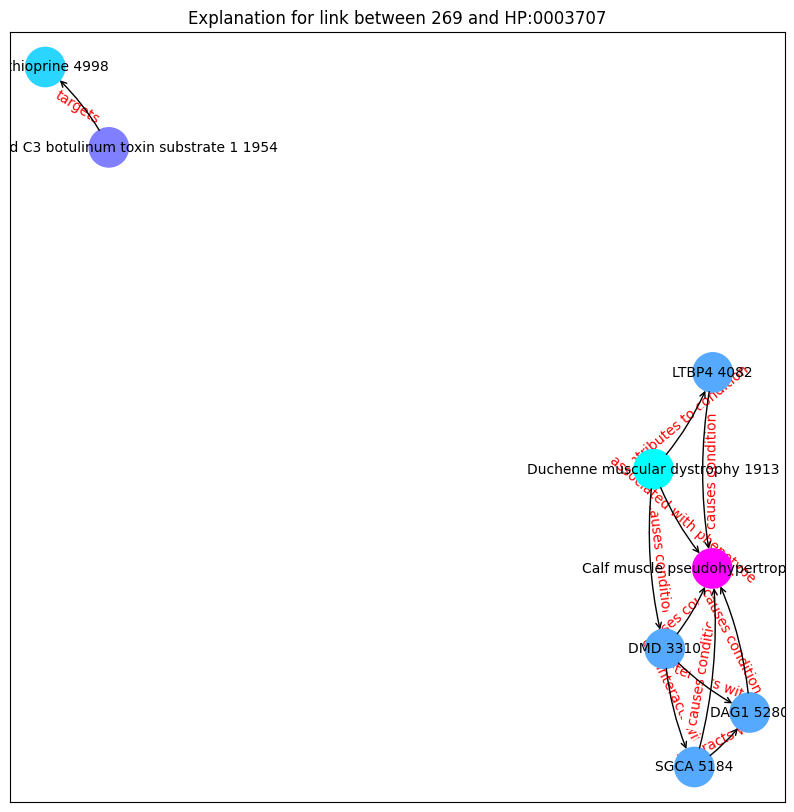

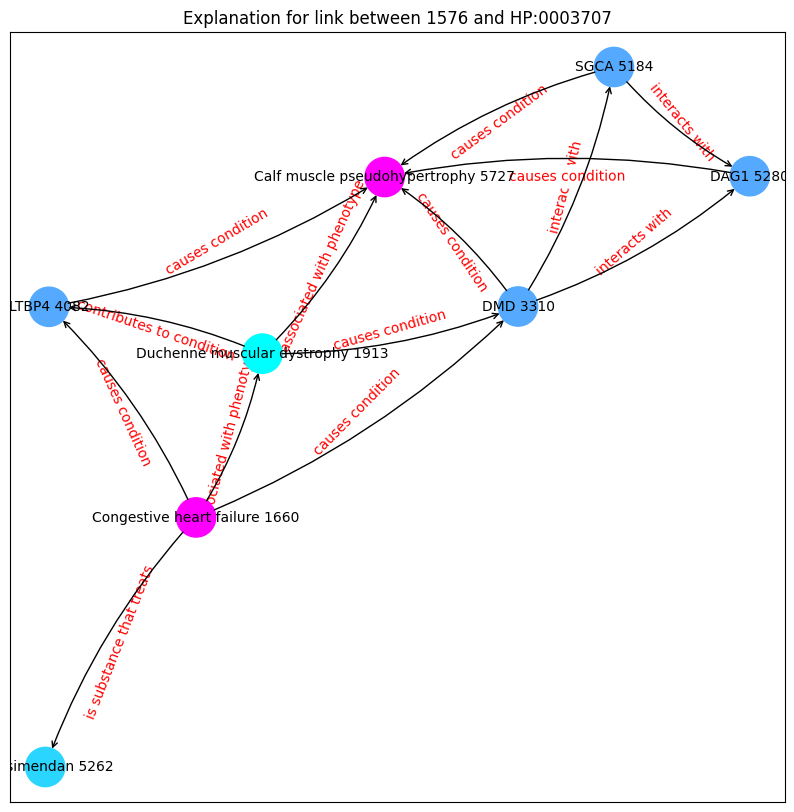

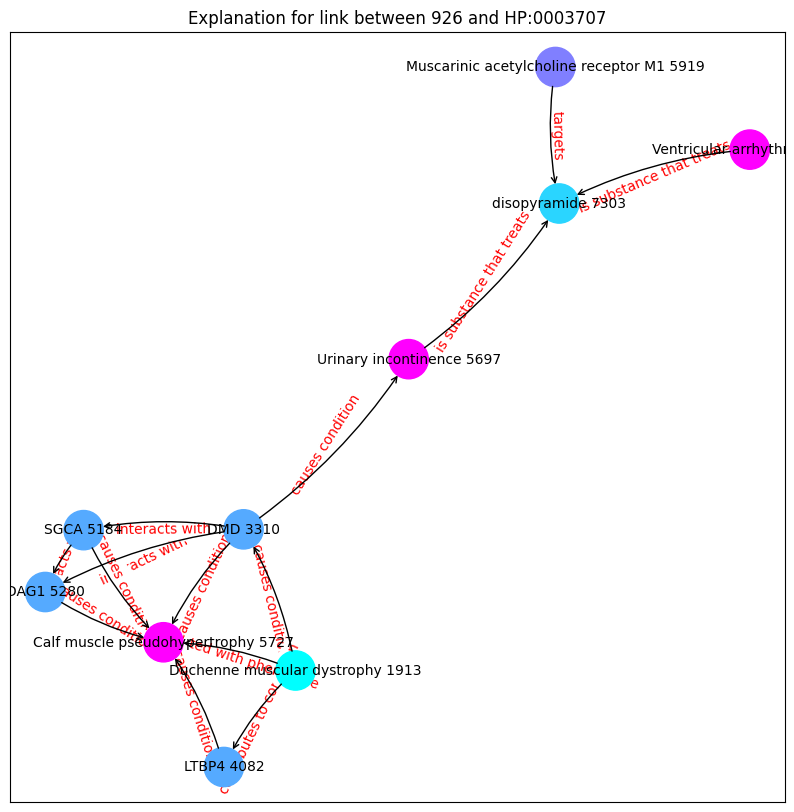

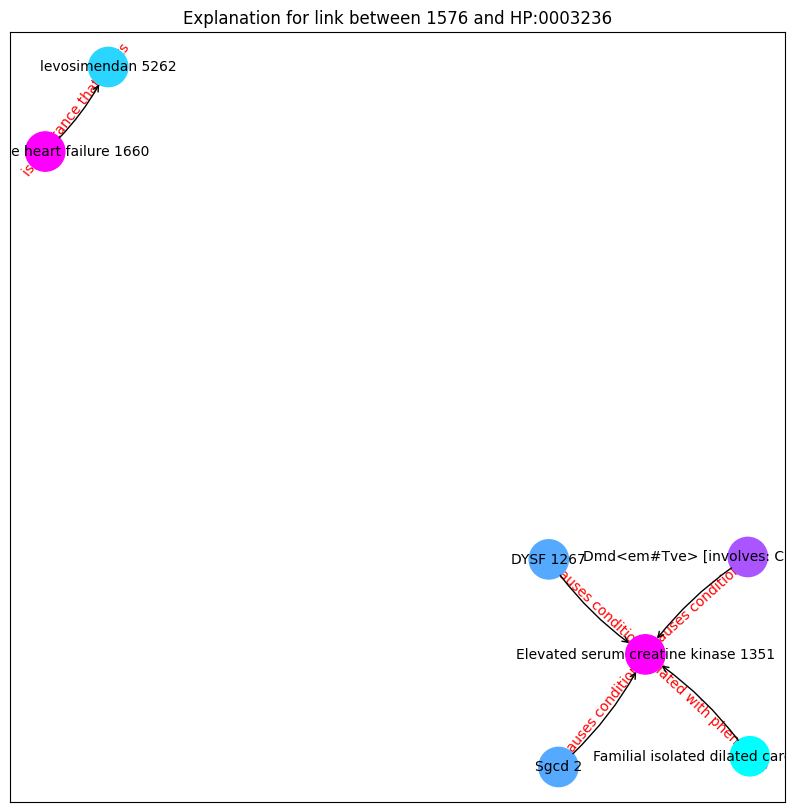

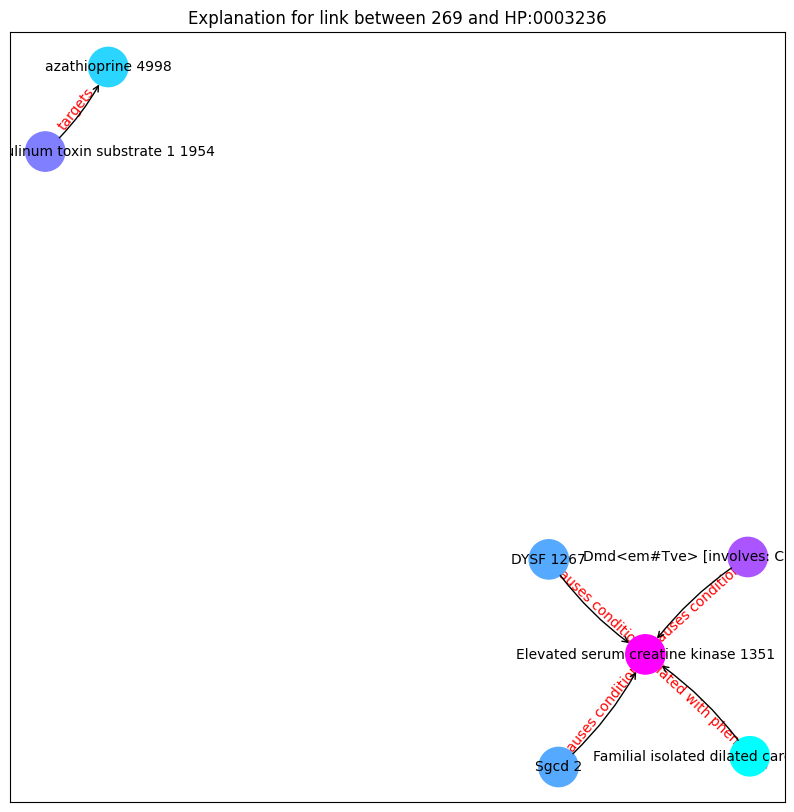

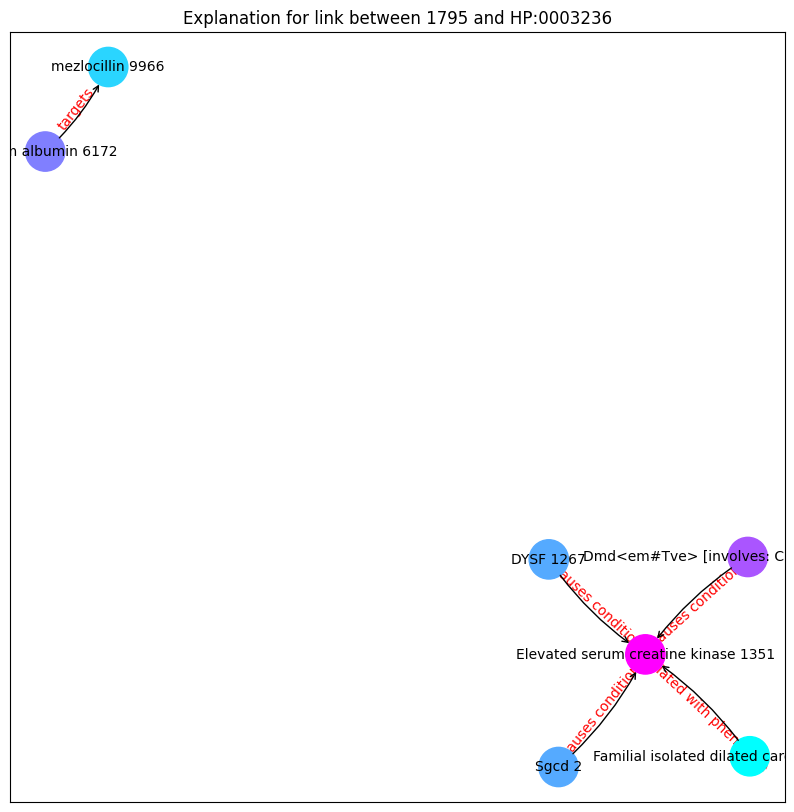

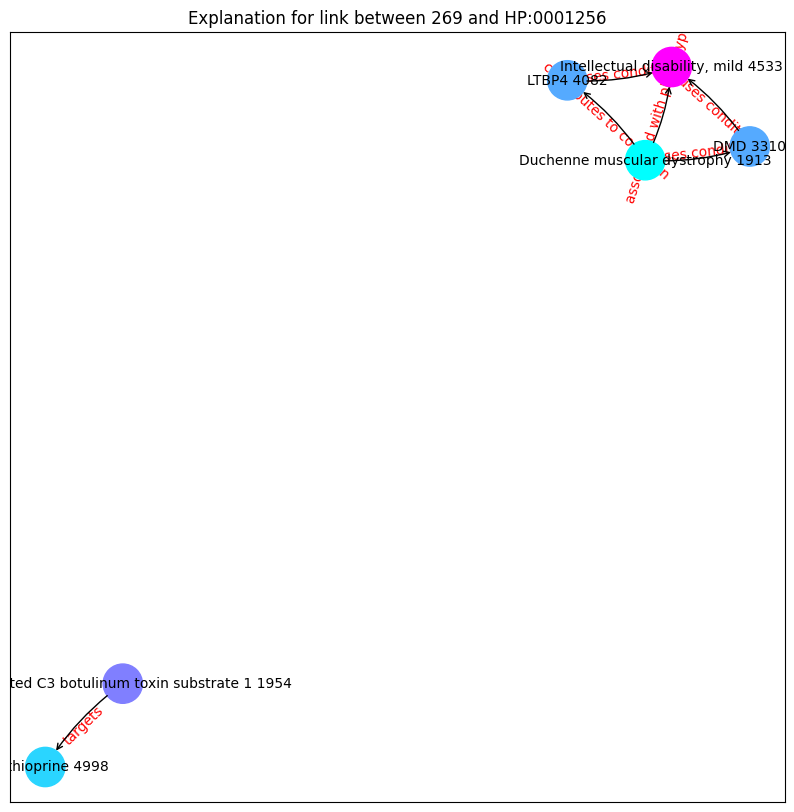

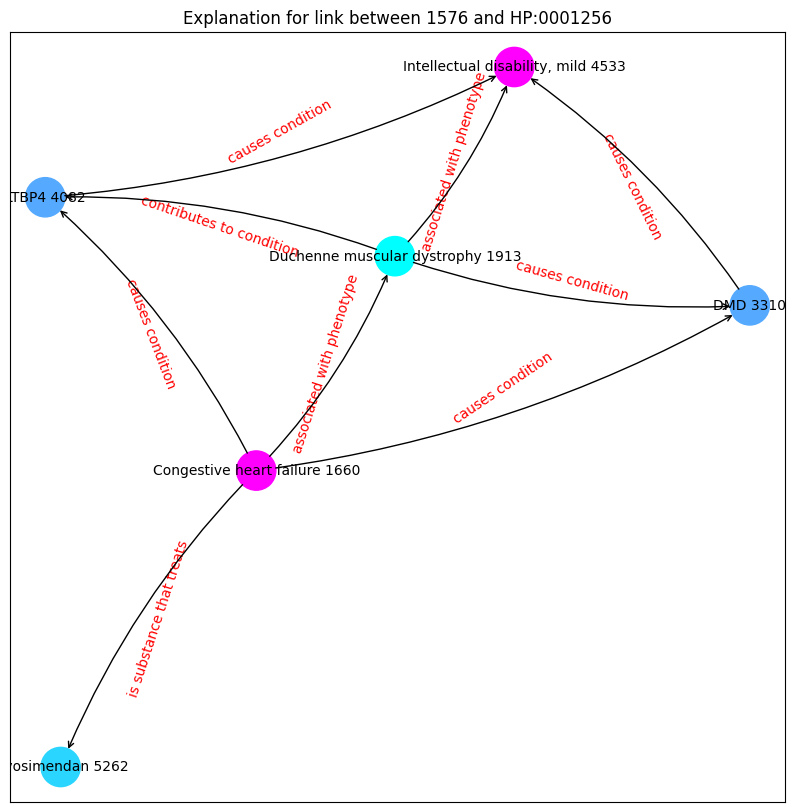

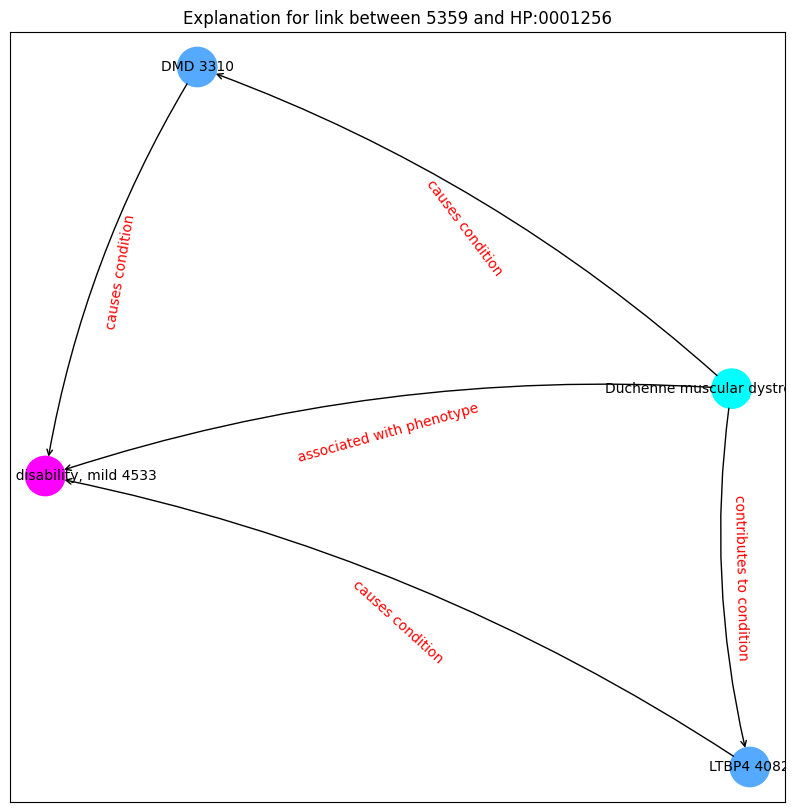

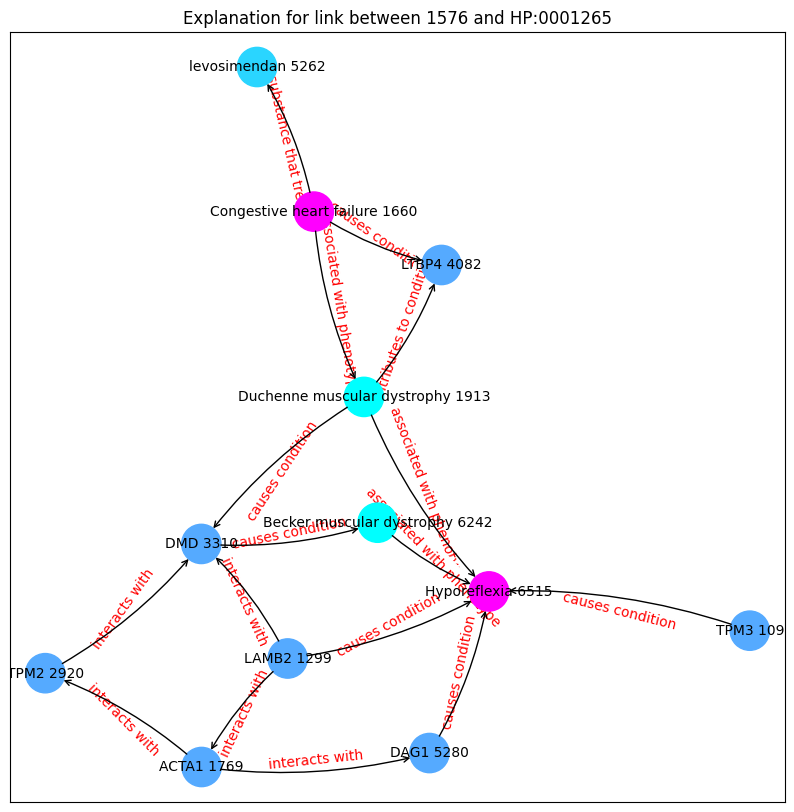

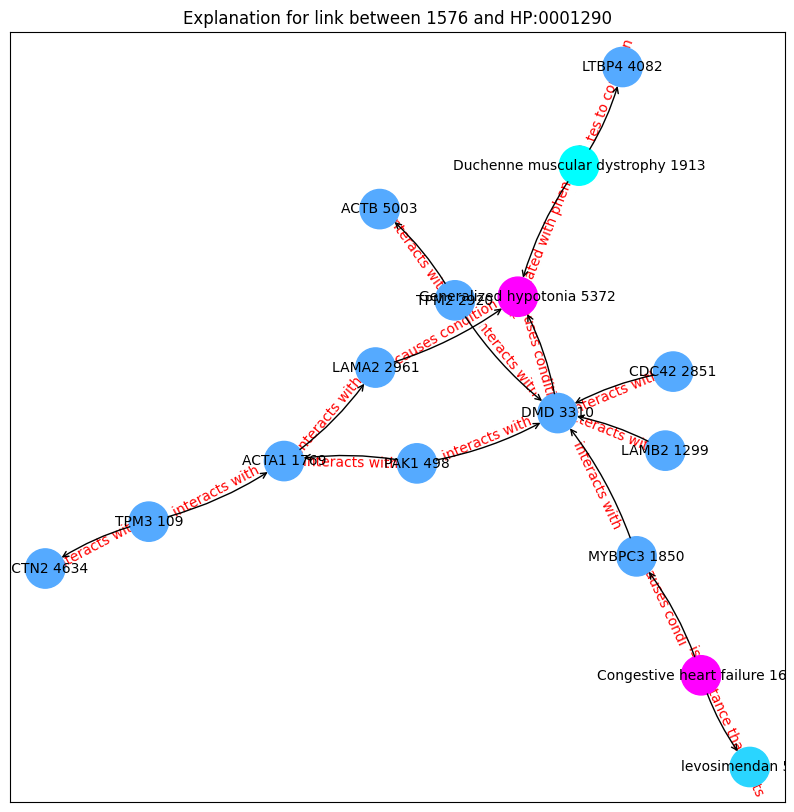

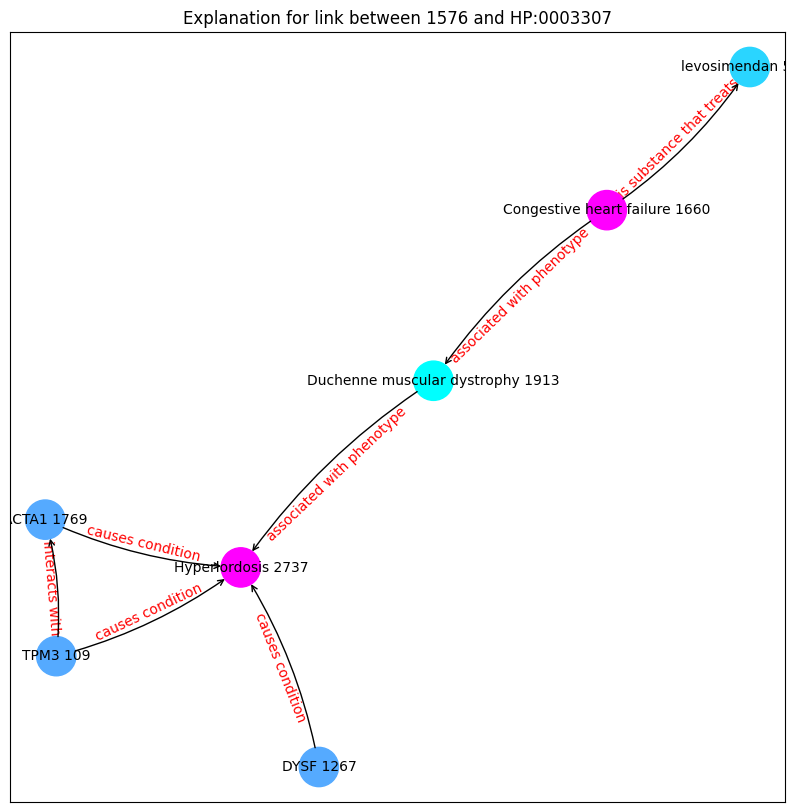

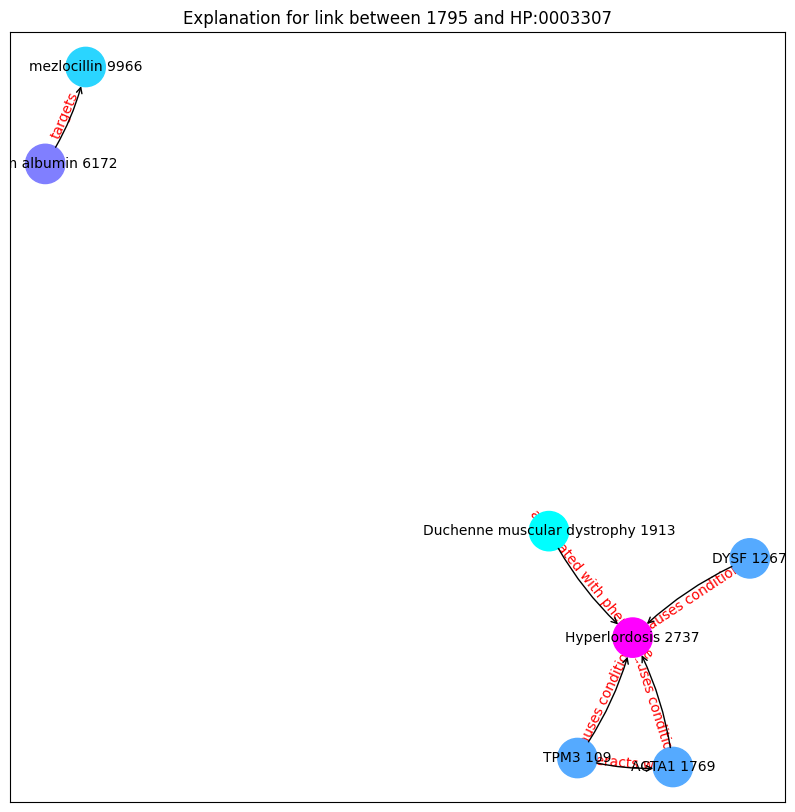

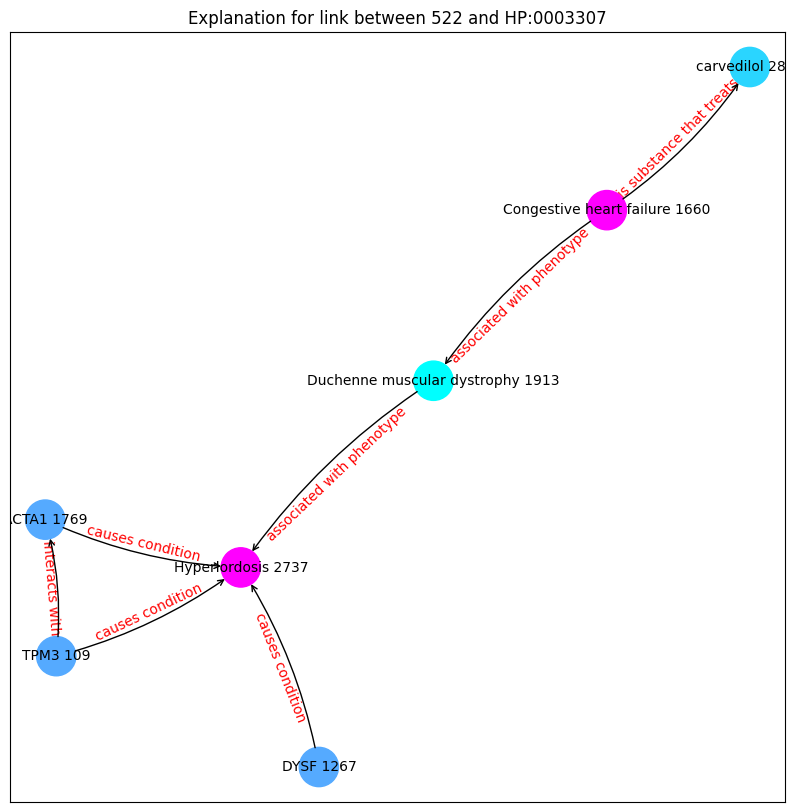

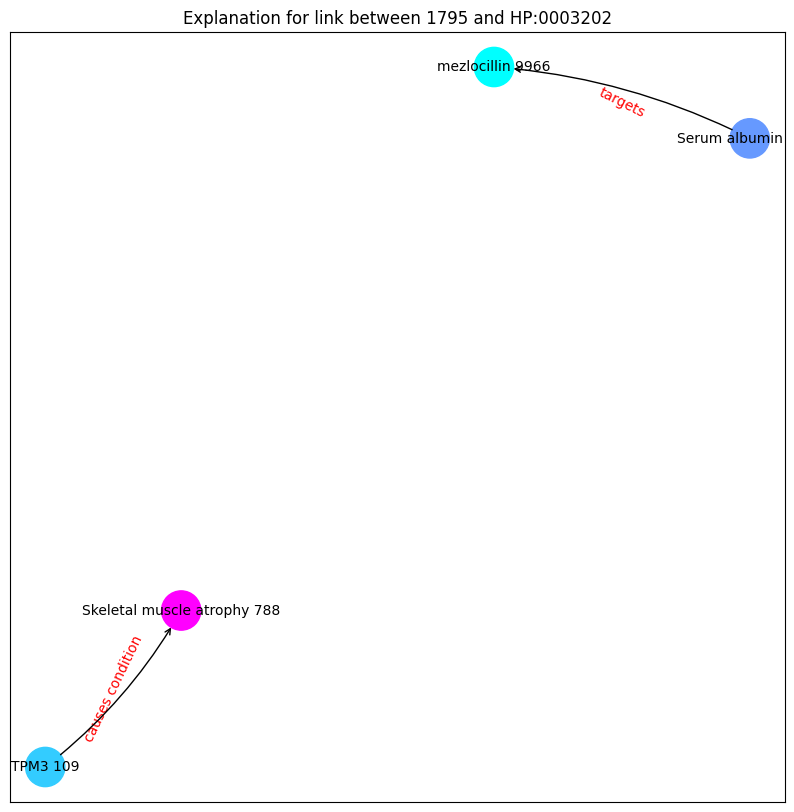

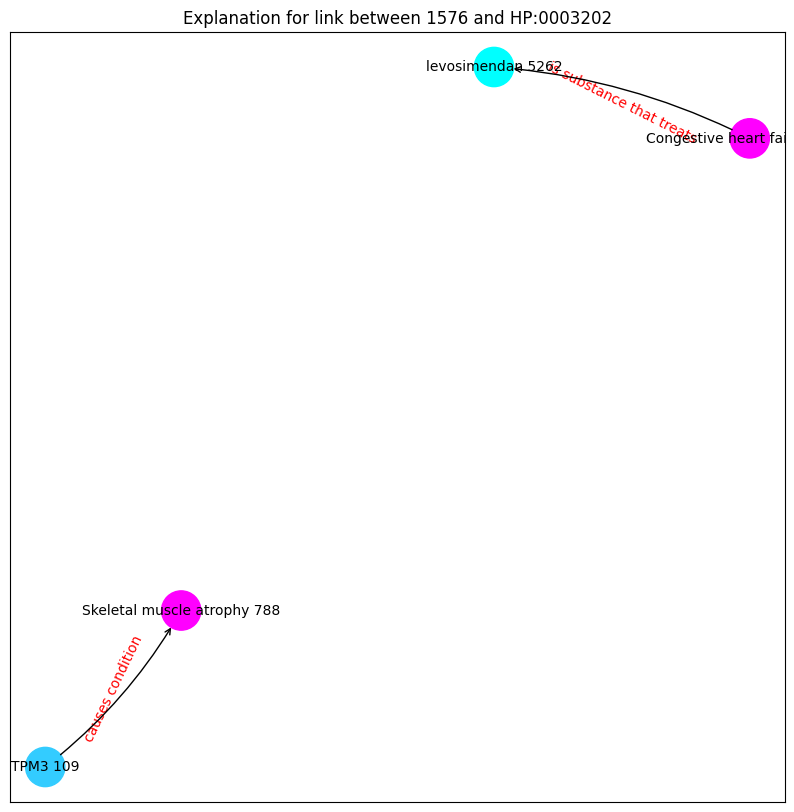

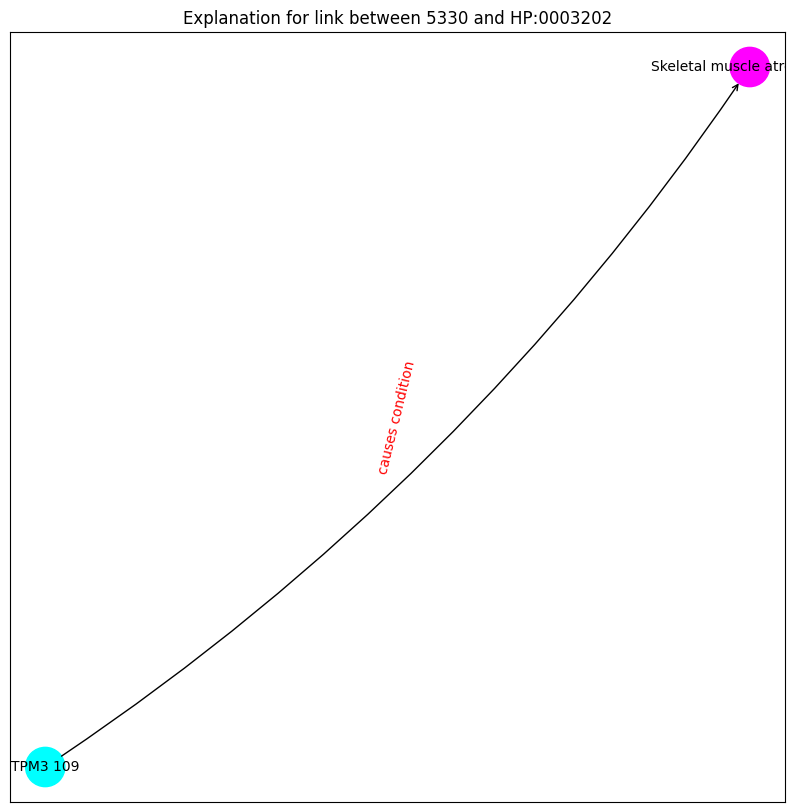

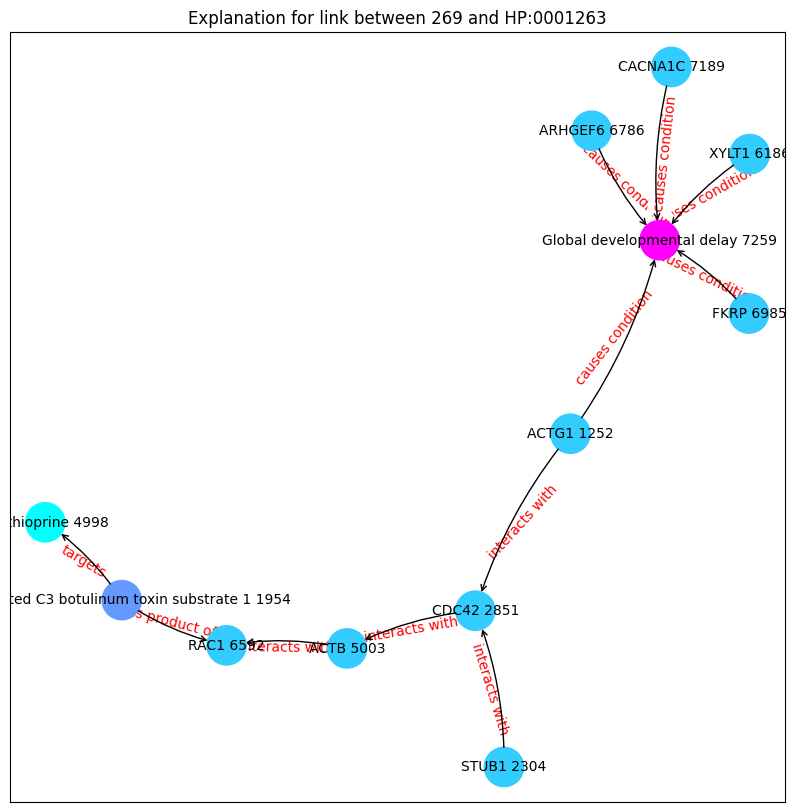

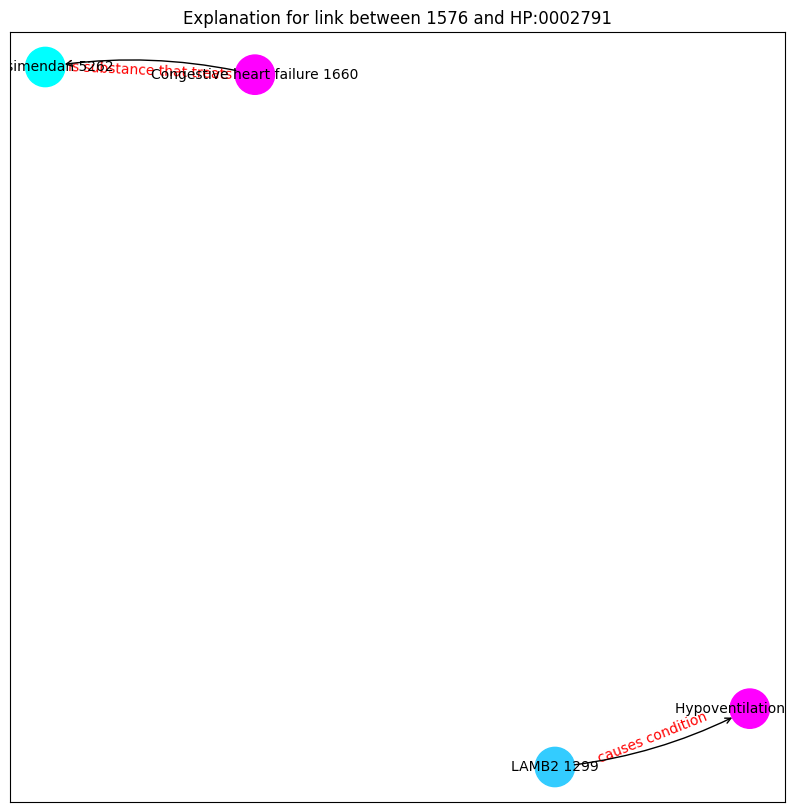

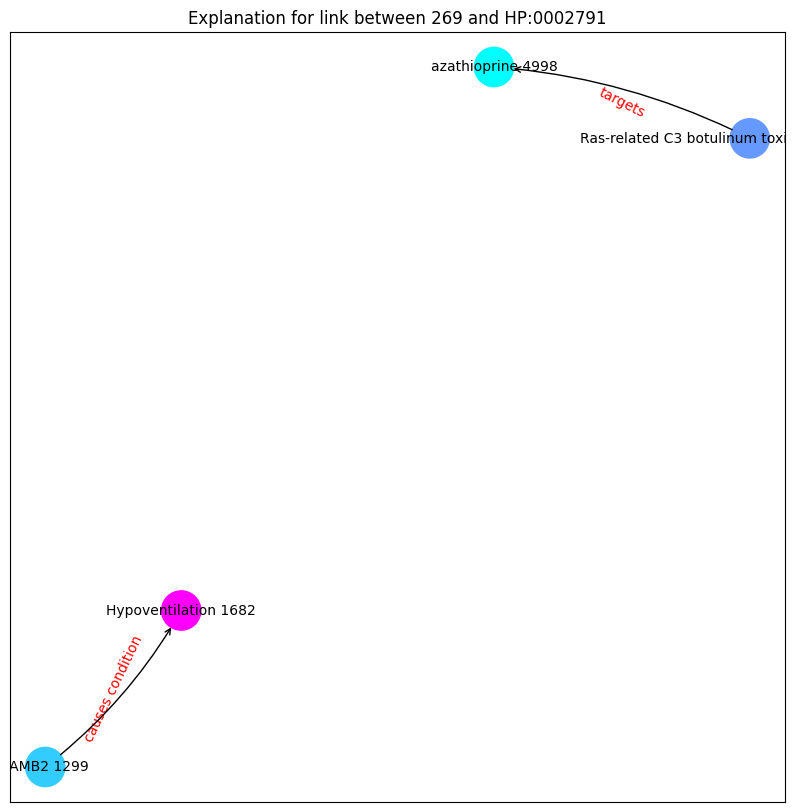

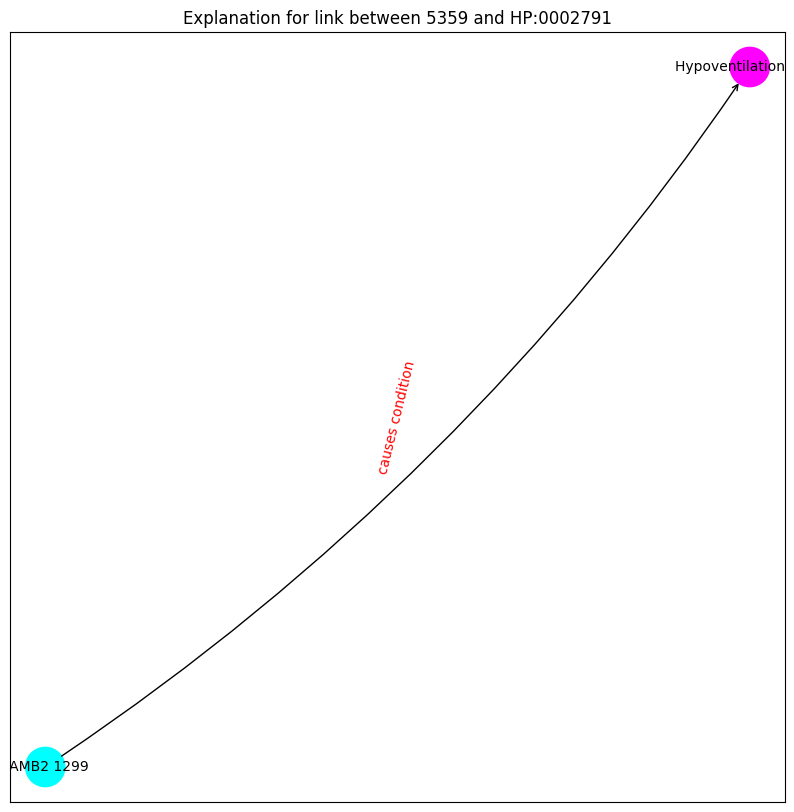

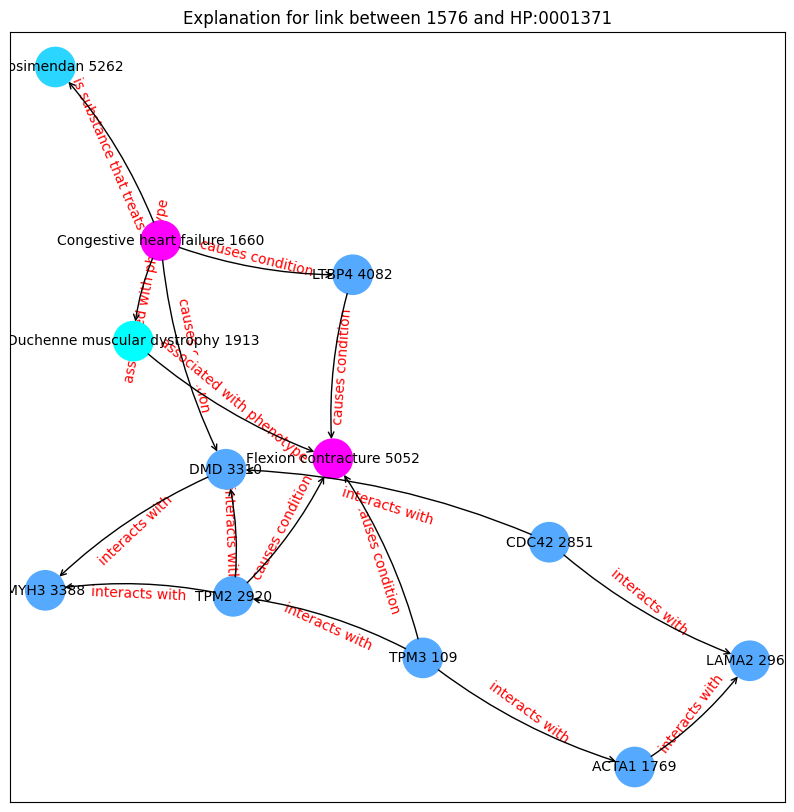

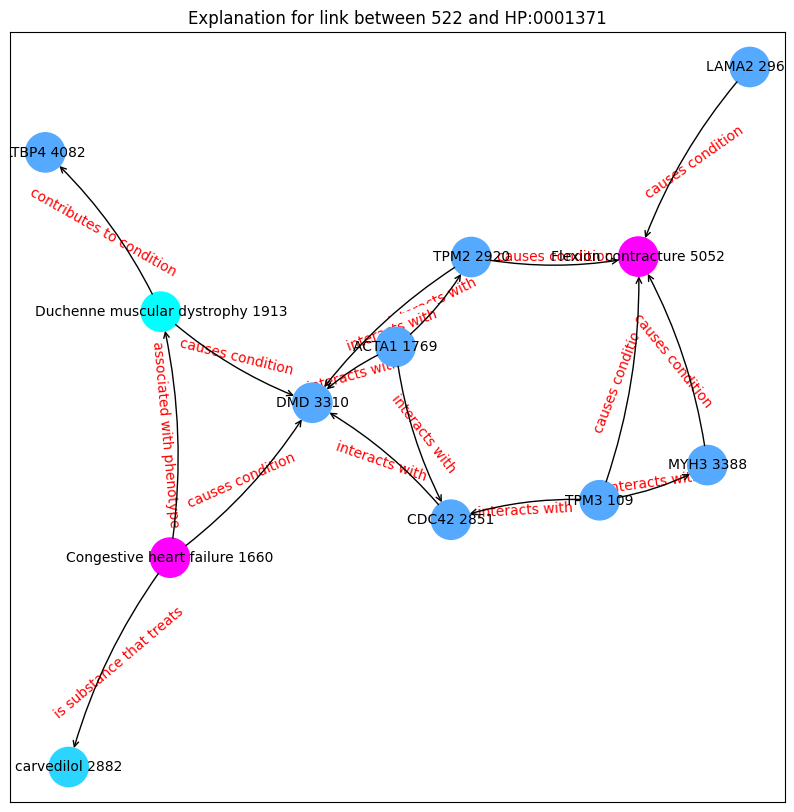

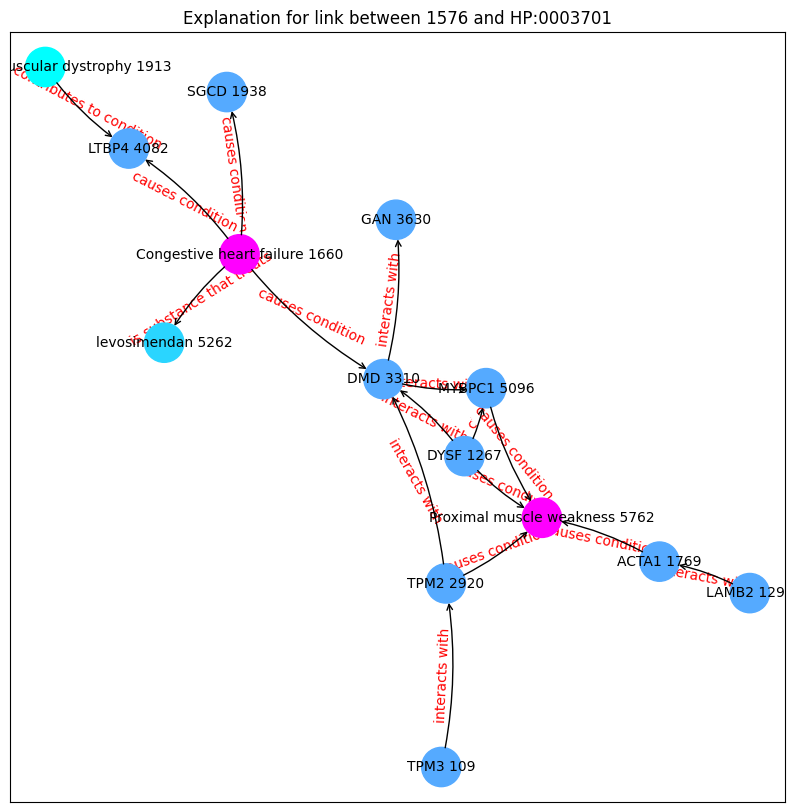

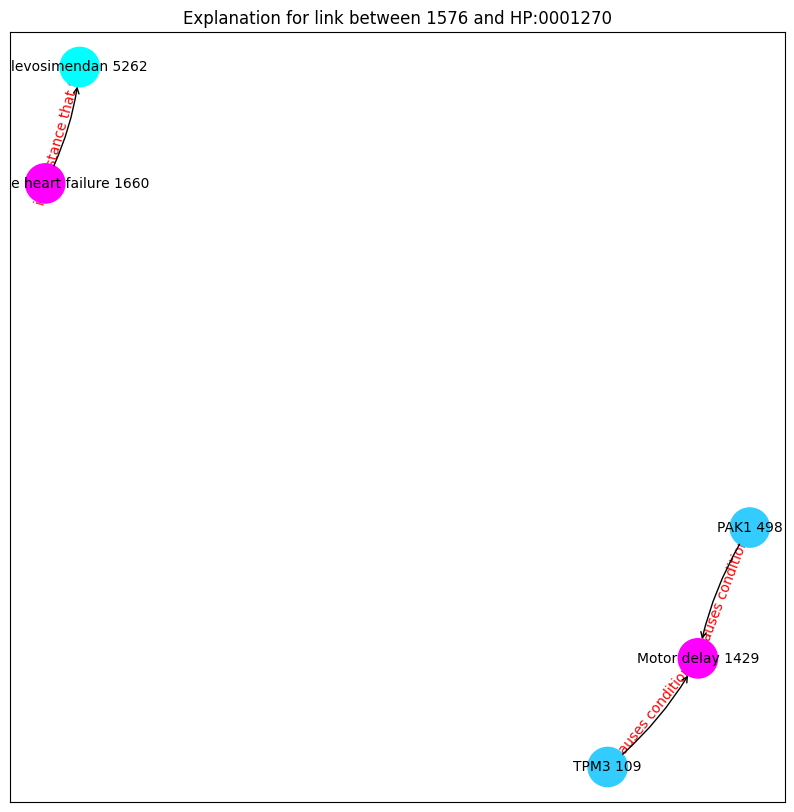

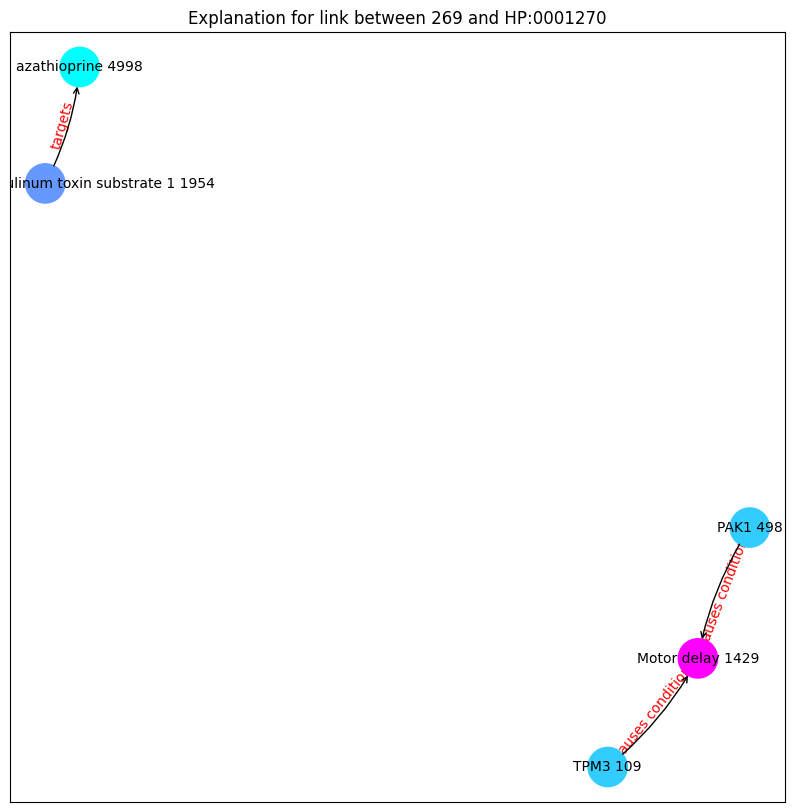

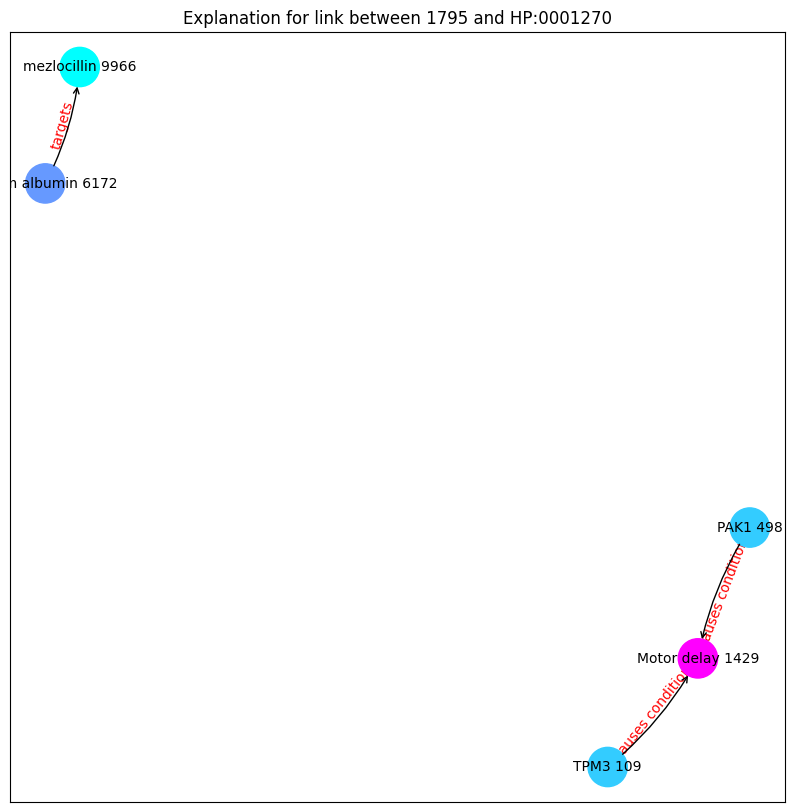

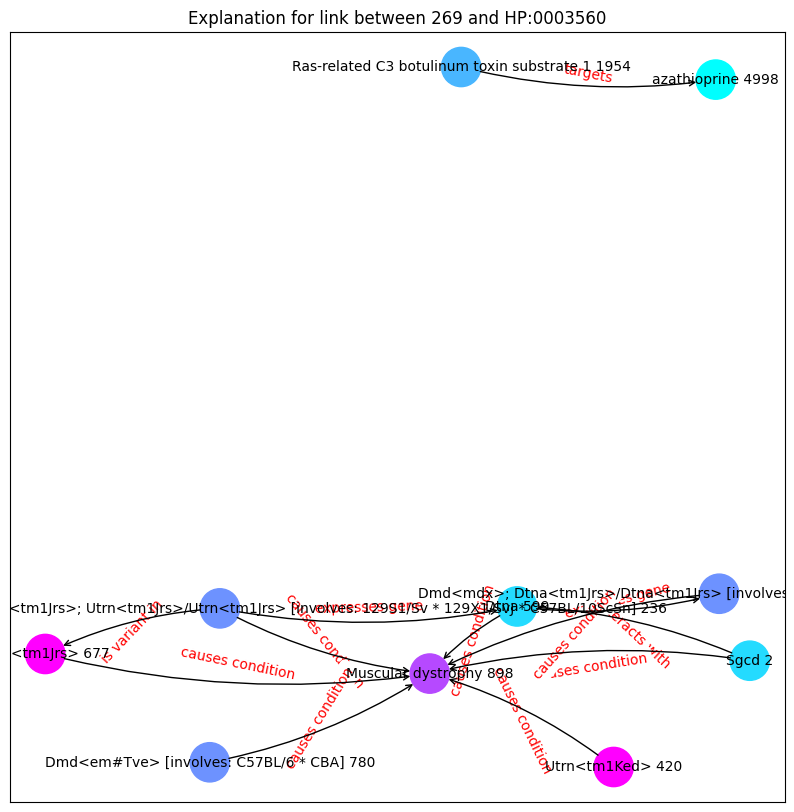

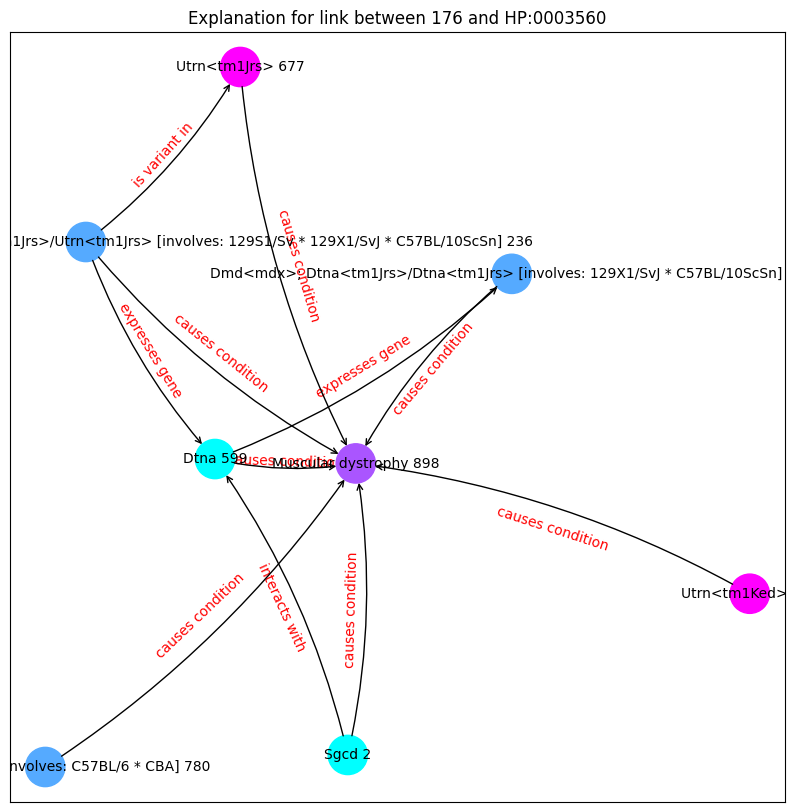

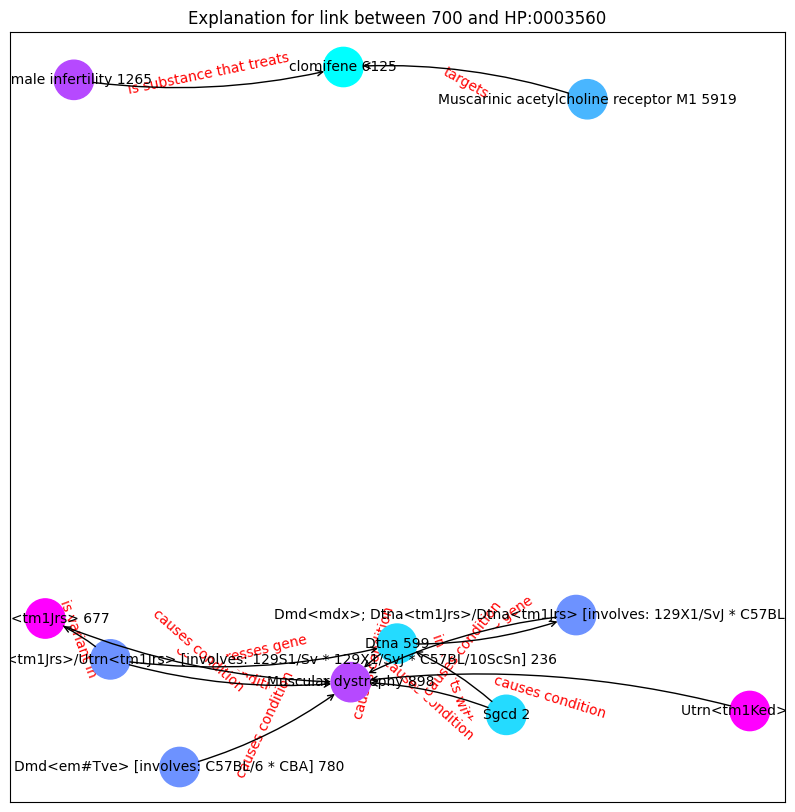

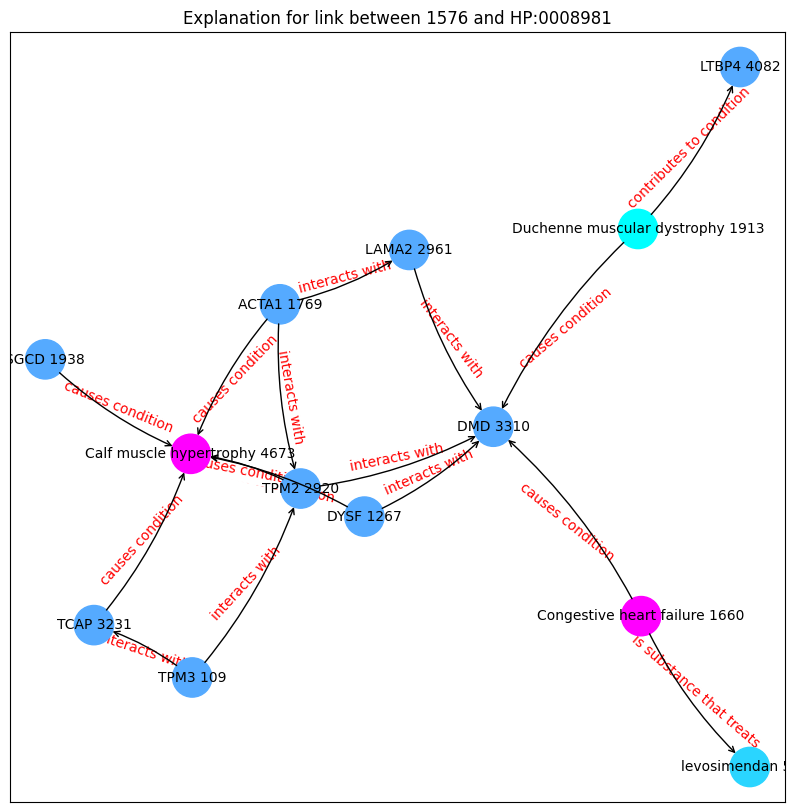

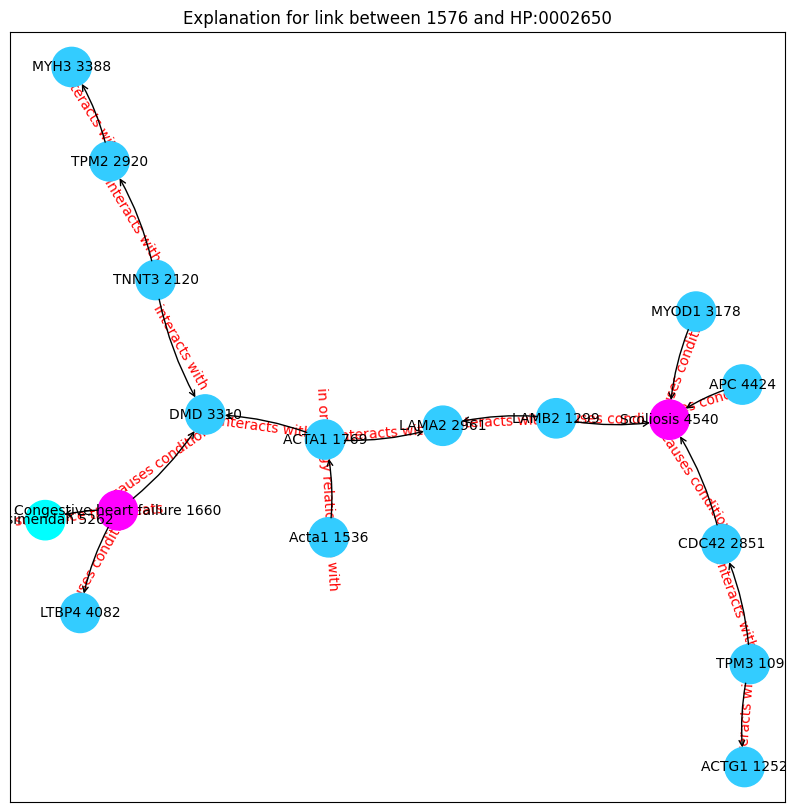

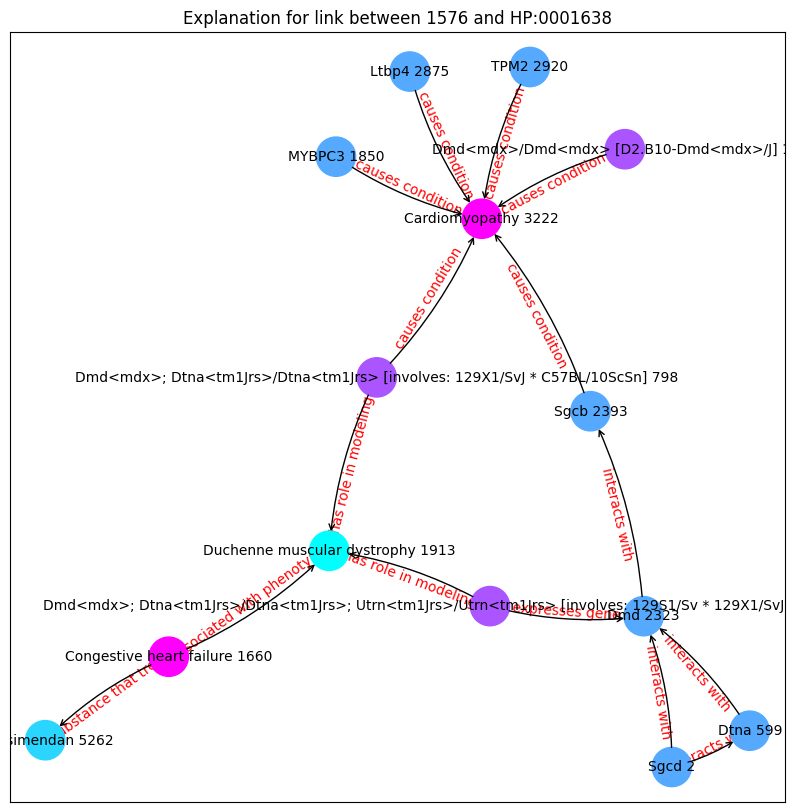

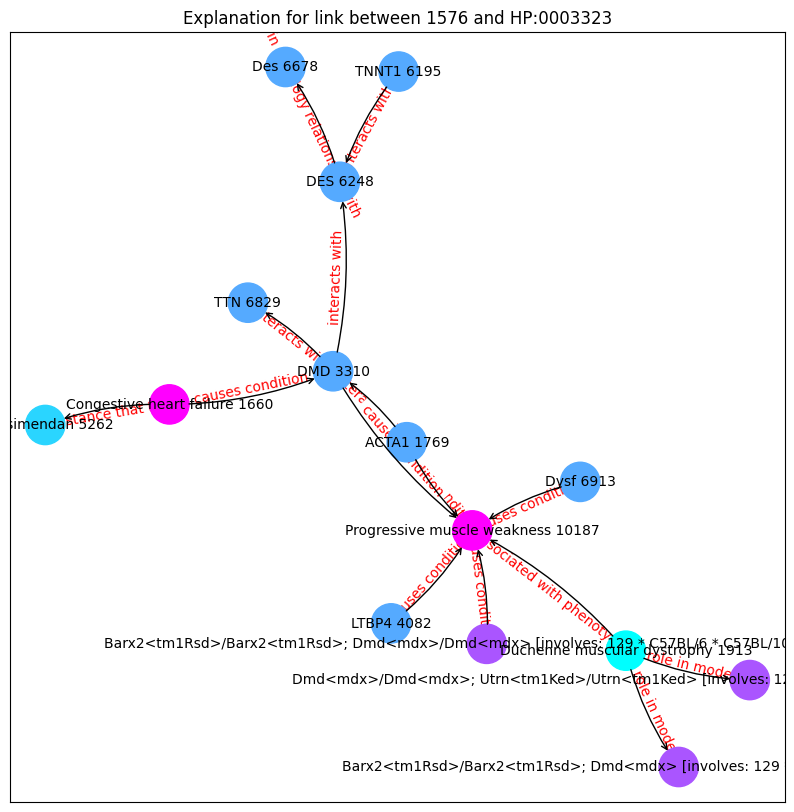

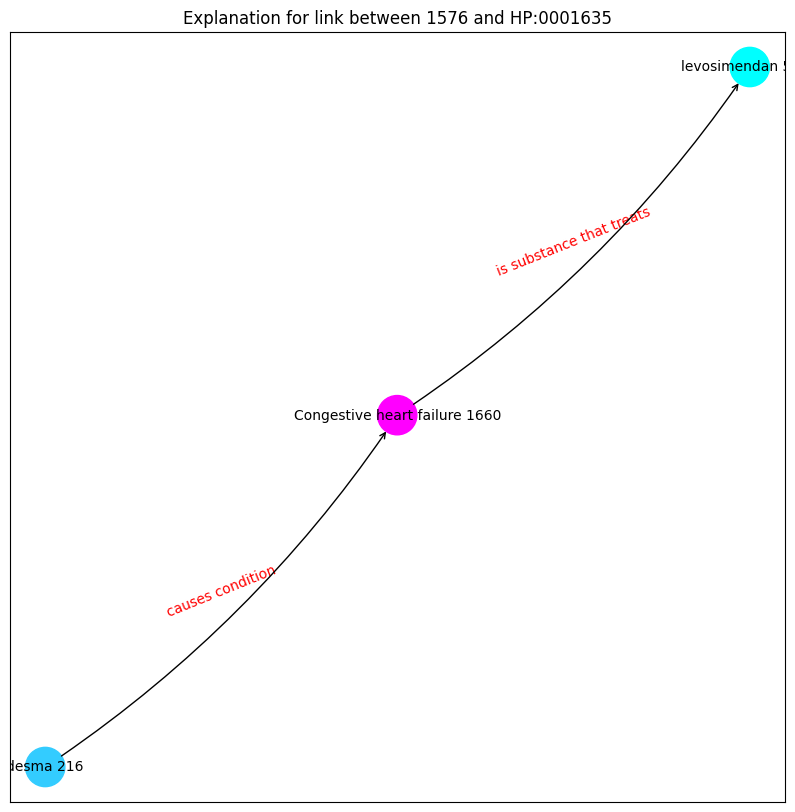

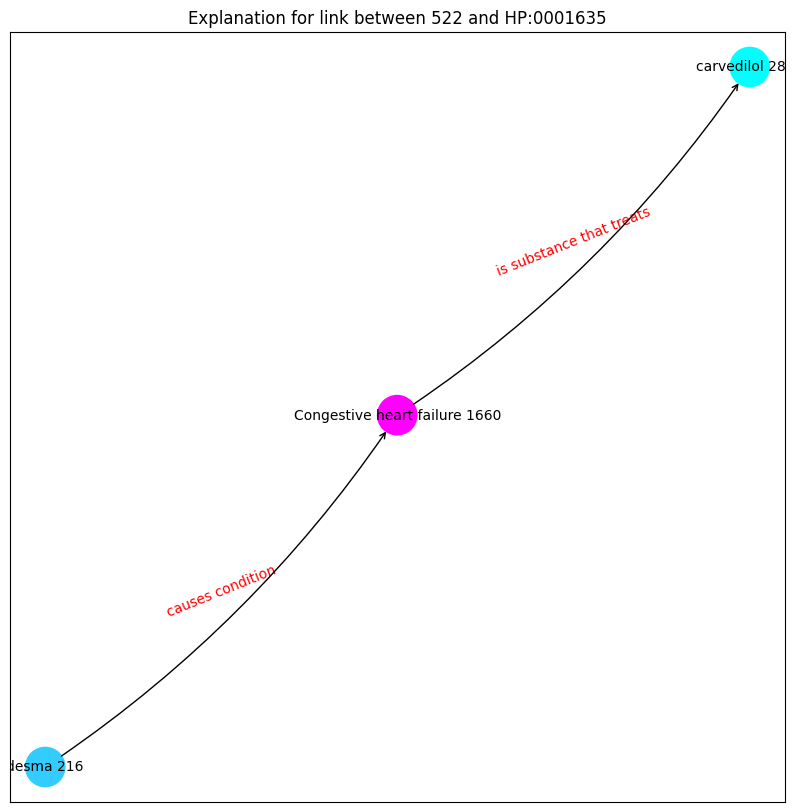

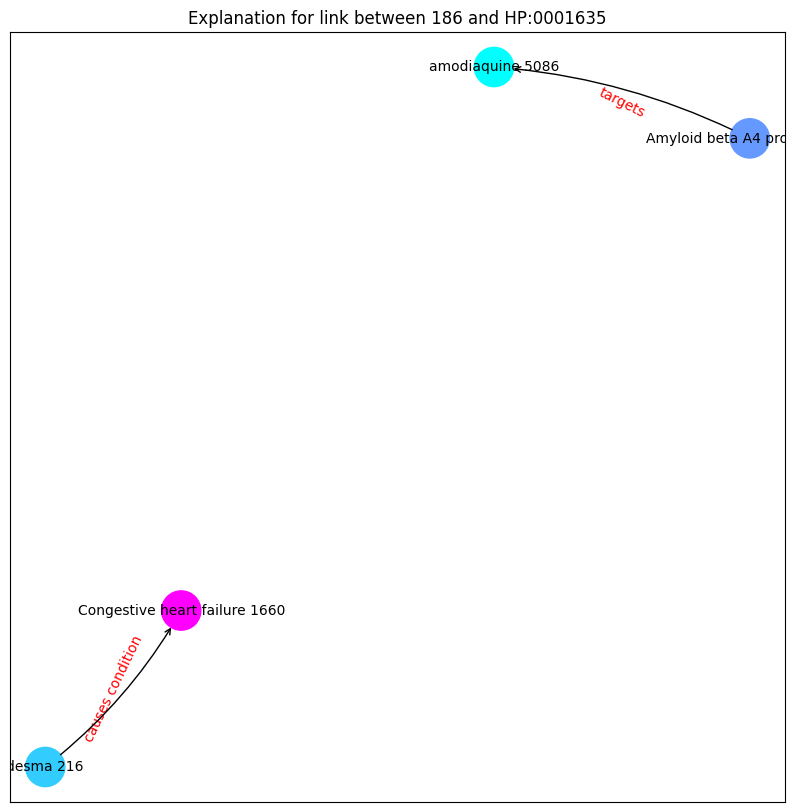

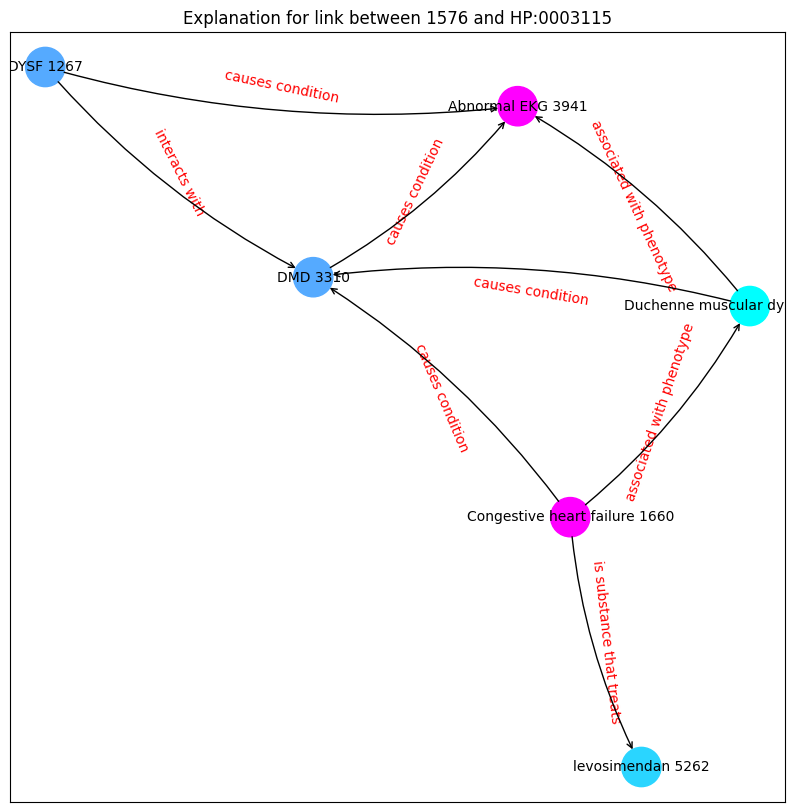

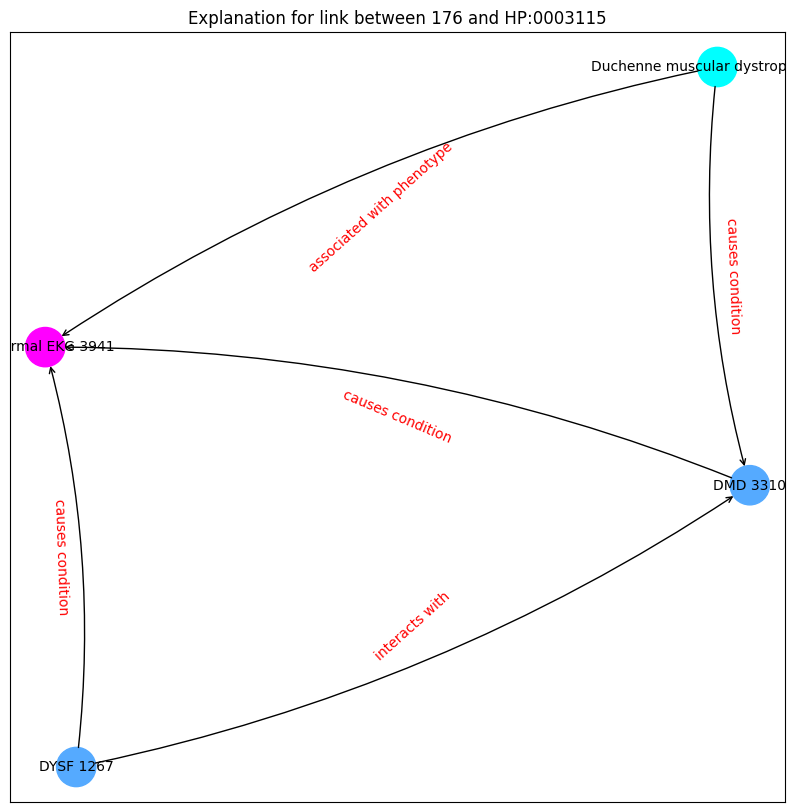

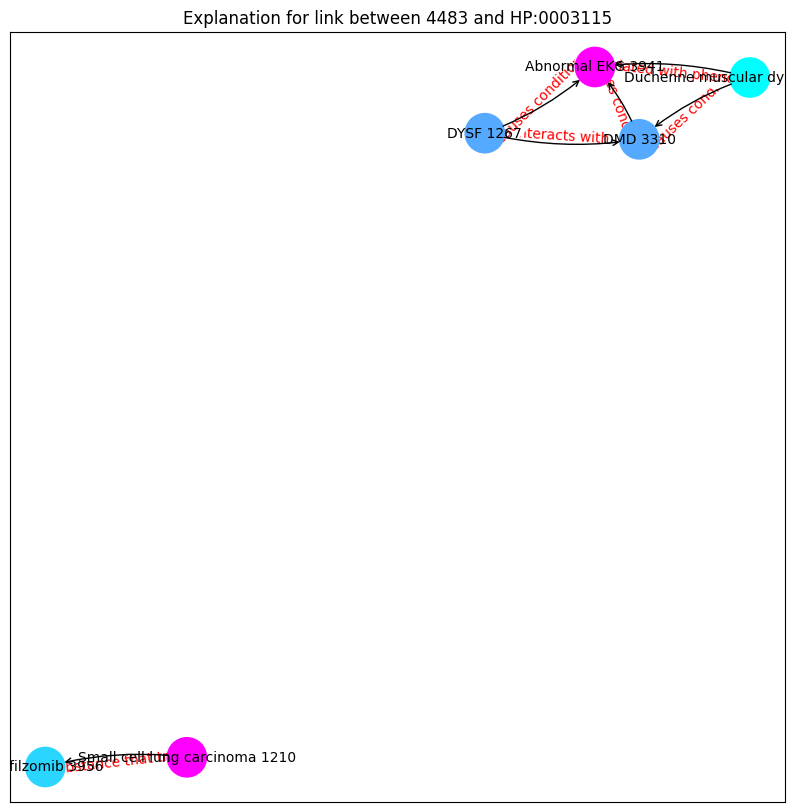

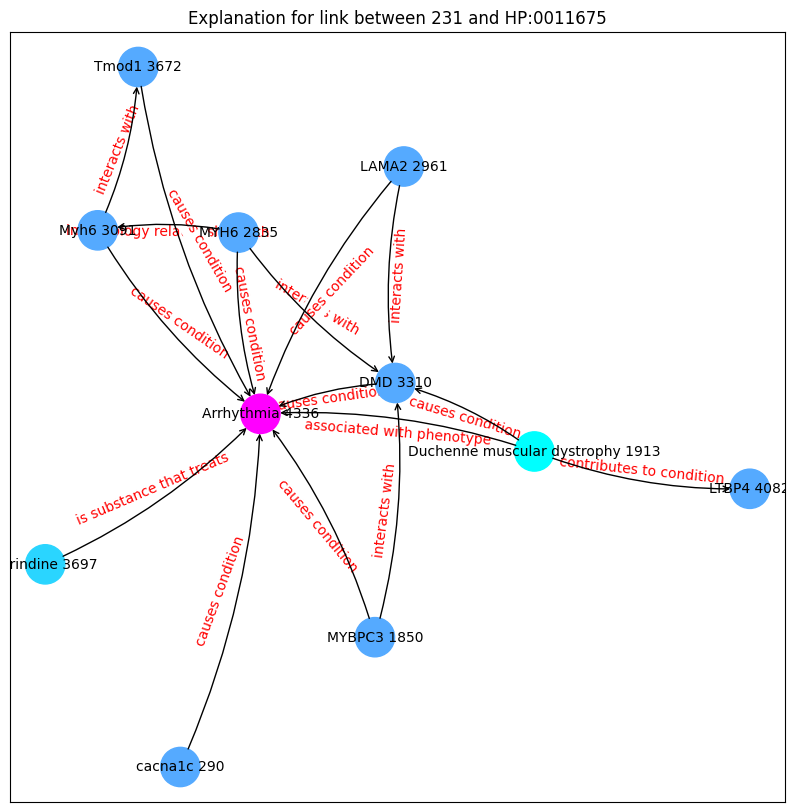

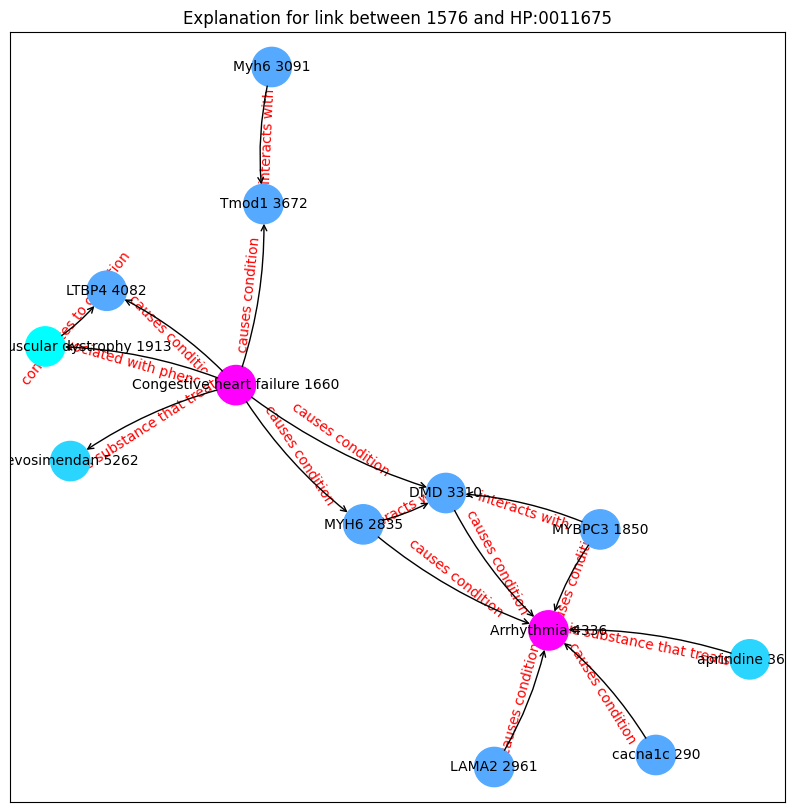

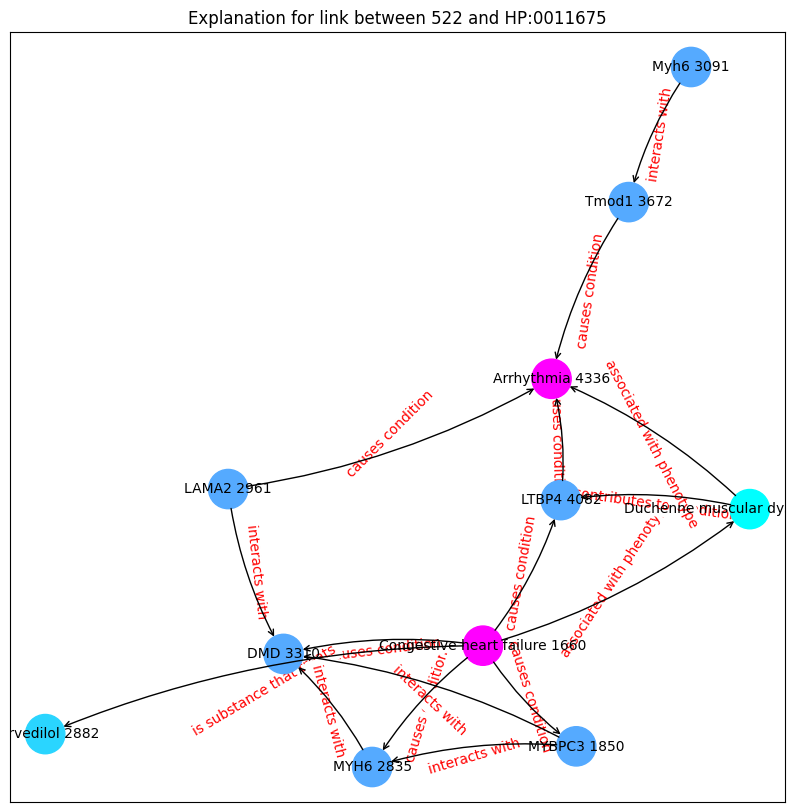

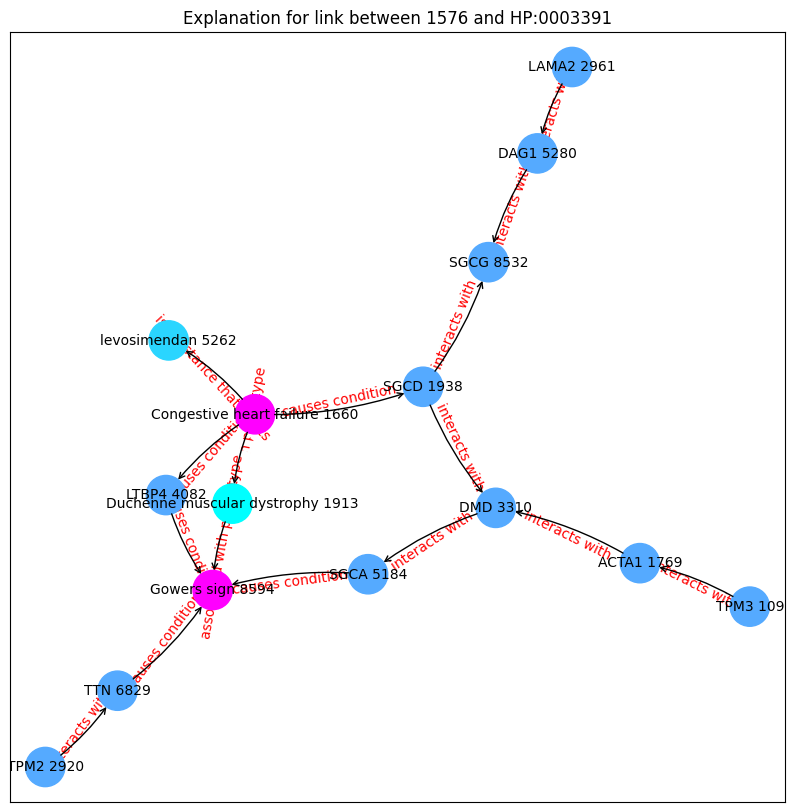

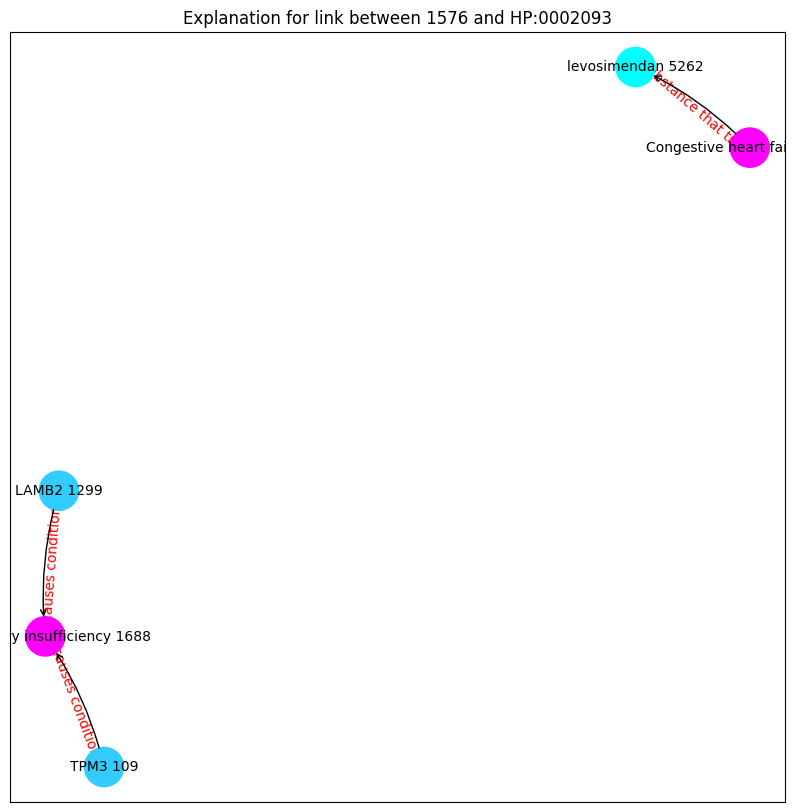

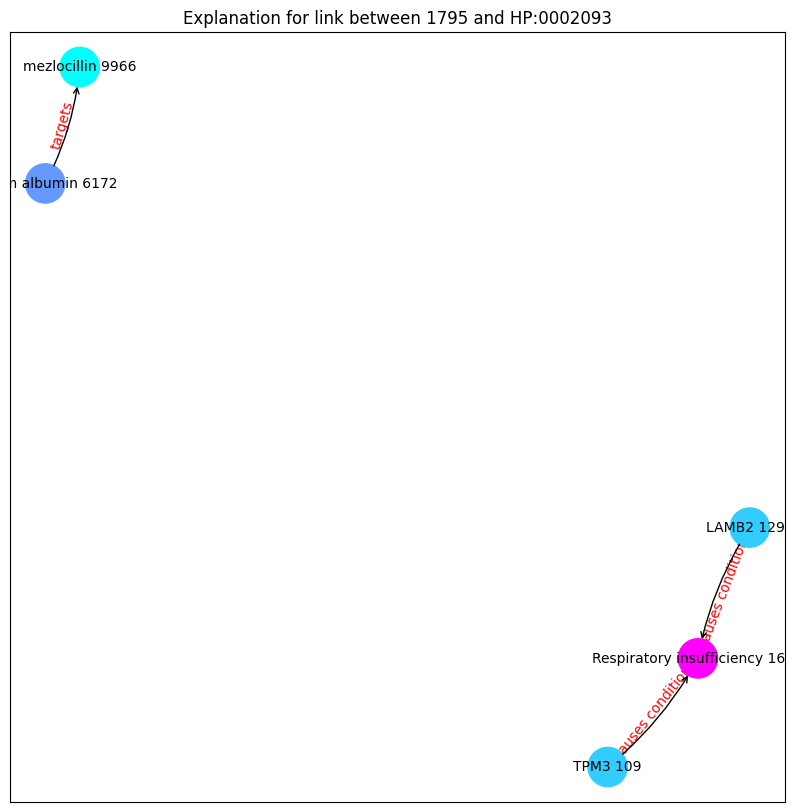

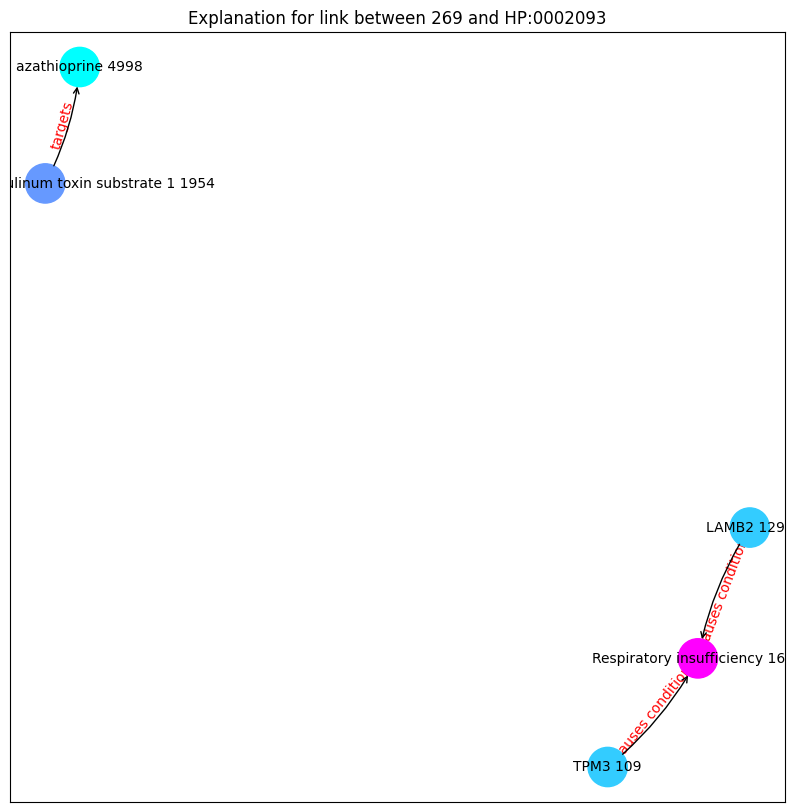

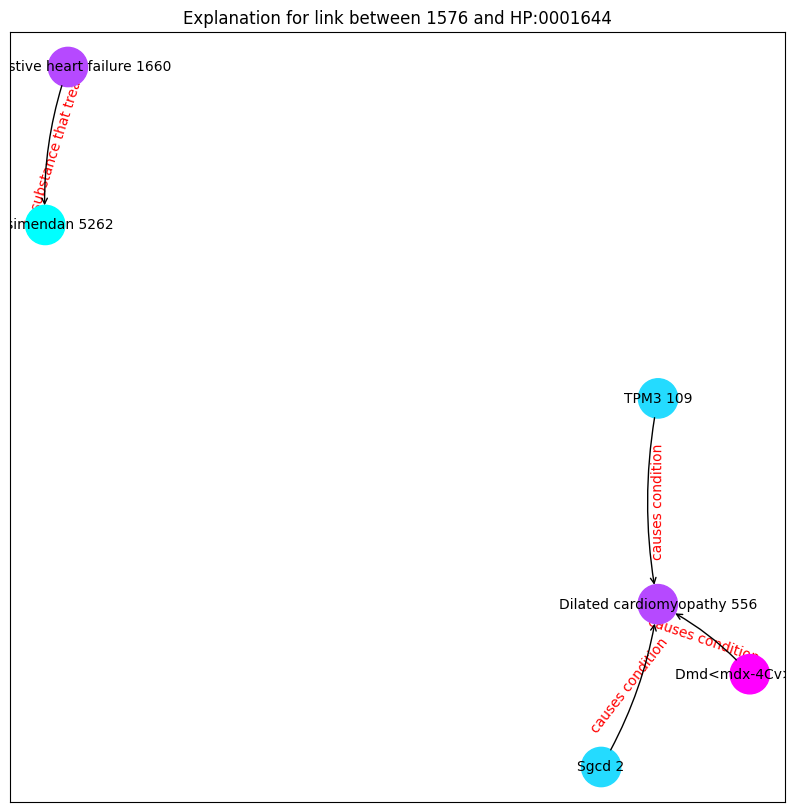

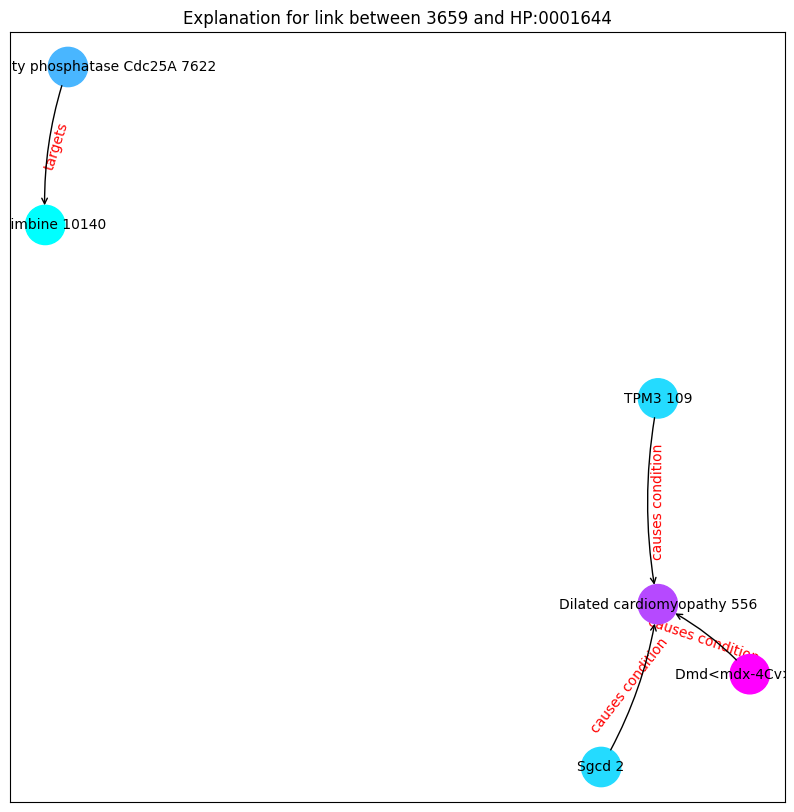

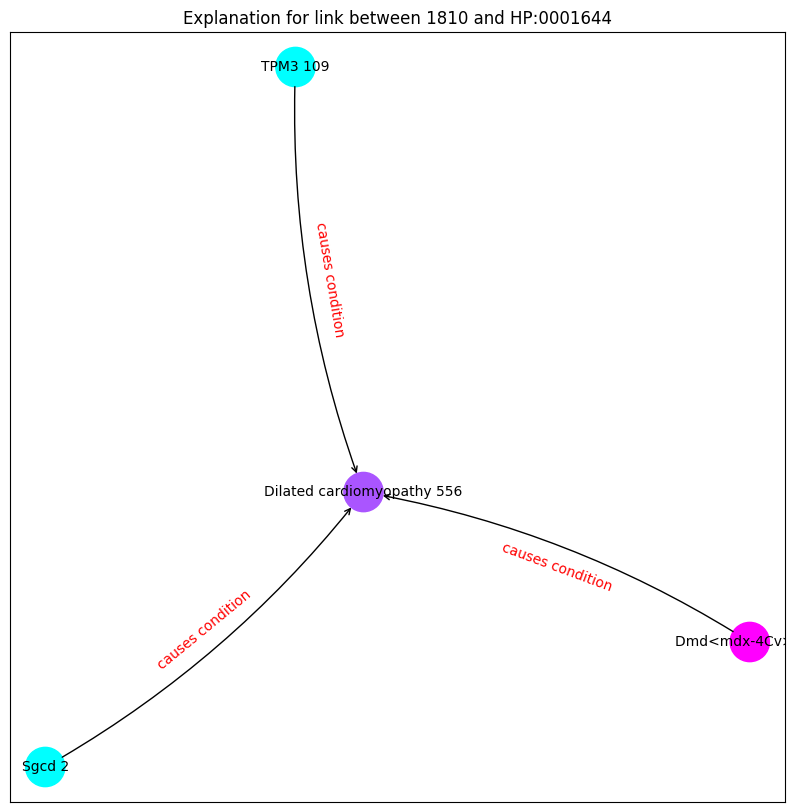

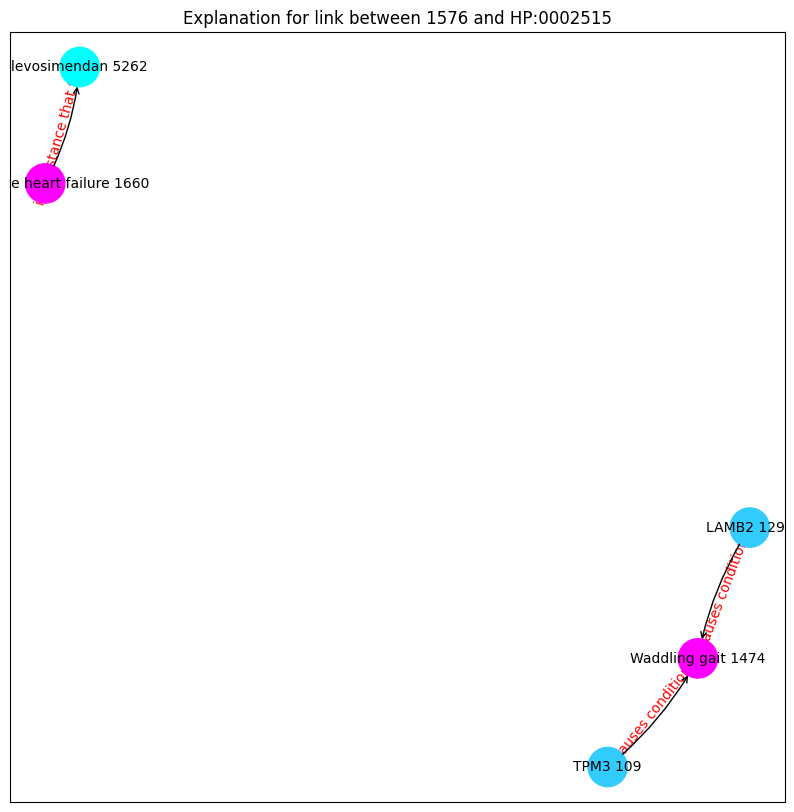

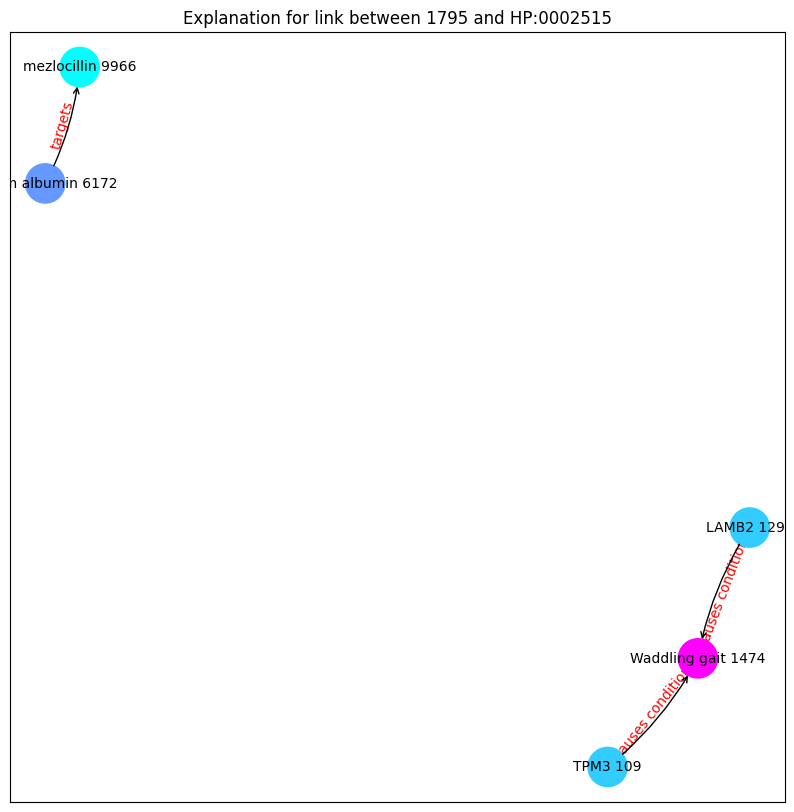

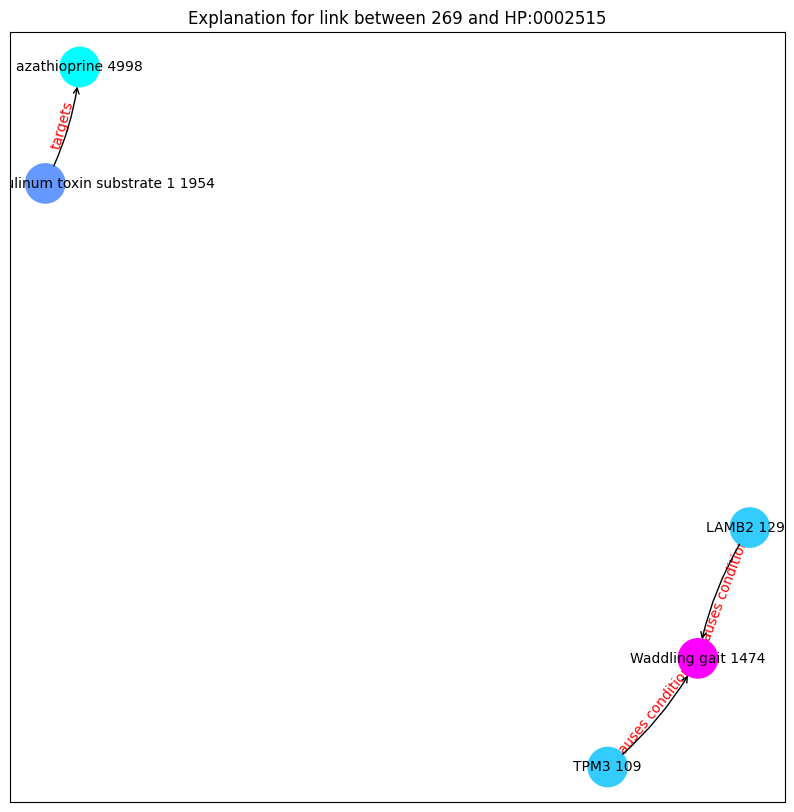

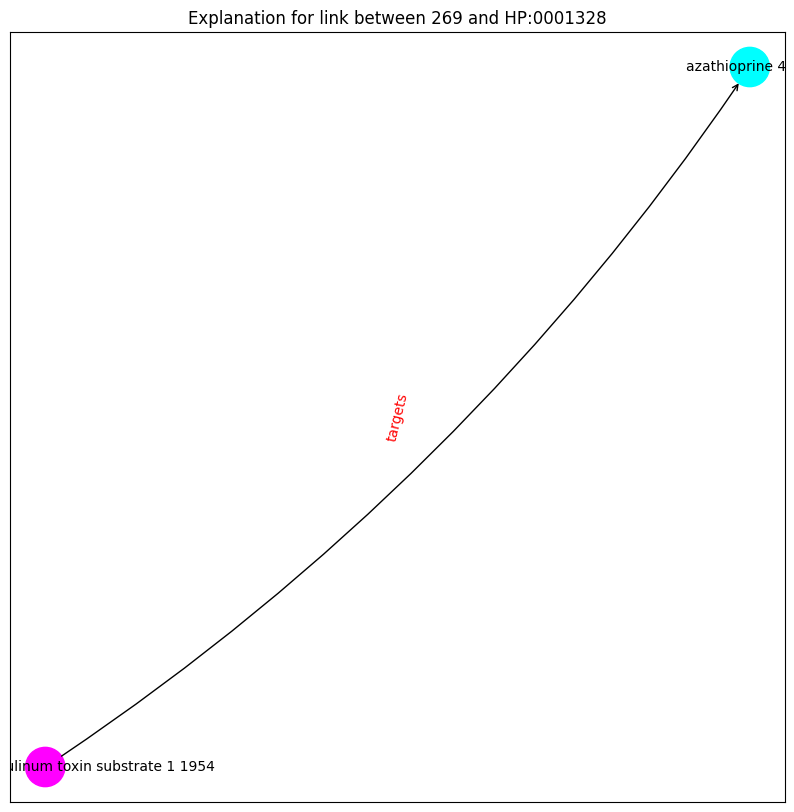

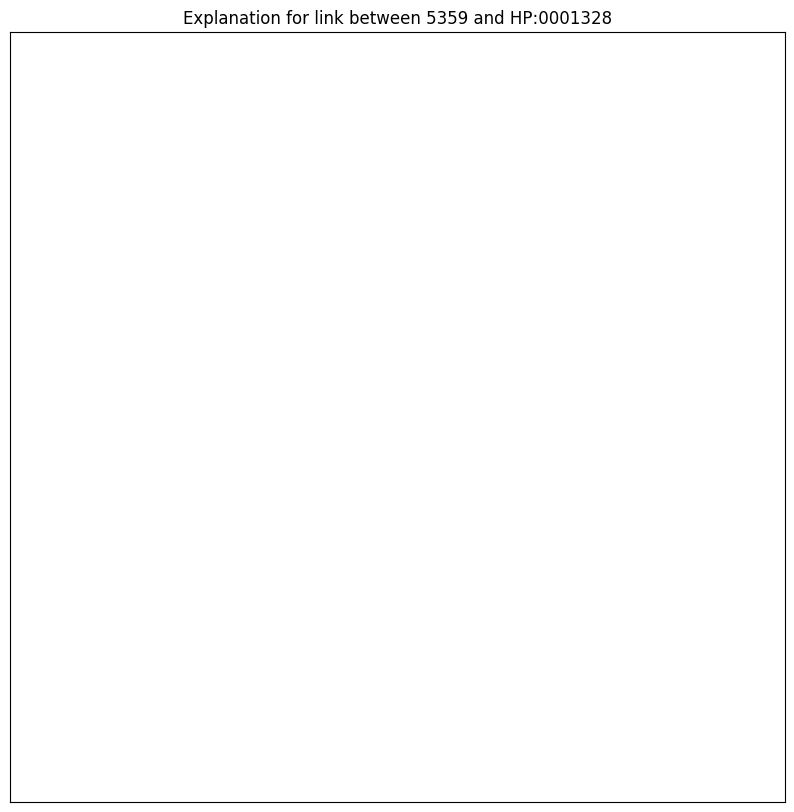

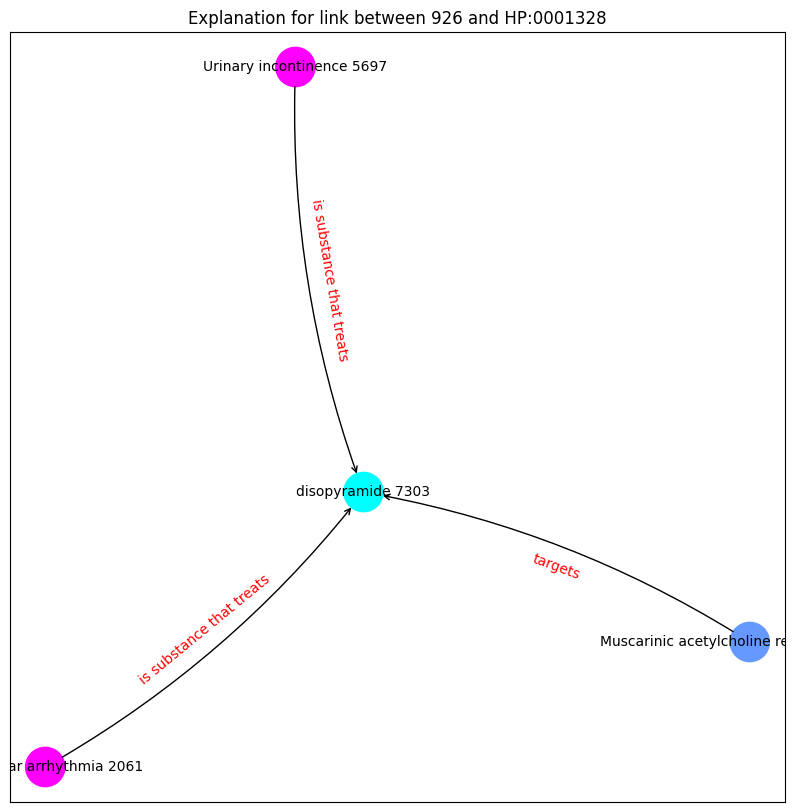

In [15]:
for i, explanation in enumerate(found_explanation):
    nodes_idxs = torch.Tensor([explanation['node_idx1'], explanation['node_idx2']]).long()

    plt.figure(figsize=(10, 10))
    plt.title(f"Explanation for link between {explanation['drug']} and {explanation['symptom']}")
    ax, G_sub = visualize_subgraph(nodes_idxs, edge_index, explanation['found_edge_mask'], nodes = nodes, y=torch.Tensor(nodes.semantic_id), seed = 667, num_hops = 1, threshold=explanation['found_limit'], node_label = 'label', edge_labels = edge_labels_dict, show_inactive = False, remove_unconnected = True)
    plt.show()

Really dependent on parameter of trained model.